In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import mglearn
from sklearn.tree import DecisionTreeClassifier

## 0. Preprocessing

In [2]:
data = pd.read_csv('../data/output.csv')

#### 0.1 Dropping : siret, id, categorie_juridique, activite_principale, instruction_comment 

In [3]:
data = data.drop(columns = ['id','siret','categorie_juridique','activite_principale','instruction_comment','fondement_juridique_url'])

#### 0.2: Missing values imputation : create a missing_values column

In [4]:
missing_values_imp = SimpleImputer(strategy='constant',fill_value='missing')
missing_cols = ['categorie_juridique_label','activite_principale_label','nom_raison_sociale','description','intitule','fondement_juridique_title']
data[missing_cols] = missing_values_imp.fit_transform(data[missing_cols])

#### 0.3 Aggregation of categorical variables

In [5]:
cat_variables = ['target_api', 'categorie_juridique_label', 'activite_principale_label']

In [6]:
print('Number of categories in target_api:',data['target_api'].nunique())
print('Number of categories in categorie_juridique_label:',data['categorie_juridique_label'].nunique())
print('Number of categories in activite_principale_label:',data['activite_principale_label'].nunique())

Number of categories in target_api: 15
Number of categories in categorie_juridique_label: 87
Number of categories in activite_principale_label: 169


In [7]:
def aggregate_cat_var(data,variables):
    """This fonction aggregates the least common categories to prepare variables to OneHotEncoding"""
    for variable in variables:
        if data[variable].nunique()>20:
            for category in data[variable].unique():
                if data[variable].value_counts()[category]/len(data) <= 0.01:
                    data.loc[data[variable]==category,variable]='Autre'
    return data

In [8]:
data = aggregate_cat_var(data,cat_variables)

In [9]:
print('Number of new categories in target_api:',data['target_api'].nunique())
print('Number of new categories in categorie_juridique_label:',data['categorie_juridique_label'].nunique())
print('Number of new categories in activite_principale_label:',data['activite_principale_label'].nunique())

Number of new categories in target_api: 15
Number of new categories in categorie_juridique_label: 20
Number of new categories in activite_principale_label: 14


In [10]:
one_hot_enc = OneHotEncoder(handle_unknown = 'ignore')

In [12]:
# splitting

In [11]:
label_enc = preprocessing.LabelEncoder()

In [12]:
y = data['status'].values
y = label_enc.fit_transform(y)
X = data.drop(columns=['status'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
y_test.nonzero()[0].shape

(568,)

#### 0.4. Encoding text data

In [16]:
text_enc = TfidfVectorizer()

In [17]:
validated = data[data['status']=='validated']
refused = data[data['status']=='refused']
print('Average number of words in description when validated :',validated['description'].str.split().apply(len).mean())
print('Average number of words in description when refused :',refused['description'].str.split().apply(len).mean())

Average number of words in description when validated : 62.47197106690778
Average number of words in description when refused : 78.65523465703971


In [18]:
for i in range(len(data['description'])):
    data['description'][i] = len(str(data['description'][i]).split())
data['description']=data['description'].astype('int64')

In [19]:
columns_trans =  make_column_transformer((one_hot_enc,cat_variables),(text_enc,'nom_raison_sociale'),(text_enc,'intitule'),(text_enc,'fondement_juridique_title'))

## 1. Logistic Regression

In [67]:
logreg = LogisticRegression()
feature_select = SelectFromModel(logreg)
pipe = make_pipeline(columns_trans, feature_select, logreg)

In [68]:
param_grid = {"logisticregression__C" : np.arange(0.4,1.5,0.2),
             "logisticregression__class_weight":['balanced',{0:.3,1:.7},{0:.4,1:.6},'auto'],
            "columntransformer__tfidfvectorizer-1__min_df":[1,2],
            "columntransformer__tfidfvectorizer-1__max_features":[None,200]}

In [69]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [70]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['target_api',
                                                                          'categorie_juridique_label',
                                                                          'activite_principale_label']),
                                                                        ('tfidfvectorizer-1',
                                                                         TfidfVectorizer(),
                                                                         'nom_raison_sociale'),
                                                                        ('tfidfvectorizer-2',
                                             

In [71]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['target_api',
                                                   'categorie_juridique_label',
                                                   'activite_principale_label']),
                                                 ('tfidfvectorizer-1',
                                                  TfidfVectorizer(min_df=2),
                                                  'nom_raison_sociale'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(),
                                                  'intitule'),
                                                 ('tfidfvectorizer-3',
                                                  TfidfVectorizer()

In [25]:
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))

Best cross-validation accuracy: 0.86


In [24]:
pred_logreg = grid.predict(X_test)
print(classification_report(y_test, pred_logreg))

              precision    recall  f1-score   support

           0       0.69      0.62      0.66       124
           1       0.92      0.94      0.93       568

    accuracy                           0.88       692
   macro avg       0.81      0.78      0.79       692
weighted avg       0.88      0.88      0.88       692



In [25]:
print("Accuracy score using Vectorizer: {:.2f}".format(accuracy_score(y_test, pred_logreg)))
print("F1-score using Vectorizer: {:.2f}".format(f1_score(y_test, pred_logreg)))

Accuracy score using Vectorizer: 0.88
F1-score using Vectorizer: 0.93


In [26]:
#print("Accuracy score using number of words: {:.2f}".format(accuracy_score(y_test, pred_logreg)))
#print("F1-score using number of words: {:.2f}".format(f1_score(y_test, pred_logreg)))

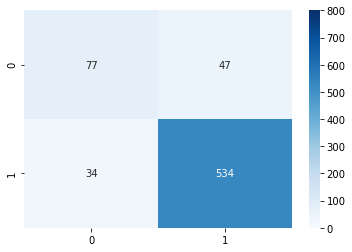

In [27]:
confusion = confusion_matrix(y_test, pred_logreg)
sns.heatmap(confusion, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

In [28]:
print(grid.predict_proba(X_test))

[[0.06774445 0.93225555]
 [0.58220847 0.41779153]
 [0.06506714 0.93493286]
 ...
 [0.5997037  0.4002963 ]
 [0.03605205 0.96394795]
 [0.17522777 0.82477223]]


In [76]:
transformer = grid.best_estimator_.named_steps['columntransformer']

In [78]:
transformer.

['onehotencoder__x0_aidants_connect',
 'onehotencoder__x0_api_droits_cnam',
 'onehotencoder__x0_api_entreprise',
 'onehotencoder__x0_api_ficoba_sandbox',
 'onehotencoder__x0_api_hermes_sandbox',
 'onehotencoder__x0_api_impot_particulier_fc_production',
 'onehotencoder__x0_api_impot_particulier_fc_sandbox',
 'onehotencoder__x0_api_impot_particulier_sandbox',
 'onehotencoder__x0_api_particulier',
 'onehotencoder__x0_api_r2p_sandbox',
 'onehotencoder__x0_cartobio',
 'onehotencoder__x0_franceconnect',
 'onehotencoder__x0_francerelance_fc',
 'onehotencoder__x0_le_taxi_chauffeurs',
 'onehotencoder__x0_le_taxi_clients',
 'onehotencoder__x1_(Autre) Collectivité territoriale',
 'onehotencoder__x1_Association déclarée',
 'onehotencoder__x1_Autre',
 'onehotencoder__x1_Caisse de crédit agricole mutuel',
 "onehotencoder__x1_Centre communal d'action sociale",
 "onehotencoder__x1_Communauté d'agglomération",
 'onehotencoder__x1_Communauté de communes',
 'onehotencoder__x1_Commune et commune nouvelle'

## 2. RandomForest

In [29]:
param_grid = {"randomforestclassifier__n_estimators":[100,200,400],
            "randomforestclassifier__max_depth": [4, 6, 8, 10, 12],
              "randomforestclassifier__max_features": ["auto",0.2],
              "randomforestclassifier__min_samples_split": [10],
              "randomforestclassifier__random_state":[64],
             "randomforestclassifier__class_weight":['balanced',{0:.3,1:.7},{0:.4,1:.6}],
              "columntransformer__tfidfvectorizer-1__min_df":[1,2],
            "columntransformer__tfidfvectorizer-1__max_features":[None,200]
             }

In [30]:
RandomForest = RandomForestClassifier()
feature_select = SelectFromModel(RandomForestClassifier(n_estimators=100))
pipe = make_pipeline(columns_trans, RandomForest)

In [31]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [32]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['target_api',
                                                                          'categorie_juridique_label',
                                                                          'activite_principale_label']),
                                                                        ('tfidfvectorizer-1',
                                                                         TfidfVectorizer(),
                                                                         'nom_raison_sociale'),
                                                                        ('tfidfvectorizer-2',
                                             

In [33]:
pred_rfc = grid.predict(X_test)
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.71      0.52      0.60       124
           1       0.90      0.95      0.93       568

    accuracy                           0.88       692
   macro avg       0.80      0.74      0.76       692
weighted avg       0.87      0.88      0.87       692



In [34]:
print("Accuracy score using Vectorizer: {:.2f}".format(accuracy_score(y_test, pred_rfc)))
print("F1-score using Vectorizer: {:.2f}".format(f1_score(y_test, pred_rfc)))

Accuracy score using Vectorizer: 0.88
F1-score using Vectorizer: 0.93


In [35]:
#print("Accuracy score using number of words: {:.2f}".format(accuracy_score(y_test, pred_rfc)))
#print("F1-score using number of words: {:.2f}".format(f1_score(y_test, pred_rfc)))

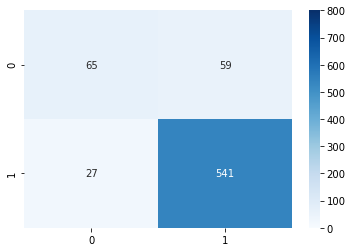

In [36]:
confusion = confusion_matrix(y_test, pred_rfc)
sns.heatmap(confusion, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

In [37]:
print(grid.predict_proba(X_test))

[[0.05751787 0.94248213]
 [0.22238195 0.77761805]
 [0.36573038 0.63426962]
 ...
 [0.63147456 0.36852544]
 [0.03999722 0.96000278]
 [0.35385408 0.64614592]]


## 3. Xgboost

In [38]:
xgboost = XGBClassifier()

In [39]:
param_grid = {
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__eval_metric": ["logloss"],
    "xgbclassifier__eta": [0.05, 0.075, 0.1, 0.3],
    "xgbclassifier__max_depth": [4, 5, 6],
    "xgbclassifier__min_child_weight": [1, 2],
    "xgbclassifier__subsample": [ 0.5, 1.0],
    "columntransformer__tfidfvectorizer-1__min_df":[1,2],
    "columntransformer__tfidfvectorizer-1__max_features":[None,200]
}

In [40]:
pipe = make_pipeline(columns_trans, xgboost)

In [41]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [42]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['target_api',
                                                                          'categorie_juridique_label',
                                                                          'activite_principale_label']),
                                                                        ('tfidfvectorizer-1',
                                                                         TfidfVectorizer(),
                                                                         'nom_raison_sociale'),
                                                                        ('tfidfvectorizer-2',
                                             

In [43]:
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))

Best cross-validation accuracy: 0.86


In [44]:
pred_xgboost = grid.predict(X_test)
print(classification_report(y_test, pred_xgboost))

              precision    recall  f1-score   support

           0       0.71      0.54      0.61       124
           1       0.90      0.95      0.93       568

    accuracy                           0.88       692
   macro avg       0.80      0.75      0.77       692
weighted avg       0.87      0.88      0.87       692



In [45]:
print("Accuracy score using Vectorizer: {:.2f}".format(accuracy_score(y_test, pred_xgboost)))
print("F1-score using Vectorizer: {:.2f}".format(f1_score(y_test, pred_xgboost)))

Accuracy score using Vectorizer: 0.88
F1-score using Vectorizer: 0.93


In [46]:
#print("Accuracy score using number of words: {:.2f}".format(accuracy_score(y_test, pred_xgboost)))
#print("F1-score using number of words: {:.2f}".format(f1_score(y_test, pred_xgboost)))

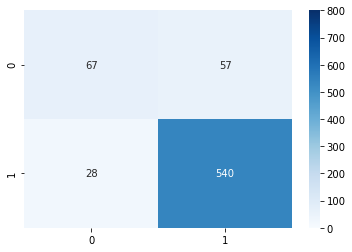

In [47]:
confusion = confusion_matrix(y_test, pred_xgboost)
sns.heatmap(confusion, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

In [48]:
print(grid.predict_proba(X_test))

[[0.07308078 0.9269192 ]
 [0.40167838 0.5983216 ]
 [0.2795717  0.7204283 ]
 ...
 [0.7012352  0.29876482]
 [0.10479975 0.89520025]
 [0.27846575 0.72153425]]


## 4. CatBoost

In [49]:
catboost = CatBoostClassifier()

In [50]:
param_grid = {
    "catboostclassifier__learning_rate": [0.1],
    "catboostclassifier__depth": [6],
    "catboostclassifier__rsm": [0.9],  # random subspace method
    "catboostclassifier__subsample": [1],  # random subspace method
    "catboostclassifier__min_data_in_leaf": [15],
    "columntransformer__tfidfvectorizer-1__min_df":[1,2],
    "columntransformer__tfidfvectorizer-1__max_features":[None,200]
}

In [51]:
pipe = make_pipeline(columns_trans, catboost)

In [52]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [53]:
grid.fit(X_train, y_train)

0:	learn: 0.6342406	total: 66.6ms	remaining: 1m 6s
1:	learn: 0.5707959	total: 83.5ms	remaining: 41.7s
2:	learn: 0.5316723	total: 100ms	remaining: 33.3s
3:	learn: 0.5005772	total: 117ms	remaining: 29.1s
4:	learn: 0.4821635	total: 134ms	remaining: 26.6s
5:	learn: 0.4653344	total: 149ms	remaining: 24.8s
6:	learn: 0.4512663	total: 162ms	remaining: 23s
7:	learn: 0.4362907	total: 195ms	remaining: 24.1s
8:	learn: 0.4253025	total: 211ms	remaining: 23.3s
9:	learn: 0.4129777	total: 225ms	remaining: 22.3s
10:	learn: 0.4038505	total: 239ms	remaining: 21.5s
11:	learn: 0.3968646	total: 272ms	remaining: 22.4s
12:	learn: 0.3918404	total: 293ms	remaining: 22.3s
13:	learn: 0.3864856	total: 310ms	remaining: 21.8s
14:	learn: 0.3805114	total: 323ms	remaining: 21.2s
15:	learn: 0.3744744	total: 335ms	remaining: 20.6s
16:	learn: 0.3705726	total: 347ms	remaining: 20.1s
17:	learn: 0.3643962	total: 359ms	remaining: 19.6s
18:	learn: 0.3607573	total: 372ms	remaining: 19.2s
19:	learn: 0.3547129	total: 384ms	remaini

167:	learn: 0.1889568	total: 2.57s	remaining: 12.7s
168:	learn: 0.1886476	total: 2.58s	remaining: 12.7s
169:	learn: 0.1883449	total: 2.6s	remaining: 12.7s
170:	learn: 0.1870296	total: 2.63s	remaining: 12.7s
171:	learn: 0.1861943	total: 2.65s	remaining: 12.7s
172:	learn: 0.1858930	total: 2.66s	remaining: 12.7s
173:	learn: 0.1853990	total: 2.67s	remaining: 12.7s
174:	learn: 0.1850995	total: 2.69s	remaining: 12.7s
175:	learn: 0.1837112	total: 2.7s	remaining: 12.6s
176:	learn: 0.1834150	total: 2.73s	remaining: 12.7s
177:	learn: 0.1814986	total: 2.75s	remaining: 12.7s
178:	learn: 0.1812083	total: 2.76s	remaining: 12.7s
179:	learn: 0.1803415	total: 2.78s	remaining: 12.7s
180:	learn: 0.1800499	total: 2.81s	remaining: 12.7s
181:	learn: 0.1796064	total: 2.83s	remaining: 12.7s
182:	learn: 0.1793232	total: 2.85s	remaining: 12.7s
183:	learn: 0.1786410	total: 2.86s	remaining: 12.7s
184:	learn: 0.1776606	total: 2.87s	remaining: 12.6s
185:	learn: 0.1764680	total: 2.88s	remaining: 12.6s
186:	learn: 0.

328:	learn: 0.1184271	total: 5.29s	remaining: 10.8s
329:	learn: 0.1179154	total: 5.3s	remaining: 10.8s
330:	learn: 0.1177843	total: 5.34s	remaining: 10.8s
331:	learn: 0.1176552	total: 5.38s	remaining: 10.8s
332:	learn: 0.1174120	total: 5.4s	remaining: 10.8s
333:	learn: 0.1167028	total: 5.41s	remaining: 10.8s
334:	learn: 0.1165716	total: 5.43s	remaining: 10.8s
335:	learn: 0.1157545	total: 5.44s	remaining: 10.7s
336:	learn: 0.1156157	total: 5.45s	remaining: 10.7s
337:	learn: 0.1145438	total: 5.46s	remaining: 10.7s
338:	learn: 0.1144075	total: 5.47s	remaining: 10.7s
339:	learn: 0.1140922	total: 5.49s	remaining: 10.7s
340:	learn: 0.1139614	total: 5.5s	remaining: 10.6s
341:	learn: 0.1131400	total: 5.51s	remaining: 10.6s
342:	learn: 0.1130112	total: 5.53s	remaining: 10.6s
343:	learn: 0.1127766	total: 5.56s	remaining: 10.6s
344:	learn: 0.1126504	total: 5.58s	remaining: 10.6s
345:	learn: 0.1125256	total: 5.59s	remaining: 10.6s
346:	learn: 0.1123255	total: 5.61s	remaining: 10.6s
347:	learn: 0.1

487:	learn: 0.0827778	total: 7.97s	remaining: 8.36s
488:	learn: 0.0827069	total: 7.99s	remaining: 8.35s
489:	learn: 0.0825285	total: 8s	remaining: 8.32s
490:	learn: 0.0824580	total: 8.01s	remaining: 8.3s
491:	learn: 0.0823883	total: 8.02s	remaining: 8.28s
492:	learn: 0.0823188	total: 8.05s	remaining: 8.28s
493:	learn: 0.0822112	total: 8.07s	remaining: 8.27s
494:	learn: 0.0821437	total: 8.09s	remaining: 8.26s
495:	learn: 0.0820767	total: 8.1s	remaining: 8.23s
496:	learn: 0.0819462	total: 8.12s	remaining: 8.21s
497:	learn: 0.0814639	total: 8.13s	remaining: 8.19s
498:	learn: 0.0813972	total: 8.16s	remaining: 8.2s
499:	learn: 0.0813315	total: 8.18s	remaining: 8.18s
500:	learn: 0.0809763	total: 8.2s	remaining: 8.16s
501:	learn: 0.0809102	total: 8.23s	remaining: 8.17s
502:	learn: 0.0805947	total: 8.25s	remaining: 8.15s
503:	learn: 0.0805282	total: 8.26s	remaining: 8.13s
504:	learn: 0.0801107	total: 8.28s	remaining: 8.11s
505:	learn: 0.0800450	total: 8.31s	remaining: 8.11s
506:	learn: 0.07985

652:	learn: 0.0632617	total: 10.5s	remaining: 5.57s
653:	learn: 0.0631884	total: 10.5s	remaining: 5.55s
654:	learn: 0.0630094	total: 10.5s	remaining: 5.53s
655:	learn: 0.0629684	total: 10.5s	remaining: 5.52s
656:	learn: 0.0628888	total: 10.5s	remaining: 5.5s
657:	learn: 0.0628484	total: 10.5s	remaining: 5.48s
658:	learn: 0.0626347	total: 10.6s	remaining: 5.47s
659:	learn: 0.0625635	total: 10.6s	remaining: 5.46s
660:	learn: 0.0625236	total: 10.6s	remaining: 5.44s
661:	learn: 0.0624138	total: 10.6s	remaining: 5.42s
662:	learn: 0.0623743	total: 10.6s	remaining: 5.41s
663:	learn: 0.0622447	total: 10.6s	remaining: 5.39s
664:	learn: 0.0622054	total: 10.7s	remaining: 5.37s
665:	learn: 0.0621231	total: 10.7s	remaining: 5.35s
666:	learn: 0.0620835	total: 10.7s	remaining: 5.33s
667:	learn: 0.0620145	total: 10.7s	remaining: 5.32s
668:	learn: 0.0619759	total: 10.7s	remaining: 5.3s
669:	learn: 0.0619376	total: 10.7s	remaining: 5.29s
670:	learn: 0.0618989	total: 10.8s	remaining: 5.28s
671:	learn: 0.

824:	learn: 0.0507993	total: 13.2s	remaining: 2.8s
825:	learn: 0.0507732	total: 13.2s	remaining: 2.78s
826:	learn: 0.0506731	total: 13.2s	remaining: 2.77s
827:	learn: 0.0506471	total: 13.2s	remaining: 2.75s
828:	learn: 0.0506040	total: 13.2s	remaining: 2.73s
829:	learn: 0.0505076	total: 13.3s	remaining: 2.71s
830:	learn: 0.0502260	total: 13.3s	remaining: 2.7s
831:	learn: 0.0502001	total: 13.3s	remaining: 2.68s
832:	learn: 0.0501745	total: 13.3s	remaining: 2.67s
833:	learn: 0.0499996	total: 13.3s	remaining: 2.65s
834:	learn: 0.0499309	total: 13.3s	remaining: 2.64s
835:	learn: 0.0499049	total: 13.4s	remaining: 2.62s
836:	learn: 0.0498796	total: 13.4s	remaining: 2.6s
837:	learn: 0.0498541	total: 13.4s	remaining: 2.59s
838:	learn: 0.0496966	total: 13.4s	remaining: 2.57s
839:	learn: 0.0496534	total: 13.4s	remaining: 2.55s
840:	learn: 0.0496282	total: 13.4s	remaining: 2.54s
841:	learn: 0.0496030	total: 13.5s	remaining: 2.52s
842:	learn: 0.0494915	total: 13.5s	remaining: 2.51s
843:	learn: 0.0

985:	learn: 0.0428873	total: 15.9s	remaining: 226ms
986:	learn: 0.0428696	total: 15.9s	remaining: 210ms
987:	learn: 0.0427569	total: 16s	remaining: 194ms
988:	learn: 0.0427240	total: 16s	remaining: 178ms
989:	learn: 0.0426665	total: 16s	remaining: 162ms
990:	learn: 0.0426488	total: 16s	remaining: 145ms
991:	learn: 0.0426313	total: 16s	remaining: 129ms
992:	learn: 0.0425836	total: 16s	remaining: 113ms
993:	learn: 0.0425662	total: 16s	remaining: 96.9ms
994:	learn: 0.0425361	total: 16.1s	remaining: 80.7ms
995:	learn: 0.0425188	total: 16.1s	remaining: 64.5ms
996:	learn: 0.0423155	total: 16.1s	remaining: 48.5ms
997:	learn: 0.0422799	total: 16.1s	remaining: 32.3ms
998:	learn: 0.0422621	total: 16.1s	remaining: 16.2ms
999:	learn: 0.0422447	total: 16.1s	remaining: 0us
0:	learn: 0.6225859	total: 12.8ms	remaining: 12.8s
1:	learn: 0.5753871	total: 25.4ms	remaining: 12.7s
2:	learn: 0.5393759	total: 38ms	remaining: 12.6s
3:	learn: 0.5148164	total: 50.5ms	remaining: 12.6s
4:	learn: 0.4953840	total: 6

148:	learn: 0.1898280	total: 2.54s	remaining: 14.5s
149:	learn: 0.1894618	total: 2.56s	remaining: 14.5s
150:	learn: 0.1888959	total: 2.57s	remaining: 14.5s
151:	learn: 0.1869858	total: 2.58s	remaining: 14.4s
152:	learn: 0.1860834	total: 2.6s	remaining: 14.4s
153:	learn: 0.1857255	total: 2.61s	remaining: 14.3s
154:	learn: 0.1851902	total: 2.62s	remaining: 14.3s
155:	learn: 0.1845183	total: 2.64s	remaining: 14.3s
156:	learn: 0.1841668	total: 2.67s	remaining: 14.3s
157:	learn: 0.1825517	total: 2.69s	remaining: 14.3s
158:	learn: 0.1822048	total: 2.7s	remaining: 14.3s
159:	learn: 0.1810097	total: 2.71s	remaining: 14.3s
160:	learn: 0.1806771	total: 2.75s	remaining: 14.3s
161:	learn: 0.1803458	total: 2.77s	remaining: 14.3s
162:	learn: 0.1800258	total: 2.78s	remaining: 14.3s
163:	learn: 0.1794802	total: 2.81s	remaining: 14.4s
164:	learn: 0.1782430	total: 2.83s	remaining: 14.3s
165:	learn: 0.1779203	total: 2.85s	remaining: 14.3s
166:	learn: 0.1776020	total: 2.86s	remaining: 14.3s
167:	learn: 0.

312:	learn: 0.1118132	total: 5.43s	remaining: 11.9s
313:	learn: 0.1116757	total: 5.45s	remaining: 11.9s
314:	learn: 0.1115402	total: 5.47s	remaining: 11.9s
315:	learn: 0.1110172	total: 5.48s	remaining: 11.9s
316:	learn: 0.1107933	total: 5.49s	remaining: 11.8s
317:	learn: 0.1101962	total: 5.51s	remaining: 11.8s
318:	learn: 0.1100607	total: 5.52s	remaining: 11.8s
319:	learn: 0.1093875	total: 5.53s	remaining: 11.8s
320:	learn: 0.1091684	total: 5.54s	remaining: 11.7s
321:	learn: 0.1090377	total: 5.55s	remaining: 11.7s
322:	learn: 0.1087645	total: 5.59s	remaining: 11.7s
323:	learn: 0.1086347	total: 5.61s	remaining: 11.7s
324:	learn: 0.1085037	total: 5.64s	remaining: 11.7s
325:	learn: 0.1083774	total: 5.67s	remaining: 11.7s
326:	learn: 0.1082476	total: 5.68s	remaining: 11.7s
327:	learn: 0.1081232	total: 5.7s	remaining: 11.7s
328:	learn: 0.1075766	total: 5.71s	remaining: 11.6s
329:	learn: 0.1071988	total: 5.74s	remaining: 11.7s
330:	learn: 0.1070728	total: 5.76s	remaining: 11.6s
331:	learn: 0

473:	learn: 0.0742544	total: 7.96s	remaining: 8.83s
474:	learn: 0.0741894	total: 7.98s	remaining: 8.82s
475:	learn: 0.0741264	total: 8.01s	remaining: 8.82s
476:	learn: 0.0738496	total: 8.03s	remaining: 8.8s
477:	learn: 0.0737472	total: 8.04s	remaining: 8.79s
478:	learn: 0.0733363	total: 8.06s	remaining: 8.76s
479:	learn: 0.0729750	total: 8.07s	remaining: 8.74s
480:	learn: 0.0727944	total: 8.08s	remaining: 8.72s
481:	learn: 0.0727302	total: 8.09s	remaining: 8.7s
482:	learn: 0.0726187	total: 8.11s	remaining: 8.68s
483:	learn: 0.0725554	total: 8.14s	remaining: 8.68s
484:	learn: 0.0724327	total: 8.16s	remaining: 8.67s
485:	learn: 0.0723695	total: 8.18s	remaining: 8.65s
486:	learn: 0.0723073	total: 8.19s	remaining: 8.63s
487:	learn: 0.0722459	total: 8.2s	remaining: 8.61s
488:	learn: 0.0719005	total: 8.21s	remaining: 8.58s
489:	learn: 0.0718392	total: 8.23s	remaining: 8.56s
490:	learn: 0.0717360	total: 8.24s	remaining: 8.54s
491:	learn: 0.0714809	total: 8.28s	remaining: 8.55s
492:	learn: 0.0

635:	learn: 0.0555048	total: 10.6s	remaining: 6.08s
636:	learn: 0.0554393	total: 10.6s	remaining: 6.06s
637:	learn: 0.0554027	total: 10.6s	remaining: 6.04s
638:	learn: 0.0550698	total: 10.7s	remaining: 6.02s
639:	learn: 0.0549998	total: 10.7s	remaining: 6s
640:	learn: 0.0549630	total: 10.7s	remaining: 5.99s
641:	learn: 0.0548988	total: 10.7s	remaining: 5.97s
642:	learn: 0.0548625	total: 10.7s	remaining: 5.95s
643:	learn: 0.0548265	total: 10.7s	remaining: 5.93s
644:	learn: 0.0547909	total: 10.7s	remaining: 5.91s
645:	learn: 0.0545620	total: 10.8s	remaining: 5.89s
646:	learn: 0.0545025	total: 10.8s	remaining: 5.87s
647:	learn: 0.0544677	total: 10.8s	remaining: 5.85s
648:	learn: 0.0542223	total: 10.8s	remaining: 5.83s
649:	learn: 0.0541870	total: 10.8s	remaining: 5.83s
650:	learn: 0.0540180	total: 10.8s	remaining: 5.81s
651:	learn: 0.0538668	total: 10.9s	remaining: 5.79s
652:	learn: 0.0538316	total: 10.9s	remaining: 5.78s
653:	learn: 0.0537971	total: 10.9s	remaining: 5.76s
654:	learn: 0.0

803:	learn: 0.0435126	total: 13.3s	remaining: 3.24s
804:	learn: 0.0434904	total: 13.3s	remaining: 3.23s
805:	learn: 0.0434147	total: 13.3s	remaining: 3.21s
806:	learn: 0.0433740	total: 13.3s	remaining: 3.19s
807:	learn: 0.0433522	total: 13.4s	remaining: 3.17s
808:	learn: 0.0433073	total: 13.4s	remaining: 3.16s
809:	learn: 0.0432847	total: 13.4s	remaining: 3.14s
810:	learn: 0.0432631	total: 13.4s	remaining: 3.13s
811:	learn: 0.0432416	total: 13.4s	remaining: 3.11s
812:	learn: 0.0431991	total: 13.5s	remaining: 3.1s
813:	learn: 0.0431776	total: 13.5s	remaining: 3.08s
814:	learn: 0.0431390	total: 13.5s	remaining: 3.06s
815:	learn: 0.0431177	total: 13.5s	remaining: 3.05s
816:	learn: 0.0430525	total: 13.5s	remaining: 3.03s
817:	learn: 0.0430315	total: 13.5s	remaining: 3.01s
818:	learn: 0.0429113	total: 13.6s	remaining: 3s
819:	learn: 0.0428108	total: 13.6s	remaining: 2.98s
820:	learn: 0.0427896	total: 13.6s	remaining: 2.97s
821:	learn: 0.0426379	total: 13.6s	remaining: 2.95s
822:	learn: 0.04

974:	learn: 0.0362285	total: 16s	remaining: 411ms
975:	learn: 0.0362138	total: 16s	remaining: 395ms
976:	learn: 0.0361993	total: 16.1s	remaining: 378ms
977:	learn: 0.0361722	total: 16.1s	remaining: 362ms
978:	learn: 0.0361133	total: 16.1s	remaining: 346ms
979:	learn: 0.0360989	total: 16.1s	remaining: 330ms
980:	learn: 0.0359639	total: 16.2s	remaining: 313ms
981:	learn: 0.0359198	total: 16.2s	remaining: 297ms
982:	learn: 0.0359046	total: 16.2s	remaining: 280ms
983:	learn: 0.0358902	total: 16.2s	remaining: 263ms
984:	learn: 0.0358571	total: 16.2s	remaining: 247ms
985:	learn: 0.0358428	total: 16.2s	remaining: 230ms
986:	learn: 0.0358285	total: 16.2s	remaining: 214ms
987:	learn: 0.0358145	total: 16.3s	remaining: 197ms
988:	learn: 0.0358004	total: 16.3s	remaining: 181ms
989:	learn: 0.0357759	total: 16.3s	remaining: 164ms
990:	learn: 0.0357620	total: 16.3s	remaining: 148ms
991:	learn: 0.0356969	total: 16.3s	remaining: 132ms
992:	learn: 0.0356713	total: 16.3s	remaining: 115ms
993:	learn: 0.03

141:	learn: 0.2081670	total: 2.31s	remaining: 13.9s
142:	learn: 0.2077657	total: 2.33s	remaining: 13.9s
143:	learn: 0.2073729	total: 2.34s	remaining: 13.9s
144:	learn: 0.2059884	total: 2.35s	remaining: 13.9s
145:	learn: 0.2038260	total: 2.36s	remaining: 13.8s
146:	learn: 0.2034306	total: 2.4s	remaining: 13.9s
147:	learn: 0.2030481	total: 2.41s	remaining: 13.9s
148:	learn: 0.2017861	total: 2.43s	remaining: 13.9s
149:	learn: 0.2011902	total: 2.44s	remaining: 13.8s
150:	learn: 0.2008132	total: 2.45s	remaining: 13.8s
151:	learn: 0.2004439	total: 2.46s	remaining: 13.7s
152:	learn: 0.1997306	total: 2.47s	remaining: 13.7s
153:	learn: 0.1986946	total: 2.49s	remaining: 13.7s
154:	learn: 0.1983292	total: 2.5s	remaining: 13.6s
155:	learn: 0.1979723	total: 2.51s	remaining: 13.6s
156:	learn: 0.1976196	total: 2.52s	remaining: 13.6s
157:	learn: 0.1971161	total: 2.54s	remaining: 13.5s
158:	learn: 0.1967703	total: 2.55s	remaining: 13.5s
159:	learn: 0.1960606	total: 2.56s	remaining: 13.5s
160:	learn: 0.

303:	learn: 0.1242949	total: 4.79s	remaining: 11s
304:	learn: 0.1235783	total: 4.8s	remaining: 10.9s
305:	learn: 0.1234189	total: 4.83s	remaining: 11s
306:	learn: 0.1230571	total: 4.85s	remaining: 11s
307:	learn: 0.1229024	total: 4.87s	remaining: 10.9s
308:	learn: 0.1226523	total: 4.88s	remaining: 10.9s
309:	learn: 0.1225030	total: 4.91s	remaining: 10.9s
310:	learn: 0.1221640	total: 4.93s	remaining: 10.9s
311:	learn: 0.1220161	total: 4.95s	remaining: 10.9s
312:	learn: 0.1218698	total: 4.96s	remaining: 10.9s
313:	learn: 0.1214662	total: 4.97s	remaining: 10.9s
314:	learn: 0.1213188	total: 4.98s	remaining: 10.8s
315:	learn: 0.1208250	total: 5s	remaining: 10.8s
316:	learn: 0.1206787	total: 5.03s	remaining: 10.8s
317:	learn: 0.1205336	total: 5.05s	remaining: 10.8s
318:	learn: 0.1198980	total: 5.07s	remaining: 10.8s
319:	learn: 0.1190779	total: 5.08s	remaining: 10.8s
320:	learn: 0.1187542	total: 5.09s	remaining: 10.8s
321:	learn: 0.1186105	total: 5.1s	remaining: 10.7s
322:	learn: 0.1183742	t

467:	learn: 0.0850097	total: 7.46s	remaining: 8.48s
468:	learn: 0.0849333	total: 7.47s	remaining: 8.46s
469:	learn: 0.0848201	total: 7.49s	remaining: 8.45s
470:	learn: 0.0843551	total: 7.5s	remaining: 8.43s
471:	learn: 0.0840460	total: 7.51s	remaining: 8.4s
472:	learn: 0.0839702	total: 7.53s	remaining: 8.38s
473:	learn: 0.0838950	total: 7.56s	remaining: 8.39s
474:	learn: 0.0838204	total: 7.58s	remaining: 8.37s
475:	learn: 0.0836908	total: 7.61s	remaining: 8.38s
476:	learn: 0.0834368	total: 7.63s	remaining: 8.37s
477:	learn: 0.0833625	total: 7.65s	remaining: 8.35s
478:	learn: 0.0831916	total: 7.66s	remaining: 8.33s
479:	learn: 0.0826806	total: 7.67s	remaining: 8.31s
480:	learn: 0.0825155	total: 7.69s	remaining: 8.29s
481:	learn: 0.0824403	total: 7.7s	remaining: 8.27s
482:	learn: 0.0823653	total: 7.71s	remaining: 8.25s
483:	learn: 0.0822908	total: 7.72s	remaining: 8.23s
484:	learn: 0.0822169	total: 7.74s	remaining: 8.21s
485:	learn: 0.0821436	total: 7.75s	remaining: 8.2s
486:	learn: 0.08

637:	learn: 0.0624748	total: 10.2s	remaining: 5.77s
638:	learn: 0.0624292	total: 10.2s	remaining: 5.75s
639:	learn: 0.0623840	total: 10.2s	remaining: 5.74s
640:	learn: 0.0623392	total: 10.2s	remaining: 5.72s
641:	learn: 0.0622954	total: 10.2s	remaining: 5.7s
642:	learn: 0.0621518	total: 10.2s	remaining: 5.68s
643:	learn: 0.0621083	total: 10.2s	remaining: 5.66s
644:	learn: 0.0620301	total: 10.3s	remaining: 5.66s
645:	learn: 0.0617925	total: 10.3s	remaining: 5.64s
646:	learn: 0.0617485	total: 10.3s	remaining: 5.63s
647:	learn: 0.0617051	total: 10.3s	remaining: 5.62s
648:	learn: 0.0614314	total: 10.4s	remaining: 5.61s
649:	learn: 0.0613871	total: 10.4s	remaining: 5.6s
650:	learn: 0.0611394	total: 10.4s	remaining: 5.59s
651:	learn: 0.0610945	total: 10.4s	remaining: 5.57s
652:	learn: 0.0610179	total: 10.4s	remaining: 5.55s
653:	learn: 0.0609741	total: 10.5s	remaining: 5.54s
654:	learn: 0.0609307	total: 10.5s	remaining: 5.53s
655:	learn: 0.0608884	total: 10.5s	remaining: 5.51s
656:	learn: 0.

803:	learn: 0.0491741	total: 12.9s	remaining: 3.14s
804:	learn: 0.0491193	total: 12.9s	remaining: 3.13s
805:	learn: 0.0490461	total: 12.9s	remaining: 3.11s
806:	learn: 0.0490175	total: 12.9s	remaining: 3.09s
807:	learn: 0.0489891	total: 12.9s	remaining: 3.08s
808:	learn: 0.0489388	total: 13s	remaining: 3.06s
809:	learn: 0.0488765	total: 13s	remaining: 3.04s
810:	learn: 0.0488482	total: 13s	remaining: 3.02s
811:	learn: 0.0488201	total: 13s	remaining: 3.01s
812:	learn: 0.0487922	total: 13s	remaining: 3s
813:	learn: 0.0487649	total: 13.1s	remaining: 2.99s
814:	learn: 0.0487256	total: 13.1s	remaining: 2.97s
815:	learn: 0.0485623	total: 13.1s	remaining: 2.96s
816:	learn: 0.0485348	total: 13.1s	remaining: 2.94s
817:	learn: 0.0484866	total: 13.1s	remaining: 2.92s
818:	learn: 0.0482612	total: 13.1s	remaining: 2.9s
819:	learn: 0.0481008	total: 13.2s	remaining: 2.89s
820:	learn: 0.0480731	total: 13.2s	remaining: 2.88s
821:	learn: 0.0480456	total: 13.2s	remaining: 2.86s
822:	learn: 0.0479765	tota

967:	learn: 0.0402176	total: 15.6s	remaining: 517ms
968:	learn: 0.0401984	total: 15.7s	remaining: 501ms
969:	learn: 0.0401795	total: 15.7s	remaining: 485ms
970:	learn: 0.0399674	total: 15.7s	remaining: 468ms
971:	learn: 0.0399483	total: 15.7s	remaining: 452ms
972:	learn: 0.0398694	total: 15.7s	remaining: 437ms
973:	learn: 0.0398228	total: 15.8s	remaining: 420ms
974:	learn: 0.0396343	total: 15.8s	remaining: 405ms
975:	learn: 0.0396006	total: 15.8s	remaining: 389ms
976:	learn: 0.0395817	total: 15.8s	remaining: 373ms
977:	learn: 0.0395629	total: 15.9s	remaining: 357ms
978:	learn: 0.0395442	total: 15.9s	remaining: 341ms
979:	learn: 0.0395257	total: 15.9s	remaining: 324ms
980:	learn: 0.0395073	total: 15.9s	remaining: 308ms
981:	learn: 0.0394889	total: 15.9s	remaining: 292ms
982:	learn: 0.0394707	total: 15.9s	remaining: 275ms
983:	learn: 0.0394260	total: 15.9s	remaining: 259ms
984:	learn: 0.0394075	total: 16s	remaining: 243ms
985:	learn: 0.0392307	total: 16s	remaining: 227ms
986:	learn: 0.03

135:	learn: 0.2084298	total: 2.29s	remaining: 14.5s
136:	learn: 0.2053135	total: 2.3s	remaining: 14.5s
137:	learn: 0.2032722	total: 2.32s	remaining: 14.5s
138:	learn: 0.2026574	total: 2.33s	remaining: 14.4s
139:	learn: 0.2022555	total: 2.37s	remaining: 14.5s
140:	learn: 0.2014065	total: 2.38s	remaining: 14.5s
141:	learn: 0.2010140	total: 2.4s	remaining: 14.5s
142:	learn: 0.2006276	total: 2.41s	remaining: 14.4s
143:	learn: 0.1986115	total: 2.42s	remaining: 14.4s
144:	learn: 0.1982267	total: 2.43s	remaining: 14.3s
145:	learn: 0.1976250	total: 2.44s	remaining: 14.3s
146:	learn: 0.1972517	total: 2.46s	remaining: 14.3s
147:	learn: 0.1964384	total: 2.47s	remaining: 14.2s
148:	learn: 0.1948242	total: 2.48s	remaining: 14.2s
149:	learn: 0.1944627	total: 2.49s	remaining: 14.1s
150:	learn: 0.1927615	total: 2.51s	remaining: 14.1s
151:	learn: 0.1920750	total: 2.54s	remaining: 14.2s
152:	learn: 0.1917183	total: 2.56s	remaining: 14.2s
153:	learn: 0.1913657	total: 2.57s	remaining: 14.1s
154:	learn: 0.

297:	learn: 0.1215823	total: 5.04s	remaining: 11.9s
298:	learn: 0.1214315	total: 5.05s	remaining: 11.8s
299:	learn: 0.1207539	total: 5.08s	remaining: 11.9s
300:	learn: 0.1205033	total: 5.1s	remaining: 11.9s
301:	learn: 0.1203539	total: 5.12s	remaining: 11.8s
302:	learn: 0.1202096	total: 5.15s	remaining: 11.9s
303:	learn: 0.1200514	total: 5.17s	remaining: 11.8s
304:	learn: 0.1197296	total: 5.18s	remaining: 11.8s
305:	learn: 0.1195853	total: 5.2s	remaining: 11.8s
306:	learn: 0.1194452	total: 5.21s	remaining: 11.8s
307:	learn: 0.1188721	total: 5.22s	remaining: 11.7s
308:	learn: 0.1180419	total: 5.23s	remaining: 11.7s
309:	learn: 0.1174727	total: 5.25s	remaining: 11.7s
310:	learn: 0.1172337	total: 5.26s	remaining: 11.7s
311:	learn: 0.1170904	total: 5.27s	remaining: 11.6s
312:	learn: 0.1167640	total: 5.31s	remaining: 11.7s
313:	learn: 0.1166265	total: 5.33s	remaining: 11.6s
314:	learn: 0.1163102	total: 5.34s	remaining: 11.6s
315:	learn: 0.1149809	total: 5.36s	remaining: 11.6s
316:	learn: 0.

463:	learn: 0.0813361	total: 7.92s	remaining: 9.15s
464:	learn: 0.0809977	total: 7.93s	remaining: 9.13s
465:	learn: 0.0805653	total: 7.95s	remaining: 9.11s
466:	learn: 0.0804401	total: 7.96s	remaining: 9.08s
467:	learn: 0.0803676	total: 7.97s	remaining: 9.06s
468:	learn: 0.0799947	total: 7.98s	remaining: 9.04s
469:	learn: 0.0799223	total: 8.02s	remaining: 9.04s
470:	learn: 0.0798339	total: 8.04s	remaining: 9.03s
471:	learn: 0.0797600	total: 8.05s	remaining: 9.01s
472:	learn: 0.0796002	total: 8.09s	remaining: 9.01s
473:	learn: 0.0794768	total: 8.11s	remaining: 9s
474:	learn: 0.0794073	total: 8.13s	remaining: 8.98s
475:	learn: 0.0792617	total: 8.16s	remaining: 8.99s
476:	learn: 0.0791540	total: 8.18s	remaining: 8.97s
477:	learn: 0.0790852	total: 8.2s	remaining: 8.95s
478:	learn: 0.0789555	total: 8.23s	remaining: 8.96s
479:	learn: 0.0788465	total: 8.25s	remaining: 8.94s
480:	learn: 0.0785802	total: 8.27s	remaining: 8.92s
481:	learn: 0.0785117	total: 8.28s	remaining: 8.9s
482:	learn: 0.078

632:	learn: 0.0596304	total: 11.1s	remaining: 6.44s
633:	learn: 0.0595900	total: 11.1s	remaining: 6.42s
634:	learn: 0.0595186	total: 11.1s	remaining: 6.4s
635:	learn: 0.0593094	total: 11.2s	remaining: 6.39s
636:	learn: 0.0590814	total: 11.2s	remaining: 6.37s
637:	learn: 0.0590411	total: 11.2s	remaining: 6.35s
638:	learn: 0.0589656	total: 11.2s	remaining: 6.35s
639:	learn: 0.0589261	total: 11.3s	remaining: 6.33s
640:	learn: 0.0588872	total: 11.3s	remaining: 6.32s
641:	learn: 0.0587139	total: 11.3s	remaining: 6.3s
642:	learn: 0.0586747	total: 11.3s	remaining: 6.29s
643:	learn: 0.0583570	total: 11.3s	remaining: 6.27s
644:	learn: 0.0583177	total: 11.3s	remaining: 6.25s
645:	learn: 0.0582681	total: 11.4s	remaining: 6.24s
646:	learn: 0.0582279	total: 11.4s	remaining: 6.22s
647:	learn: 0.0581896	total: 11.4s	remaining: 6.2s
648:	learn: 0.0579419	total: 11.4s	remaining: 6.18s
649:	learn: 0.0578717	total: 11.4s	remaining: 6.16s
650:	learn: 0.0578329	total: 11.5s	remaining: 6.15s
651:	learn: 0.0

800:	learn: 0.0470741	total: 14.3s	remaining: 3.55s
801:	learn: 0.0470490	total: 14.3s	remaining: 3.53s
802:	learn: 0.0470242	total: 14.3s	remaining: 3.51s
803:	learn: 0.0469613	total: 14.3s	remaining: 3.5s
804:	learn: 0.0469368	total: 14.4s	remaining: 3.48s
805:	learn: 0.0467078	total: 14.4s	remaining: 3.46s
806:	learn: 0.0466701	total: 14.4s	remaining: 3.44s
807:	learn: 0.0466447	total: 14.4s	remaining: 3.43s
808:	learn: 0.0466199	total: 14.4s	remaining: 3.41s
809:	learn: 0.0465776	total: 14.5s	remaining: 3.39s
810:	learn: 0.0465530	total: 14.5s	remaining: 3.38s
811:	learn: 0.0465289	total: 14.5s	remaining: 3.36s
812:	learn: 0.0464895	total: 14.5s	remaining: 3.34s
813:	learn: 0.0463732	total: 14.5s	remaining: 3.32s
814:	learn: 0.0462007	total: 14.5s	remaining: 3.3s
815:	learn: 0.0461765	total: 14.6s	remaining: 3.28s
816:	learn: 0.0461527	total: 14.6s	remaining: 3.27s
817:	learn: 0.0461096	total: 14.6s	remaining: 3.25s
818:	learn: 0.0460687	total: 14.6s	remaining: 3.23s
819:	learn: 0.

967:	learn: 0.0391662	total: 17.2s	remaining: 569ms
968:	learn: 0.0391498	total: 17.2s	remaining: 551ms
969:	learn: 0.0390342	total: 17.3s	remaining: 534ms
970:	learn: 0.0389914	total: 17.3s	remaining: 516ms
971:	learn: 0.0389748	total: 17.3s	remaining: 498ms
972:	learn: 0.0389132	total: 17.3s	remaining: 480ms
973:	learn: 0.0388835	total: 17.3s	remaining: 462ms
974:	learn: 0.0388673	total: 17.3s	remaining: 444ms
975:	learn: 0.0388511	total: 17.3s	remaining: 426ms
976:	learn: 0.0387231	total: 17.4s	remaining: 408ms
977:	learn: 0.0386002	total: 17.4s	remaining: 391ms
978:	learn: 0.0385838	total: 17.4s	remaining: 373ms
979:	learn: 0.0385677	total: 17.4s	remaining: 355ms
980:	learn: 0.0385397	total: 17.4s	remaining: 338ms
981:	learn: 0.0385234	total: 17.4s	remaining: 320ms
982:	learn: 0.0384371	total: 17.5s	remaining: 302ms
983:	learn: 0.0384071	total: 17.5s	remaining: 284ms
984:	learn: 0.0383913	total: 17.5s	remaining: 266ms
985:	learn: 0.0383258	total: 17.5s	remaining: 248ms
986:	learn: 

136:	learn: 0.2065264	total: 2.6s	remaining: 16.4s
137:	learn: 0.2059315	total: 2.62s	remaining: 16.4s
138:	learn: 0.2055165	total: 2.64s	remaining: 16.3s
139:	learn: 0.2045737	total: 2.67s	remaining: 16.4s
140:	learn: 0.2029087	total: 2.69s	remaining: 16.4s
141:	learn: 0.2025043	total: 2.7s	remaining: 16.3s
142:	learn: 0.2021065	total: 2.72s	remaining: 16.3s
143:	learn: 0.2009586	total: 2.73s	remaining: 16.2s
144:	learn: 0.2005700	total: 2.74s	remaining: 16.2s
145:	learn: 0.1997201	total: 2.75s	remaining: 16.1s
146:	learn: 0.1993379	total: 2.77s	remaining: 16.1s
147:	learn: 0.1989612	total: 2.78s	remaining: 16s
148:	learn: 0.1971739	total: 2.79s	remaining: 15.9s
149:	learn: 0.1966040	total: 2.8s	remaining: 15.9s
150:	learn: 0.1962298	total: 2.82s	remaining: 15.8s
151:	learn: 0.1958624	total: 2.83s	remaining: 15.8s
152:	learn: 0.1944974	total: 2.84s	remaining: 15.7s
153:	learn: 0.1931183	total: 2.85s	remaining: 15.7s
154:	learn: 0.1927546	total: 2.87s	remaining: 15.6s
155:	learn: 0.191

303:	learn: 0.1202170	total: 5.3s	remaining: 12.1s
304:	learn: 0.1200693	total: 5.34s	remaining: 12.2s
305:	learn: 0.1193682	total: 5.36s	remaining: 12.2s
306:	learn: 0.1192168	total: 5.37s	remaining: 12.1s
307:	learn: 0.1190716	total: 5.38s	remaining: 12.1s
308:	learn: 0.1189286	total: 5.4s	remaining: 12.1s
309:	learn: 0.1186625	total: 5.41s	remaining: 12s
310:	learn: 0.1183187	total: 5.42s	remaining: 12s
311:	learn: 0.1181770	total: 5.43s	remaining: 12s
312:	learn: 0.1172176	total: 5.45s	remaining: 12s
313:	learn: 0.1169773	total: 5.48s	remaining: 12s
314:	learn: 0.1161415	total: 5.5s	remaining: 12s
315:	learn: 0.1159099	total: 5.54s	remaining: 12s
316:	learn: 0.1157676	total: 5.55s	remaining: 12s
317:	learn: 0.1154391	total: 5.57s	remaining: 11.9s
318:	learn: 0.1152991	total: 5.58s	remaining: 11.9s
319:	learn: 0.1150755	total: 5.59s	remaining: 11.9s
320:	learn: 0.1149376	total: 5.62s	remaining: 11.9s
321:	learn: 0.1146546	total: 5.64s	remaining: 11.9s
322:	learn: 0.1145179	total: 5.

466:	learn: 0.0798990	total: 8.03s	remaining: 9.16s
467:	learn: 0.0798285	total: 8.04s	remaining: 9.14s
468:	learn: 0.0794917	total: 8.07s	remaining: 9.14s
469:	learn: 0.0793595	total: 8.09s	remaining: 9.13s
470:	learn: 0.0788564	total: 8.11s	remaining: 9.11s
471:	learn: 0.0787851	total: 8.12s	remaining: 9.09s
472:	learn: 0.0782190	total: 8.16s	remaining: 9.09s
473:	learn: 0.0781016	total: 8.18s	remaining: 9.07s
474:	learn: 0.0780297	total: 8.19s	remaining: 9.05s
475:	learn: 0.0779109	total: 8.2s	remaining: 9.03s
476:	learn: 0.0778406	total: 8.22s	remaining: 9.01s
477:	learn: 0.0774307	total: 8.23s	remaining: 8.99s
478:	learn: 0.0771128	total: 8.26s	remaining: 8.99s
479:	learn: 0.0769949	total: 8.28s	remaining: 8.97s
480:	learn: 0.0769261	total: 8.3s	remaining: 8.95s
481:	learn: 0.0766981	total: 8.33s	remaining: 8.96s
482:	learn: 0.0766304	total: 8.35s	remaining: 8.94s
483:	learn: 0.0765636	total: 8.37s	remaining: 8.92s
484:	learn: 0.0764961	total: 8.4s	remaining: 8.92s
485:	learn: 0.0

631:	learn: 0.0591532	total: 10.7s	remaining: 6.23s
632:	learn: 0.0588470	total: 10.7s	remaining: 6.21s
633:	learn: 0.0588069	total: 10.7s	remaining: 6.19s
634:	learn: 0.0587666	total: 10.7s	remaining: 6.17s
635:	learn: 0.0587278	total: 10.8s	remaining: 6.16s
636:	learn: 0.0586581	total: 10.8s	remaining: 6.15s
637:	learn: 0.0584700	total: 10.8s	remaining: 6.13s
638:	learn: 0.0584309	total: 10.8s	remaining: 6.13s
639:	learn: 0.0583345	total: 10.9s	remaining: 6.11s
640:	learn: 0.0582961	total: 10.9s	remaining: 6.09s
641:	learn: 0.0582273	total: 10.9s	remaining: 6.07s
642:	learn: 0.0581053	total: 10.9s	remaining: 6.05s
643:	learn: 0.0580665	total: 10.9s	remaining: 6.03s
644:	learn: 0.0580286	total: 10.9s	remaining: 6.01s
645:	learn: 0.0579902	total: 10.9s	remaining: 6s
646:	learn: 0.0578706	total: 11s	remaining: 5.99s
647:	learn: 0.0578326	total: 11s	remaining: 5.97s
648:	learn: 0.0575750	total: 11s	remaining: 5.95s
649:	learn: 0.0575369	total: 11s	remaining: 5.93s
650:	learn: 0.0574634	t

794:	learn: 0.0468620	total: 13.4s	remaining: 3.46s
795:	learn: 0.0465923	total: 13.4s	remaining: 3.45s
796:	learn: 0.0465591	total: 13.5s	remaining: 3.43s
797:	learn: 0.0463950	total: 13.5s	remaining: 3.41s
798:	learn: 0.0463692	total: 13.5s	remaining: 3.4s
799:	learn: 0.0463443	total: 13.5s	remaining: 3.38s
800:	learn: 0.0462736	total: 13.6s	remaining: 3.37s
801:	learn: 0.0461571	total: 13.6s	remaining: 3.35s
802:	learn: 0.0461323	total: 13.6s	remaining: 3.33s
803:	learn: 0.0460873	total: 13.6s	remaining: 3.31s
804:	learn: 0.0460395	total: 13.6s	remaining: 3.29s
805:	learn: 0.0460151	total: 13.6s	remaining: 3.28s
806:	learn: 0.0459624	total: 13.6s	remaining: 3.26s
807:	learn: 0.0459380	total: 13.6s	remaining: 3.24s
808:	learn: 0.0459069	total: 13.7s	remaining: 3.22s
809:	learn: 0.0458829	total: 13.7s	remaining: 3.21s
810:	learn: 0.0458592	total: 13.7s	remaining: 3.19s
811:	learn: 0.0457586	total: 13.7s	remaining: 3.18s
812:	learn: 0.0456739	total: 13.8s	remaining: 3.16s
813:	learn: 0

953:	learn: 0.0383019	total: 15.9s	remaining: 769ms
954:	learn: 0.0382849	total: 16s	remaining: 752ms
955:	learn: 0.0381643	total: 16s	remaining: 736ms
956:	learn: 0.0381472	total: 16s	remaining: 719ms
957:	learn: 0.0381180	total: 16s	remaining: 703ms
958:	learn: 0.0381013	total: 16.1s	remaining: 686ms
959:	learn: 0.0380478	total: 16.1s	remaining: 669ms
960:	learn: 0.0380313	total: 16.1s	remaining: 652ms
961:	learn: 0.0380149	total: 16.1s	remaining: 636ms
962:	learn: 0.0379293	total: 16.1s	remaining: 620ms
963:	learn: 0.0379127	total: 16.1s	remaining: 603ms
964:	learn: 0.0378933	total: 16.2s	remaining: 586ms
965:	learn: 0.0378771	total: 16.2s	remaining: 570ms
966:	learn: 0.0378476	total: 16.2s	remaining: 553ms
967:	learn: 0.0378316	total: 16.2s	remaining: 536ms
968:	learn: 0.0377937	total: 16.2s	remaining: 520ms
969:	learn: 0.0377777	total: 16.3s	remaining: 503ms
970:	learn: 0.0377618	total: 16.3s	remaining: 486ms
971:	learn: 0.0377461	total: 16.3s	remaining: 469ms
972:	learn: 0.037716

126:	learn: 0.2181654	total: 1.88s	remaining: 12.9s
127:	learn: 0.2177336	total: 1.92s	remaining: 13.1s
128:	learn: 0.2173136	total: 1.93s	remaining: 13.1s
129:	learn: 0.2159864	total: 1.95s	remaining: 13s
130:	learn: 0.2155717	total: 1.96s	remaining: 13s
131:	learn: 0.2139437	total: 1.99s	remaining: 13.1s
132:	learn: 0.2135399	total: 2.01s	remaining: 13.1s
133:	learn: 0.2118935	total: 2.02s	remaining: 13.1s
134:	learn: 0.2111374	total: 2.03s	remaining: 13s
135:	learn: 0.2107356	total: 2.04s	remaining: 13s
136:	learn: 0.2103313	total: 2.06s	remaining: 12.9s
137:	learn: 0.2077367	total: 2.07s	remaining: 12.9s
138:	learn: 0.2057277	total: 2.08s	remaining: 12.9s
139:	learn: 0.2043480	total: 2.09s	remaining: 12.8s
140:	learn: 0.2036582	total: 2.12s	remaining: 12.9s
141:	learn: 0.2032645	total: 2.14s	remaining: 12.9s
142:	learn: 0.2028801	total: 2.15s	remaining: 12.9s
143:	learn: 0.2018565	total: 2.16s	remaining: 12.9s
144:	learn: 0.2014810	total: 2.19s	remaining: 12.9s
145:	learn: 0.200914

300:	learn: 0.1252863	total: 4.57s	remaining: 10.6s
301:	learn: 0.1251301	total: 4.59s	remaining: 10.6s
302:	learn: 0.1248782	total: 4.6s	remaining: 10.6s
303:	learn: 0.1247284	total: 4.61s	remaining: 10.6s
304:	learn: 0.1245791	total: 4.65s	remaining: 10.6s
305:	learn: 0.1244315	total: 4.67s	remaining: 10.6s
306:	learn: 0.1239658	total: 4.68s	remaining: 10.6s
307:	learn: 0.1238163	total: 4.71s	remaining: 10.6s
308:	learn: 0.1236234	total: 4.73s	remaining: 10.6s
309:	learn: 0.1226019	total: 4.74s	remaining: 10.6s
310:	learn: 0.1222537	total: 4.75s	remaining: 10.5s
311:	learn: 0.1221061	total: 4.77s	remaining: 10.5s
312:	learn: 0.1219594	total: 4.78s	remaining: 10.5s
313:	learn: 0.1209503	total: 4.79s	remaining: 10.5s
314:	learn: 0.1207146	total: 4.8s	remaining: 10.4s
315:	learn: 0.1205705	total: 4.81s	remaining: 10.4s
316:	learn: 0.1193614	total: 4.82s	remaining: 10.4s
317:	learn: 0.1192154	total: 4.84s	remaining: 10.4s
318:	learn: 0.1188646	total: 4.85s	remaining: 10.3s
319:	learn: 0.

461:	learn: 0.0863217	total: 7.04s	remaining: 8.2s
462:	learn: 0.0862460	total: 7.06s	remaining: 8.19s
463:	learn: 0.0861710	total: 7.07s	remaining: 8.17s
464:	learn: 0.0860965	total: 7.08s	remaining: 8.15s
465:	learn: 0.0855452	total: 7.09s	remaining: 8.13s
466:	learn: 0.0854693	total: 7.11s	remaining: 8.11s
467:	learn: 0.0851575	total: 7.14s	remaining: 8.12s
468:	learn: 0.0850338	total: 7.16s	remaining: 8.1s
469:	learn: 0.0848395	total: 7.17s	remaining: 8.08s
470:	learn: 0.0847654	total: 7.2s	remaining: 8.08s
471:	learn: 0.0846921	total: 7.22s	remaining: 8.07s
472:	learn: 0.0846194	total: 7.23s	remaining: 8.06s
473:	learn: 0.0845475	total: 7.24s	remaining: 8.04s
474:	learn: 0.0841268	total: 7.25s	remaining: 8.02s
475:	learn: 0.0840016	total: 7.29s	remaining: 8.03s
476:	learn: 0.0839287	total: 7.31s	remaining: 8.01s
477:	learn: 0.0835210	total: 7.34s	remaining: 8.01s
478:	learn: 0.0834493	total: 7.36s	remaining: 8s
479:	learn: 0.0833770	total: 7.37s	remaining: 7.99s
480:	learn: 0.0833

627:	learn: 0.0647829	total: 9.55s	remaining: 5.66s
628:	learn: 0.0647397	total: 9.56s	remaining: 5.64s
629:	learn: 0.0646623	total: 9.57s	remaining: 5.62s
630:	learn: 0.0646186	total: 9.58s	remaining: 5.6s
631:	learn: 0.0645754	total: 9.59s	remaining: 5.59s
632:	learn: 0.0644997	total: 9.61s	remaining: 5.57s
633:	learn: 0.0644578	total: 9.62s	remaining: 5.55s
634:	learn: 0.0641977	total: 9.63s	remaining: 5.53s
635:	learn: 0.0641557	total: 9.66s	remaining: 5.53s
636:	learn: 0.0640819	total: 9.68s	remaining: 5.51s
637:	learn: 0.0640131	total: 9.69s	remaining: 5.5s
638:	learn: 0.0638609	total: 9.7s	remaining: 5.48s
639:	learn: 0.0638194	total: 9.71s	remaining: 5.46s
640:	learn: 0.0637782	total: 9.72s	remaining: 5.45s
641:	learn: 0.0635642	total: 9.74s	remaining: 5.43s
642:	learn: 0.0634760	total: 9.75s	remaining: 5.41s
643:	learn: 0.0634338	total: 9.76s	remaining: 5.39s
644:	learn: 0.0633630	total: 9.77s	remaining: 5.38s
645:	learn: 0.0630579	total: 9.78s	remaining: 5.36s
646:	learn: 0.0

788:	learn: 0.0524733	total: 11.8s	remaining: 3.17s
789:	learn: 0.0522622	total: 11.9s	remaining: 3.15s
790:	learn: 0.0522345	total: 11.9s	remaining: 3.14s
791:	learn: 0.0522066	total: 11.9s	remaining: 3.12s
792:	learn: 0.0520998	total: 11.9s	remaining: 3.11s
793:	learn: 0.0520720	total: 11.9s	remaining: 3.09s
794:	learn: 0.0520230	total: 12s	remaining: 3.08s
795:	learn: 0.0519954	total: 12s	remaining: 3.07s
796:	learn: 0.0519680	total: 12s	remaining: 3.05s
797:	learn: 0.0519410	total: 12s	remaining: 3.04s
798:	learn: 0.0518607	total: 12s	remaining: 3.03s
799:	learn: 0.0518339	total: 12s	remaining: 3.01s
800:	learn: 0.0517970	total: 12.1s	remaining: 2.99s
801:	learn: 0.0517700	total: 12.1s	remaining: 2.98s
802:	learn: 0.0517434	total: 12.1s	remaining: 2.96s
803:	learn: 0.0516897	total: 12.1s	remaining: 2.95s
804:	learn: 0.0514849	total: 12.1s	remaining: 2.94s
805:	learn: 0.0514585	total: 12.1s	remaining: 2.92s
806:	learn: 0.0514323	total: 12.2s	remaining: 2.91s
807:	learn: 0.0513569	to

948:	learn: 0.0440755	total: 14.3s	remaining: 771ms
949:	learn: 0.0439878	total: 14.4s	remaining: 755ms
950:	learn: 0.0439454	total: 14.4s	remaining: 740ms
951:	learn: 0.0439260	total: 14.4s	remaining: 726ms
952:	learn: 0.0439067	total: 14.4s	remaining: 711ms
953:	learn: 0.0438874	total: 14.4s	remaining: 696ms
954:	learn: 0.0438685	total: 14.4s	remaining: 681ms
955:	learn: 0.0437075	total: 14.5s	remaining: 666ms
956:	learn: 0.0436885	total: 14.5s	remaining: 651ms
957:	learn: 0.0435110	total: 14.5s	remaining: 636ms
958:	learn: 0.0434383	total: 14.5s	remaining: 621ms
959:	learn: 0.0434180	total: 14.5s	remaining: 605ms
960:	learn: 0.0433991	total: 14.5s	remaining: 590ms
961:	learn: 0.0433648	total: 14.6s	remaining: 575ms
962:	learn: 0.0433462	total: 14.6s	remaining: 560ms
963:	learn: 0.0432905	total: 14.6s	remaining: 544ms
964:	learn: 0.0431716	total: 14.6s	remaining: 529ms
965:	learn: 0.0431395	total: 14.6s	remaining: 515ms
966:	learn: 0.0431202	total: 14.6s	remaining: 500ms
967:	learn: 

115:	learn: 0.2204836	total: 1.91s	remaining: 14.6s
116:	learn: 0.2192858	total: 1.92s	remaining: 14.5s
117:	learn: 0.2174071	total: 1.96s	remaining: 14.6s
118:	learn: 0.2161905	total: 1.97s	remaining: 14.6s
119:	learn: 0.2157050	total: 1.99s	remaining: 14.6s
120:	learn: 0.2152372	total: 2s	remaining: 14.5s
121:	learn: 0.2145435	total: 2.03s	remaining: 14.6s
122:	learn: 0.2126515	total: 2.05s	remaining: 14.6s
123:	learn: 0.2105338	total: 2.06s	remaining: 14.6s
124:	learn: 0.2097310	total: 2.08s	remaining: 14.5s
125:	learn: 0.2092674	total: 2.09s	remaining: 14.5s
126:	learn: 0.2072605	total: 2.1s	remaining: 14.4s
127:	learn: 0.2065739	total: 2.11s	remaining: 14.4s
128:	learn: 0.2061184	total: 2.12s	remaining: 14.3s
129:	learn: 0.2042819	total: 2.13s	remaining: 14.3s
130:	learn: 0.2038321	total: 2.15s	remaining: 14.2s
131:	learn: 0.2034036	total: 2.16s	remaining: 14.2s
132:	learn: 0.2021877	total: 2.19s	remaining: 14.3s
133:	learn: 0.2015626	total: 2.21s	remaining: 14.3s
134:	learn: 0.20

286:	learn: 0.1200669	total: 4.44s	remaining: 11s
287:	learn: 0.1196357	total: 4.45s	remaining: 11s
288:	learn: 0.1194862	total: 4.46s	remaining: 11s
289:	learn: 0.1190922	total: 4.48s	remaining: 11s
290:	learn: 0.1189417	total: 4.49s	remaining: 10.9s
291:	learn: 0.1186969	total: 4.5s	remaining: 10.9s
292:	learn: 0.1180705	total: 4.53s	remaining: 10.9s
293:	learn: 0.1174849	total: 4.54s	remaining: 10.9s
294:	learn: 0.1173376	total: 4.56s	remaining: 10.9s
295:	learn: 0.1170922	total: 4.57s	remaining: 10.9s
296:	learn: 0.1164067	total: 4.58s	remaining: 10.8s
297:	learn: 0.1162627	total: 4.59s	remaining: 10.8s
298:	learn: 0.1156272	total: 4.6s	remaining: 10.8s
299:	learn: 0.1151150	total: 4.63s	remaining: 10.8s
300:	learn: 0.1148617	total: 4.65s	remaining: 10.8s
301:	learn: 0.1147189	total: 4.67s	remaining: 10.8s
302:	learn: 0.1145750	total: 4.68s	remaining: 10.8s
303:	learn: 0.1142855	total: 4.69s	remaining: 10.7s
304:	learn: 0.1141466	total: 4.7s	remaining: 10.7s
305:	learn: 0.1132526	t

460:	learn: 0.0767586	total: 6.93s	remaining: 8.11s
461:	learn: 0.0765645	total: 6.95s	remaining: 8.09s
462:	learn: 0.0764970	total: 6.96s	remaining: 8.07s
463:	learn: 0.0758417	total: 6.99s	remaining: 8.07s
464:	learn: 0.0757728	total: 7.01s	remaining: 8.06s
465:	learn: 0.0756606	total: 7.02s	remaining: 8.04s
466:	learn: 0.0755941	total: 7.03s	remaining: 8.03s
467:	learn: 0.0754357	total: 7.07s	remaining: 8.03s
468:	learn: 0.0752750	total: 7.08s	remaining: 8.02s
469:	learn: 0.0748655	total: 7.09s	remaining: 8s
470:	learn: 0.0747520	total: 7.11s	remaining: 7.98s
471:	learn: 0.0746859	total: 7.12s	remaining: 7.96s
472:	learn: 0.0745252	total: 7.13s	remaining: 7.94s
473:	learn: 0.0744584	total: 7.14s	remaining: 7.92s
474:	learn: 0.0743940	total: 7.17s	remaining: 7.92s
475:	learn: 0.0739035	total: 7.19s	remaining: 7.91s
476:	learn: 0.0737556	total: 7.2s	remaining: 7.89s
477:	learn: 0.0736913	total: 7.21s	remaining: 7.88s
478:	learn: 0.0735825	total: 7.25s	remaining: 7.88s
479:	learn: 0.07

620:	learn: 0.0562768	total: 9.41s	remaining: 5.74s
621:	learn: 0.0562402	total: 9.42s	remaining: 5.73s
622:	learn: 0.0559965	total: 9.44s	remaining: 5.71s
623:	learn: 0.0559602	total: 9.47s	remaining: 5.71s
624:	learn: 0.0558980	total: 9.49s	remaining: 5.69s
625:	learn: 0.0557767	total: 9.5s	remaining: 5.68s
626:	learn: 0.0557404	total: 9.52s	remaining: 5.66s
627:	learn: 0.0557045	total: 9.53s	remaining: 5.64s
628:	learn: 0.0555086	total: 9.54s	remaining: 5.63s
629:	learn: 0.0554728	total: 9.55s	remaining: 5.61s
630:	learn: 0.0554077	total: 9.56s	remaining: 5.59s
631:	learn: 0.0553278	total: 9.57s	remaining: 5.57s
632:	learn: 0.0552917	total: 9.6s	remaining: 5.56s
633:	learn: 0.0552561	total: 9.62s	remaining: 5.55s
634:	learn: 0.0551922	total: 9.63s	remaining: 5.54s
635:	learn: 0.0551568	total: 9.67s	remaining: 5.53s
636:	learn: 0.0550001	total: 9.69s	remaining: 5.52s
637:	learn: 0.0549648	total: 9.7s	remaining: 5.5s
638:	learn: 0.0547258	total: 9.71s	remaining: 5.49s
639:	learn: 0.05

789:	learn: 0.0444073	total: 11.9s	remaining: 3.16s
790:	learn: 0.0443844	total: 11.9s	remaining: 3.15s
791:	learn: 0.0442226	total: 11.9s	remaining: 3.13s
792:	learn: 0.0441836	total: 11.9s	remaining: 3.11s
793:	learn: 0.0440480	total: 11.9s	remaining: 3.1s
794:	learn: 0.0439703	total: 12s	remaining: 3.08s
795:	learn: 0.0439471	total: 12s	remaining: 3.07s
796:	learn: 0.0439243	total: 12s	remaining: 3.05s
797:	learn: 0.0439018	total: 12s	remaining: 3.03s
798:	learn: 0.0438794	total: 12s	remaining: 3.02s
799:	learn: 0.0438572	total: 12s	remaining: 3s
800:	learn: 0.0438194	total: 12s	remaining: 2.99s
801:	learn: 0.0437974	total: 12s	remaining: 2.97s
802:	learn: 0.0436528	total: 12s	remaining: 2.95s
803:	learn: 0.0435913	total: 12.1s	remaining: 2.94s
804:	learn: 0.0435696	total: 12.1s	remaining: 2.92s
805:	learn: 0.0435297	total: 12.1s	remaining: 2.91s
806:	learn: 0.0435083	total: 12.1s	remaining: 2.9s
807:	learn: 0.0434020	total: 12.1s	remaining: 2.88s
808:	learn: 0.0433805	total: 12.1s	

951:	learn: 0.0370478	total: 14.2s	remaining: 718ms
952:	learn: 0.0370328	total: 14.2s	remaining: 702ms
953:	learn: 0.0370178	total: 14.3s	remaining: 687ms
954:	learn: 0.0369763	total: 14.3s	remaining: 672ms
955:	learn: 0.0369615	total: 14.3s	remaining: 657ms
956:	learn: 0.0368422	total: 14.3s	remaining: 642ms
957:	learn: 0.0367562	total: 14.3s	remaining: 627ms
958:	learn: 0.0367300	total: 14.3s	remaining: 613ms
959:	learn: 0.0367149	total: 14.3s	remaining: 598ms
960:	learn: 0.0365996	total: 14.4s	remaining: 583ms
961:	learn: 0.0365847	total: 14.4s	remaining: 568ms
962:	learn: 0.0365591	total: 14.4s	remaining: 553ms
963:	learn: 0.0365445	total: 14.4s	remaining: 539ms
964:	learn: 0.0363603	total: 14.4s	remaining: 524ms
965:	learn: 0.0363420	total: 14.5s	remaining: 509ms
966:	learn: 0.0363273	total: 14.5s	remaining: 494ms
967:	learn: 0.0362716	total: 14.5s	remaining: 479ms
968:	learn: 0.0362569	total: 14.5s	remaining: 463ms
969:	learn: 0.0362301	total: 14.5s	remaining: 448ms
970:	learn: 

121:	learn: 0.2236602	total: 1.68s	remaining: 12.1s
122:	learn: 0.2225439	total: 1.69s	remaining: 12.1s
123:	learn: 0.2220678	total: 1.7s	remaining: 12s
124:	learn: 0.2216047	total: 1.74s	remaining: 12.1s
125:	learn: 0.2211555	total: 1.75s	remaining: 12.1s
126:	learn: 0.2190216	total: 1.76s	remaining: 12.1s
127:	learn: 0.2185805	total: 1.79s	remaining: 12.2s
128:	learn: 0.2176406	total: 1.81s	remaining: 12.2s
129:	learn: 0.2172083	total: 1.82s	remaining: 12.2s
130:	learn: 0.2164495	total: 1.83s	remaining: 12.2s
131:	learn: 0.2160213	total: 1.85s	remaining: 12.1s
132:	learn: 0.2155995	total: 1.86s	remaining: 12.1s
133:	learn: 0.2134054	total: 1.87s	remaining: 12.1s
134:	learn: 0.2127359	total: 1.88s	remaining: 12s
135:	learn: 0.2123210	total: 1.89s	remaining: 12s
136:	learn: 0.2115321	total: 1.9s	remaining: 12s
137:	learn: 0.2091070	total: 1.92s	remaining: 12s
138:	learn: 0.2086968	total: 1.93s	remaining: 11.9s
139:	learn: 0.2067464	total: 1.94s	remaining: 11.9s
140:	learn: 0.2063443	to

285:	learn: 0.1288699	total: 4s	remaining: 9.99s
286:	learn: 0.1287075	total: 4.04s	remaining: 10s
287:	learn: 0.1284233	total: 4.05s	remaining: 10s
288:	learn: 0.1282598	total: 4.07s	remaining: 10s
289:	learn: 0.1272343	total: 4.08s	remaining: 9.98s
290:	learn: 0.1270743	total: 4.09s	remaining: 9.96s
291:	learn: 0.1267525	total: 4.11s	remaining: 9.97s
292:	learn: 0.1265913	total: 4.13s	remaining: 9.97s
293:	learn: 0.1264312	total: 4.15s	remaining: 9.96s
294:	learn: 0.1262728	total: 4.16s	remaining: 9.94s
295:	learn: 0.1259995	total: 4.17s	remaining: 9.92s
296:	learn: 0.1258436	total: 4.18s	remaining: 9.9s
297:	learn: 0.1256890	total: 4.19s	remaining: 9.88s
298:	learn: 0.1247356	total: 4.2s	remaining: 9.86s
299:	learn: 0.1241139	total: 4.22s	remaining: 9.84s
300:	learn: 0.1239567	total: 4.23s	remaining: 9.82s
301:	learn: 0.1238044	total: 4.24s	remaining: 9.8s
302:	learn: 0.1236539	total: 4.25s	remaining: 9.78s
303:	learn: 0.1233370	total: 4.28s	remaining: 9.8s
304:	learn: 0.1231844	tot

453:	learn: 0.0862736	total: 6.7s	remaining: 8.05s
454:	learn: 0.0861940	total: 6.71s	remaining: 8.03s
455:	learn: 0.0859532	total: 6.72s	remaining: 8.02s
456:	learn: 0.0858740	total: 6.73s	remaining: 8s
457:	learn: 0.0857951	total: 6.74s	remaining: 7.98s
458:	learn: 0.0857172	total: 6.77s	remaining: 7.98s
459:	learn: 0.0854982	total: 6.79s	remaining: 7.97s
460:	learn: 0.0854210	total: 6.8s	remaining: 7.95s
461:	learn: 0.0853444	total: 6.84s	remaining: 7.96s
462:	learn: 0.0849474	total: 6.85s	remaining: 7.95s
463:	learn: 0.0848208	total: 6.87s	remaining: 7.93s
464:	learn: 0.0847441	total: 6.88s	remaining: 7.91s
465:	learn: 0.0846678	total: 6.91s	remaining: 7.92s
466:	learn: 0.0841617	total: 6.93s	remaining: 7.91s
467:	learn: 0.0839962	total: 6.94s	remaining: 7.89s
468:	learn: 0.0839206	total: 6.98s	remaining: 7.9s
469:	learn: 0.0836449	total: 7s	remaining: 7.89s
470:	learn: 0.0834993	total: 7.01s	remaining: 7.87s
471:	learn: 0.0834241	total: 7.02s	remaining: 7.85s
472:	learn: 0.0833495

621:	learn: 0.0628044	total: 9.44s	remaining: 5.74s
622:	learn: 0.0627589	total: 9.46s	remaining: 5.72s
623:	learn: 0.0627138	total: 9.47s	remaining: 5.71s
624:	learn: 0.0624515	total: 9.48s	remaining: 5.69s
625:	learn: 0.0620544	total: 9.49s	remaining: 5.67s
626:	learn: 0.0620080	total: 9.5s	remaining: 5.65s
627:	learn: 0.0617080	total: 9.51s	remaining: 5.63s
628:	learn: 0.0615579	total: 9.52s	remaining: 5.62s
629:	learn: 0.0615122	total: 9.54s	remaining: 5.6s
630:	learn: 0.0614318	total: 9.55s	remaining: 5.58s
631:	learn: 0.0613873	total: 9.56s	remaining: 5.57s
632:	learn: 0.0613432	total: 9.57s	remaining: 5.55s
633:	learn: 0.0612996	total: 9.58s	remaining: 5.53s
634:	learn: 0.0611896	total: 9.59s	remaining: 5.51s
635:	learn: 0.0611464	total: 9.6s	remaining: 5.49s
636:	learn: 0.0610348	total: 9.61s	remaining: 5.48s
637:	learn: 0.0609920	total: 9.62s	remaining: 5.46s
638:	learn: 0.0609495	total: 9.63s	remaining: 5.44s
639:	learn: 0.0609073	total: 9.64s	remaining: 5.42s
640:	learn: 0.0

790:	learn: 0.0487044	total: 12.1s	remaining: 3.2s
791:	learn: 0.0485705	total: 12.1s	remaining: 3.19s
792:	learn: 0.0485428	total: 12.1s	remaining: 3.17s
793:	learn: 0.0484153	total: 12.2s	remaining: 3.15s
794:	learn: 0.0483452	total: 12.2s	remaining: 3.14s
795:	learn: 0.0483178	total: 12.2s	remaining: 3.12s
796:	learn: 0.0480768	total: 12.2s	remaining: 3.11s
797:	learn: 0.0480483	total: 12.2s	remaining: 3.1s
798:	learn: 0.0479510	total: 12.2s	remaining: 3.08s
799:	learn: 0.0479235	total: 12.3s	remaining: 3.06s
800:	learn: 0.0478964	total: 12.3s	remaining: 3.05s
801:	learn: 0.0478691	total: 12.3s	remaining: 3.04s
802:	learn: 0.0478420	total: 12.3s	remaining: 3.02s
803:	learn: 0.0478151	total: 12.3s	remaining: 3.01s
804:	learn: 0.0477884	total: 12.3s	remaining: 2.99s
805:	learn: 0.0477620	total: 12.4s	remaining: 2.97s
806:	learn: 0.0477140	total: 12.4s	remaining: 2.96s
807:	learn: 0.0476282	total: 12.4s	remaining: 2.94s
808:	learn: 0.0476018	total: 12.4s	remaining: 2.92s
809:	learn: 0.

958:	learn: 0.0396785	total: 14.6s	remaining: 625ms
959:	learn: 0.0395762	total: 14.6s	remaining: 610ms
960:	learn: 0.0395128	total: 14.7s	remaining: 595ms
961:	learn: 0.0393916	total: 14.7s	remaining: 580ms
962:	learn: 0.0393480	total: 14.7s	remaining: 565ms
963:	learn: 0.0393286	total: 14.7s	remaining: 550ms
964:	learn: 0.0393097	total: 14.8s	remaining: 535ms
965:	learn: 0.0392910	total: 14.8s	remaining: 520ms
966:	learn: 0.0392719	total: 14.8s	remaining: 504ms
967:	learn: 0.0392529	total: 14.8s	remaining: 489ms
968:	learn: 0.0392122	total: 14.8s	remaining: 474ms
969:	learn: 0.0391934	total: 14.8s	remaining: 459ms
970:	learn: 0.0391748	total: 14.9s	remaining: 444ms
971:	learn: 0.0391562	total: 14.9s	remaining: 429ms
972:	learn: 0.0390605	total: 14.9s	remaining: 414ms
973:	learn: 0.0390423	total: 14.9s	remaining: 398ms
974:	learn: 0.0390242	total: 14.9s	remaining: 383ms
975:	learn: 0.0389527	total: 14.9s	remaining: 367ms
976:	learn: 0.0389070	total: 15s	remaining: 352ms
977:	learn: 0.

124:	learn: 0.2171017	total: 1.73s	remaining: 12.1s
125:	learn: 0.2161859	total: 1.74s	remaining: 12.1s
126:	learn: 0.2157246	total: 1.76s	remaining: 12.1s
127:	learn: 0.2152823	total: 1.79s	remaining: 12.2s
128:	learn: 0.2148522	total: 1.81s	remaining: 12.2s
129:	learn: 0.2142346	total: 1.82s	remaining: 12.2s
130:	learn: 0.2122582	total: 1.85s	remaining: 12.3s
131:	learn: 0.2118305	total: 1.87s	remaining: 12.3s
132:	learn: 0.2107298	total: 1.88s	remaining: 12.3s
133:	learn: 0.2103105	total: 1.89s	remaining: 12.2s
134:	learn: 0.2099023	total: 1.9s	remaining: 12.2s
135:	learn: 0.2093062	total: 1.91s	remaining: 12.2s
136:	learn: 0.2089092	total: 1.95s	remaining: 12.3s
137:	learn: 0.2069653	total: 1.97s	remaining: 12.3s
138:	learn: 0.2058378	total: 1.98s	remaining: 12.3s
139:	learn: 0.2054457	total: 1.99s	remaining: 12.2s
140:	learn: 0.2045476	total: 2s	remaining: 12.2s
141:	learn: 0.2039685	total: 2.01s	remaining: 12.2s
142:	learn: 0.2035821	total: 2.02s	remaining: 12.1s
143:	learn: 0.20

285:	learn: 0.1246009	total: 4.29s	remaining: 10.7s
286:	learn: 0.1243393	total: 4.3s	remaining: 10.7s
287:	learn: 0.1236462	total: 4.31s	remaining: 10.7s
288:	learn: 0.1231602	total: 4.33s	remaining: 10.6s
289:	learn: 0.1230088	total: 4.34s	remaining: 10.6s
290:	learn: 0.1227067	total: 4.35s	remaining: 10.6s
291:	learn: 0.1218659	total: 4.36s	remaining: 10.6s
292:	learn: 0.1215918	total: 4.39s	remaining: 10.6s
293:	learn: 0.1214423	total: 4.41s	remaining: 10.6s
294:	learn: 0.1212931	total: 4.42s	remaining: 10.6s
295:	learn: 0.1204565	total: 4.43s	remaining: 10.5s
296:	learn: 0.1203065	total: 4.44s	remaining: 10.5s
297:	learn: 0.1198625	total: 4.47s	remaining: 10.5s
298:	learn: 0.1196072	total: 4.49s	remaining: 10.5s
299:	learn: 0.1190383	total: 4.5s	remaining: 10.5s
300:	learn: 0.1184966	total: 4.52s	remaining: 10.5s
301:	learn: 0.1183505	total: 4.53s	remaining: 10.5s
302:	learn: 0.1182084	total: 4.54s	remaining: 10.4s
303:	learn: 0.1179693	total: 4.55s	remaining: 10.4s
304:	learn: 0.

444:	learn: 0.0834862	total: 6.65s	remaining: 8.29s
445:	learn: 0.0833075	total: 6.67s	remaining: 8.29s
446:	learn: 0.0831786	total: 6.68s	remaining: 8.27s
447:	learn: 0.0831028	total: 6.7s	remaining: 8.25s
448:	learn: 0.0828940	total: 6.71s	remaining: 8.23s
449:	learn: 0.0824498	total: 6.72s	remaining: 8.21s
450:	learn: 0.0823751	total: 6.73s	remaining: 8.19s
451:	learn: 0.0821843	total: 6.74s	remaining: 8.17s
452:	learn: 0.0817893	total: 6.75s	remaining: 8.15s
453:	learn: 0.0817126	total: 6.76s	remaining: 8.13s
454:	learn: 0.0815823	total: 6.78s	remaining: 8.12s
455:	learn: 0.0815087	total: 6.79s	remaining: 8.1s
456:	learn: 0.0813359	total: 6.8s	remaining: 8.08s
457:	learn: 0.0808842	total: 6.81s	remaining: 8.06s
458:	learn: 0.0808109	total: 6.82s	remaining: 8.04s
459:	learn: 0.0807387	total: 6.83s	remaining: 8.02s
460:	learn: 0.0802888	total: 6.84s	remaining: 8s
461:	learn: 0.0802161	total: 6.85s	remaining: 7.98s
462:	learn: 0.0801031	total: 6.86s	remaining: 7.96s
463:	learn: 0.0799

611:	learn: 0.0609869	total: 8.96s	remaining: 5.68s
612:	learn: 0.0609159	total: 8.98s	remaining: 5.67s
613:	learn: 0.0608590	total: 9s	remaining: 5.66s
614:	learn: 0.0608177	total: 9.01s	remaining: 5.64s
615:	learn: 0.0607767	total: 9.04s	remaining: 5.63s
616:	learn: 0.0606659	total: 9.06s	remaining: 5.62s
617:	learn: 0.0604507	total: 9.07s	remaining: 5.61s
618:	learn: 0.0604100	total: 9.08s	remaining: 5.59s
619:	learn: 0.0600795	total: 9.09s	remaining: 5.57s
620:	learn: 0.0600029	total: 9.11s	remaining: 5.56s
621:	learn: 0.0599622	total: 9.12s	remaining: 5.54s
622:	learn: 0.0598896	total: 9.13s	remaining: 5.52s
623:	learn: 0.0598497	total: 9.14s	remaining: 5.51s
624:	learn: 0.0598096	total: 9.15s	remaining: 5.49s
625:	learn: 0.0597690	total: 9.16s	remaining: 5.47s
626:	learn: 0.0595785	total: 9.17s	remaining: 5.46s
627:	learn: 0.0595115	total: 9.18s	remaining: 5.44s
628:	learn: 0.0593012	total: 9.2s	remaining: 5.42s
629:	learn: 0.0591753	total: 9.22s	remaining: 5.42s
630:	learn: 0.05

773:	learn: 0.0482950	total: 11.4s	remaining: 3.34s
774:	learn: 0.0482691	total: 11.4s	remaining: 3.32s
775:	learn: 0.0482356	total: 11.5s	remaining: 3.31s
776:	learn: 0.0482100	total: 11.5s	remaining: 3.3s
777:	learn: 0.0481632	total: 11.5s	remaining: 3.29s
778:	learn: 0.0481373	total: 11.5s	remaining: 3.28s
779:	learn: 0.0480673	total: 11.6s	remaining: 3.26s
780:	learn: 0.0479505	total: 11.6s	remaining: 3.25s
781:	learn: 0.0479252	total: 11.6s	remaining: 3.24s
782:	learn: 0.0478611	total: 11.6s	remaining: 3.22s
783:	learn: 0.0477708	total: 11.6s	remaining: 3.21s
784:	learn: 0.0474539	total: 11.6s	remaining: 3.19s
785:	learn: 0.0474286	total: 11.7s	remaining: 3.17s
786:	learn: 0.0472504	total: 11.7s	remaining: 3.16s
787:	learn: 0.0472067	total: 11.7s	remaining: 3.14s
788:	learn: 0.0471816	total: 11.7s	remaining: 3.13s
789:	learn: 0.0470188	total: 11.7s	remaining: 3.11s
790:	learn: 0.0469372	total: 11.7s	remaining: 3.1s
791:	learn: 0.0469028	total: 11.7s	remaining: 3.08s
792:	learn: 0.

942:	learn: 0.0397452	total: 13.9s	remaining: 843ms
943:	learn: 0.0397222	total: 14s	remaining: 828ms
944:	learn: 0.0396783	total: 14s	remaining: 813ms
945:	learn: 0.0395191	total: 14s	remaining: 798ms
946:	learn: 0.0395020	total: 14s	remaining: 783ms
947:	learn: 0.0394851	total: 14s	remaining: 768ms
948:	learn: 0.0394170	total: 14s	remaining: 753ms
949:	learn: 0.0394003	total: 14s	remaining: 738ms
950:	learn: 0.0393838	total: 14.1s	remaining: 724ms
951:	learn: 0.0393663	total: 14.1s	remaining: 709ms
952:	learn: 0.0393362	total: 14.1s	remaining: 695ms
953:	learn: 0.0393080	total: 14.1s	remaining: 680ms
954:	learn: 0.0392776	total: 14.1s	remaining: 665ms
955:	learn: 0.0391777	total: 14.1s	remaining: 651ms
956:	learn: 0.0391037	total: 14.2s	remaining: 636ms
957:	learn: 0.0390792	total: 14.2s	remaining: 621ms
958:	learn: 0.0390628	total: 14.2s	remaining: 606ms
959:	learn: 0.0390465	total: 14.2s	remaining: 592ms
960:	learn: 0.0389812	total: 14.2s	remaining: 578ms
961:	learn: 0.0389511	tota

115:	learn: 0.2276663	total: 1.68s	remaining: 12.8s
116:	learn: 0.2271715	total: 1.69s	remaining: 12.8s
117:	learn: 0.2251862	total: 1.7s	remaining: 12.7s
118:	learn: 0.2242899	total: 1.71s	remaining: 12.7s
119:	learn: 0.2235849	total: 1.73s	remaining: 12.7s
120:	learn: 0.2230957	total: 1.74s	remaining: 12.6s
121:	learn: 0.2226176	total: 1.75s	remaining: 12.6s
122:	learn: 0.2216702	total: 1.76s	remaining: 12.5s
123:	learn: 0.2191057	total: 1.79s	remaining: 12.7s
124:	learn: 0.2186369	total: 1.81s	remaining: 12.7s
125:	learn: 0.2181786	total: 1.82s	remaining: 12.6s
126:	learn: 0.2175114	total: 1.83s	remaining: 12.6s
127:	learn: 0.2152961	total: 1.84s	remaining: 12.6s
128:	learn: 0.2134850	total: 1.85s	remaining: 12.5s
129:	learn: 0.2130325	total: 1.86s	remaining: 12.5s
130:	learn: 0.2120457	total: 1.88s	remaining: 12.4s
131:	learn: 0.2116076	total: 1.89s	remaining: 12.4s
132:	learn: 0.2099602	total: 1.9s	remaining: 12.4s
133:	learn: 0.2095319	total: 1.91s	remaining: 12.4s
134:	learn: 0.

280:	learn: 0.1257742	total: 4.19s	remaining: 10.7s
281:	learn: 0.1248736	total: 4.2s	remaining: 10.7s
282:	learn: 0.1247100	total: 4.21s	remaining: 10.7s
283:	learn: 0.1244398	total: 4.23s	remaining: 10.7s
284:	learn: 0.1242755	total: 4.24s	remaining: 10.6s
285:	learn: 0.1238117	total: 4.27s	remaining: 10.7s
286:	learn: 0.1236497	total: 4.29s	remaining: 10.7s
287:	learn: 0.1234029	total: 4.3s	remaining: 10.6s
288:	learn: 0.1232432	total: 4.31s	remaining: 10.6s
289:	learn: 0.1227056	total: 4.32s	remaining: 10.6s
290:	learn: 0.1225473	total: 4.36s	remaining: 10.6s
291:	learn: 0.1222906	total: 4.38s	remaining: 10.6s
292:	learn: 0.1215179	total: 4.39s	remaining: 10.6s
293:	learn: 0.1207187	total: 4.4s	remaining: 10.6s
294:	learn: 0.1205631	total: 4.42s	remaining: 10.6s
295:	learn: 0.1201856	total: 4.43s	remaining: 10.5s
296:	learn: 0.1192369	total: 4.44s	remaining: 10.5s
297:	learn: 0.1190805	total: 4.45s	remaining: 10.5s
298:	learn: 0.1188131	total: 4.46s	remaining: 10.5s
299:	learn: 0.1

448:	learn: 0.0831300	total: 6.67s	remaining: 8.19s
449:	learn: 0.0827365	total: 6.68s	remaining: 8.16s
450:	learn: 0.0825991	total: 6.69s	remaining: 8.15s
451:	learn: 0.0825209	total: 6.7s	remaining: 8.13s
452:	learn: 0.0824445	total: 6.74s	remaining: 8.14s
453:	learn: 0.0823686	total: 6.76s	remaining: 8.13s
454:	learn: 0.0820869	total: 6.77s	remaining: 8.11s
455:	learn: 0.0820106	total: 6.78s	remaining: 8.09s
456:	learn: 0.0819312	total: 6.79s	remaining: 8.07s
457:	learn: 0.0817998	total: 6.8s	remaining: 8.05s
458:	learn: 0.0814564	total: 6.82s	remaining: 8.03s
459:	learn: 0.0813796	total: 6.83s	remaining: 8.01s
460:	learn: 0.0811979	total: 6.84s	remaining: 7.99s
461:	learn: 0.0811217	total: 6.87s	remaining: 8s
462:	learn: 0.0810001	total: 6.89s	remaining: 7.99s
463:	learn: 0.0809267	total: 6.9s	remaining: 7.97s
464:	learn: 0.0808527	total: 6.91s	remaining: 7.95s
465:	learn: 0.0807795	total: 6.95s	remaining: 7.96s
466:	learn: 0.0806535	total: 6.96s	remaining: 7.95s
467:	learn: 0.0804

620:	learn: 0.0597890	total: 9.13s	remaining: 5.57s
621:	learn: 0.0597459	total: 9.14s	remaining: 5.55s
622:	learn: 0.0596715	total: 9.15s	remaining: 5.54s
623:	learn: 0.0596302	total: 9.16s	remaining: 5.52s
624:	learn: 0.0595892	total: 9.17s	remaining: 5.5s
625:	learn: 0.0595486	total: 9.18s	remaining: 5.49s
626:	learn: 0.0595039	total: 9.2s	remaining: 5.47s
627:	learn: 0.0594636	total: 9.21s	remaining: 5.45s
628:	learn: 0.0594236	total: 9.22s	remaining: 5.44s
629:	learn: 0.0593513	total: 9.23s	remaining: 5.42s
630:	learn: 0.0590404	total: 9.24s	remaining: 5.4s
631:	learn: 0.0587549	total: 9.25s	remaining: 5.38s
632:	learn: 0.0587137	total: 9.26s	remaining: 5.37s
633:	learn: 0.0586655	total: 9.27s	remaining: 5.35s
634:	learn: 0.0585586	total: 9.3s	remaining: 5.35s
635:	learn: 0.0584867	total: 9.32s	remaining: 5.33s
636:	learn: 0.0583939	total: 9.33s	remaining: 5.32s
637:	learn: 0.0583539	total: 9.37s	remaining: 5.32s
638:	learn: 0.0583141	total: 9.39s	remaining: 5.3s
639:	learn: 0.058

792:	learn: 0.0466368	total: 11.7s	remaining: 3.04s
793:	learn: 0.0465405	total: 11.7s	remaining: 3.03s
794:	learn: 0.0465150	total: 11.7s	remaining: 3.02s
795:	learn: 0.0464903	total: 11.7s	remaining: 3.01s
796:	learn: 0.0464656	total: 11.7s	remaining: 2.99s
797:	learn: 0.0464204	total: 11.8s	remaining: 2.98s
798:	learn: 0.0463959	total: 11.8s	remaining: 2.96s
799:	learn: 0.0463667	total: 11.8s	remaining: 2.94s
800:	learn: 0.0463425	total: 11.8s	remaining: 2.93s
801:	learn: 0.0462623	total: 11.8s	remaining: 2.91s
802:	learn: 0.0461286	total: 11.8s	remaining: 2.9s
803:	learn: 0.0460266	total: 11.8s	remaining: 2.88s
804:	learn: 0.0460023	total: 11.9s	remaining: 2.87s
805:	learn: 0.0459465	total: 11.9s	remaining: 2.86s
806:	learn: 0.0458000	total: 11.9s	remaining: 2.84s
807:	learn: 0.0457751	total: 11.9s	remaining: 2.83s
808:	learn: 0.0457310	total: 11.9s	remaining: 2.81s
809:	learn: 0.0457066	total: 11.9s	remaining: 2.8s
810:	learn: 0.0456828	total: 11.9s	remaining: 2.78s
811:	learn: 0.

967:	learn: 0.0383782	total: 14.2s	remaining: 468ms
968:	learn: 0.0383611	total: 14.2s	remaining: 453ms
969:	learn: 0.0383309	total: 14.2s	remaining: 438ms
970:	learn: 0.0383145	total: 14.2s	remaining: 424ms
971:	learn: 0.0382982	total: 14.2s	remaining: 409ms
972:	learn: 0.0382680	total: 14.2s	remaining: 394ms
973:	learn: 0.0382255	total: 14.2s	remaining: 380ms
974:	learn: 0.0382092	total: 14.2s	remaining: 365ms
975:	learn: 0.0381798	total: 14.2s	remaining: 350ms
976:	learn: 0.0381231	total: 14.3s	remaining: 336ms
977:	learn: 0.0381070	total: 14.3s	remaining: 321ms
978:	learn: 0.0380911	total: 14.3s	remaining: 307ms
979:	learn: 0.0379900	total: 14.3s	remaining: 292ms
980:	learn: 0.0379738	total: 14.3s	remaining: 277ms
981:	learn: 0.0379154	total: 14.3s	remaining: 263ms
982:	learn: 0.0378995	total: 14.3s	remaining: 248ms
983:	learn: 0.0378704	total: 14.4s	remaining: 233ms
984:	learn: 0.0378547	total: 14.4s	remaining: 219ms
985:	learn: 0.0378390	total: 14.4s	remaining: 204ms
986:	learn: 

129:	learn: 0.2165717	total: 1.65s	remaining: 11s
130:	learn: 0.2159282	total: 1.66s	remaining: 11s
131:	learn: 0.2149894	total: 1.67s	remaining: 11s
132:	learn: 0.2145695	total: 1.71s	remaining: 11.1s
133:	learn: 0.2111904	total: 1.72s	remaining: 11.1s
134:	learn: 0.2107700	total: 1.74s	remaining: 11.1s
135:	learn: 0.2103651	total: 1.77s	remaining: 11.2s
136:	learn: 0.2089962	total: 1.79s	remaining: 11.3s
137:	learn: 0.2085983	total: 1.8s	remaining: 11.2s
138:	learn: 0.2079175	total: 1.81s	remaining: 11.2s
139:	learn: 0.2075251	total: 1.82s	remaining: 11.2s
140:	learn: 0.2071400	total: 1.85s	remaining: 11.3s
141:	learn: 0.2065550	total: 1.87s	remaining: 11.3s
142:	learn: 0.2052549	total: 1.88s	remaining: 11.3s
143:	learn: 0.2048719	total: 1.9s	remaining: 11.3s
144:	learn: 0.2044941	total: 1.91s	remaining: 11.2s
145:	learn: 0.2038015	total: 1.92s	remaining: 11.2s
146:	learn: 0.2019630	total: 1.93s	remaining: 11.2s
147:	learn: 0.2015898	total: 1.94s	remaining: 11.2s
148:	learn: 0.199902

295:	learn: 0.1297916	total: 4.14s	remaining: 9.85s
296:	learn: 0.1295258	total: 4.16s	remaining: 9.84s
297:	learn: 0.1291569	total: 4.17s	remaining: 9.82s
298:	learn: 0.1289995	total: 4.18s	remaining: 9.8s
299:	learn: 0.1284863	total: 4.19s	remaining: 9.78s
300:	learn: 0.1278566	total: 4.2s	remaining: 9.76s
301:	learn: 0.1275974	total: 4.21s	remaining: 9.73s
302:	learn: 0.1274436	total: 4.22s	remaining: 9.71s
303:	learn: 0.1267805	total: 4.23s	remaining: 9.69s
304:	learn: 0.1266276	total: 4.24s	remaining: 9.67s
305:	learn: 0.1264760	total: 4.25s	remaining: 9.65s
306:	learn: 0.1263269	total: 4.26s	remaining: 9.62s
307:	learn: 0.1260052	total: 4.27s	remaining: 9.6s
308:	learn: 0.1258546	total: 4.28s	remaining: 9.58s
309:	learn: 0.1254608	total: 4.29s	remaining: 9.56s
310:	learn: 0.1247113	total: 4.3s	remaining: 9.54s
311:	learn: 0.1245621	total: 4.31s	remaining: 9.51s
312:	learn: 0.1244154	total: 4.32s	remaining: 9.49s
313:	learn: 0.1241745	total: 4.33s	remaining: 9.47s
314:	learn: 0.12

454:	learn: 0.0906396	total: 6.62s	remaining: 7.93s
455:	learn: 0.0900565	total: 6.63s	remaining: 7.91s
456:	learn: 0.0896781	total: 6.64s	remaining: 7.89s
457:	learn: 0.0895968	total: 6.66s	remaining: 7.88s
458:	learn: 0.0895125	total: 6.67s	remaining: 7.86s
459:	learn: 0.0894327	total: 6.68s	remaining: 7.84s
460:	learn: 0.0893030	total: 6.71s	remaining: 7.84s
461:	learn: 0.0891327	total: 6.72s	remaining: 7.83s
462:	learn: 0.0890536	total: 6.74s	remaining: 7.81s
463:	learn: 0.0889755	total: 6.75s	remaining: 7.79s
464:	learn: 0.0888979	total: 6.76s	remaining: 7.78s
465:	learn: 0.0888210	total: 6.77s	remaining: 7.76s
466:	learn: 0.0883839	total: 6.78s	remaining: 7.74s
467:	learn: 0.0882501	total: 6.79s	remaining: 7.72s
468:	learn: 0.0881738	total: 6.8s	remaining: 7.7s
469:	learn: 0.0876319	total: 6.81s	remaining: 7.68s
470:	learn: 0.0874323	total: 6.85s	remaining: 7.69s
471:	learn: 0.0873258	total: 6.86s	remaining: 7.68s
472:	learn: 0.0872483	total: 6.89s	remaining: 7.68s
473:	learn: 0.

619:	learn: 0.0681202	total: 8.93s	remaining: 5.47s
620:	learn: 0.0678602	total: 8.94s	remaining: 5.46s
621:	learn: 0.0678137	total: 8.96s	remaining: 5.44s
622:	learn: 0.0677675	total: 8.97s	remaining: 5.43s
623:	learn: 0.0676371	total: 8.98s	remaining: 5.41s
624:	learn: 0.0675911	total: 8.99s	remaining: 5.39s
625:	learn: 0.0673891	total: 9s	remaining: 5.38s
626:	learn: 0.0669560	total: 9.01s	remaining: 5.36s
627:	learn: 0.0667510	total: 9.02s	remaining: 5.34s
628:	learn: 0.0667035	total: 9.03s	remaining: 5.33s
629:	learn: 0.0666531	total: 9.04s	remaining: 5.31s
630:	learn: 0.0664835	total: 9.05s	remaining: 5.29s
631:	learn: 0.0664379	total: 9.06s	remaining: 5.28s
632:	learn: 0.0663929	total: 9.07s	remaining: 5.26s
633:	learn: 0.0663087	total: 9.09s	remaining: 5.24s
634:	learn: 0.0662644	total: 9.1s	remaining: 5.23s
635:	learn: 0.0662197	total: 9.11s	remaining: 5.21s
636:	learn: 0.0659699	total: 9.12s	remaining: 5.19s
637:	learn: 0.0659242	total: 9.13s	remaining: 5.18s
638:	learn: 0.06

787:	learn: 0.0537846	total: 11.2s	remaining: 3.01s
788:	learn: 0.0537557	total: 11.2s	remaining: 3s
789:	learn: 0.0537204	total: 11.2s	remaining: 2.98s
790:	learn: 0.0536687	total: 11.2s	remaining: 2.96s
791:	learn: 0.0534208	total: 11.2s	remaining: 2.95s
792:	learn: 0.0533915	total: 11.2s	remaining: 2.93s
793:	learn: 0.0533628	total: 11.3s	remaining: 2.92s
794:	learn: 0.0533337	total: 11.3s	remaining: 2.9s
795:	learn: 0.0533053	total: 11.3s	remaining: 2.89s
796:	learn: 0.0532448	total: 11.3s	remaining: 2.87s
797:	learn: 0.0532161	total: 11.3s	remaining: 2.86s
798:	learn: 0.0531881	total: 11.3s	remaining: 2.84s
799:	learn: 0.0530215	total: 11.3s	remaining: 2.83s
800:	learn: 0.0529935	total: 11.3s	remaining: 2.81s
801:	learn: 0.0529204	total: 11.3s	remaining: 2.8s
802:	learn: 0.0527194	total: 11.3s	remaining: 2.78s
803:	learn: 0.0526694	total: 11.4s	remaining: 2.77s
804:	learn: 0.0526069	total: 11.4s	remaining: 2.75s
805:	learn: 0.0525790	total: 11.4s	remaining: 2.75s
806:	learn: 0.052

956:	learn: 0.0445792	total: 13.5s	remaining: 605ms
957:	learn: 0.0445598	total: 13.5s	remaining: 591ms
958:	learn: 0.0445405	total: 13.5s	remaining: 577ms
959:	learn: 0.0444369	total: 13.5s	remaining: 562ms
960:	learn: 0.0443140	total: 13.5s	remaining: 548ms
961:	learn: 0.0442619	total: 13.5s	remaining: 534ms
962:	learn: 0.0442424	total: 13.5s	remaining: 520ms
963:	learn: 0.0441980	total: 13.5s	remaining: 506ms
964:	learn: 0.0441791	total: 13.6s	remaining: 492ms
965:	learn: 0.0441602	total: 13.6s	remaining: 478ms
966:	learn: 0.0441415	total: 13.6s	remaining: 464ms
967:	learn: 0.0441228	total: 13.6s	remaining: 450ms
968:	learn: 0.0440529	total: 13.6s	remaining: 436ms
969:	learn: 0.0440341	total: 13.6s	remaining: 422ms
970:	learn: 0.0440153	total: 13.7s	remaining: 408ms
971:	learn: 0.0439831	total: 13.7s	remaining: 394ms
972:	learn: 0.0439389	total: 13.7s	remaining: 380ms
973:	learn: 0.0439201	total: 13.7s	remaining: 366ms
974:	learn: 0.0439015	total: 13.7s	remaining: 352ms
975:	learn: 

117:	learn: 0.2200255	total: 1.68s	remaining: 12.5s
118:	learn: 0.2195042	total: 1.69s	remaining: 12.5s
119:	learn: 0.2190095	total: 1.7s	remaining: 12.5s
120:	learn: 0.2181186	total: 1.73s	remaining: 12.6s
121:	learn: 0.2176366	total: 1.75s	remaining: 12.6s
122:	learn: 0.2167972	total: 1.76s	remaining: 12.6s
123:	learn: 0.2152212	total: 1.78s	remaining: 12.6s
124:	learn: 0.2147467	total: 1.79s	remaining: 12.5s
125:	learn: 0.2123727	total: 1.8s	remaining: 12.5s
126:	learn: 0.2119143	total: 1.81s	remaining: 12.4s
127:	learn: 0.2095459	total: 1.82s	remaining: 12.4s
128:	learn: 0.2088899	total: 1.83s	remaining: 12.4s
129:	learn: 0.2084425	total: 1.84s	remaining: 12.3s
130:	learn: 0.2068771	total: 1.85s	remaining: 12.3s
131:	learn: 0.2064373	total: 1.86s	remaining: 12.3s
132:	learn: 0.2053060	total: 1.88s	remaining: 12.2s
133:	learn: 0.2048834	total: 1.89s	remaining: 12.2s
134:	learn: 0.2042557	total: 1.9s	remaining: 12.2s
135:	learn: 0.2026614	total: 1.91s	remaining: 12.1s
136:	learn: 0.2

276:	learn: 0.1205541	total: 4.03s	remaining: 10.5s
277:	learn: 0.1203994	total: 4.04s	remaining: 10.5s
278:	learn: 0.1200974	total: 4.05s	remaining: 10.5s
279:	learn: 0.1199411	total: 4.06s	remaining: 10.4s
280:	learn: 0.1197895	total: 4.07s	remaining: 10.4s
281:	learn: 0.1196378	total: 4.08s	remaining: 10.4s
282:	learn: 0.1193022	total: 4.09s	remaining: 10.4s
283:	learn: 0.1188159	total: 4.13s	remaining: 10.4s
284:	learn: 0.1186690	total: 4.14s	remaining: 10.4s
285:	learn: 0.1180258	total: 4.16s	remaining: 10.4s
286:	learn: 0.1177561	total: 4.17s	remaining: 10.4s
287:	learn: 0.1176116	total: 4.18s	remaining: 10.3s
288:	learn: 0.1170951	total: 4.19s	remaining: 10.3s
289:	learn: 0.1169526	total: 4.2s	remaining: 10.3s
290:	learn: 0.1165313	total: 4.21s	remaining: 10.3s
291:	learn: 0.1163893	total: 4.22s	remaining: 10.2s
292:	learn: 0.1161525	total: 4.23s	remaining: 10.2s
293:	learn: 0.1160115	total: 4.24s	remaining: 10.2s
294:	learn: 0.1150332	total: 4.26s	remaining: 10.2s
295:	learn: 0

445:	learn: 0.0776247	total: 6.31s	remaining: 7.84s
446:	learn: 0.0774925	total: 6.32s	remaining: 7.82s
447:	learn: 0.0774224	total: 6.34s	remaining: 7.81s
448:	learn: 0.0772950	total: 6.35s	remaining: 7.79s
449:	learn: 0.0772262	total: 6.36s	remaining: 7.77s
450:	learn: 0.0771570	total: 6.37s	remaining: 7.75s
451:	learn: 0.0770899	total: 6.38s	remaining: 7.74s
452:	learn: 0.0767026	total: 6.39s	remaining: 7.72s
453:	learn: 0.0766359	total: 6.42s	remaining: 7.72s
454:	learn: 0.0762354	total: 6.44s	remaining: 7.71s
455:	learn: 0.0761691	total: 6.45s	remaining: 7.7s
456:	learn: 0.0760551	total: 6.46s	remaining: 7.68s
457:	learn: 0.0756916	total: 6.48s	remaining: 7.66s
458:	learn: 0.0756249	total: 6.49s	remaining: 7.65s
459:	learn: 0.0754945	total: 6.5s	remaining: 7.63s
460:	learn: 0.0751316	total: 6.51s	remaining: 7.61s
461:	learn: 0.0750646	total: 6.52s	remaining: 7.59s
462:	learn: 0.0746759	total: 6.53s	remaining: 7.58s
463:	learn: 0.0746092	total: 6.54s	remaining: 7.56s
464:	learn: 0.

612:	learn: 0.0570123	total: 8.78s	remaining: 5.54s
613:	learn: 0.0569742	total: 8.8s	remaining: 5.53s
614:	learn: 0.0568739	total: 8.81s	remaining: 5.52s
615:	learn: 0.0568142	total: 8.82s	remaining: 5.5s
616:	learn: 0.0567765	total: 8.84s	remaining: 5.48s
617:	learn: 0.0567393	total: 8.85s	remaining: 5.47s
618:	learn: 0.0566308	total: 8.86s	remaining: 5.45s
619:	learn: 0.0564435	total: 8.87s	remaining: 5.43s
620:	learn: 0.0564069	total: 8.88s	remaining: 5.42s
621:	learn: 0.0563707	total: 8.89s	remaining: 5.4s
622:	learn: 0.0560644	total: 8.9s	remaining: 5.38s
623:	learn: 0.0558200	total: 8.91s	remaining: 5.37s
624:	learn: 0.0557837	total: 8.92s	remaining: 5.35s
625:	learn: 0.0557175	total: 8.93s	remaining: 5.34s
626:	learn: 0.0555980	total: 8.96s	remaining: 5.33s
627:	learn: 0.0555015	total: 8.98s	remaining: 5.32s
628:	learn: 0.0554042	total: 8.99s	remaining: 5.3s
629:	learn: 0.0553679	total: 9s	remaining: 5.29s
630:	learn: 0.0552485	total: 9.02s	remaining: 5.27s
631:	learn: 0.055063

779:	learn: 0.0444476	total: 11.1s	remaining: 3.12s
780:	learn: 0.0444013	total: 11.1s	remaining: 3.1s
781:	learn: 0.0443787	total: 11.1s	remaining: 3.09s
782:	learn: 0.0442786	total: 11.1s	remaining: 3.07s
783:	learn: 0.0442564	total: 11.1s	remaining: 3.06s
784:	learn: 0.0442344	total: 11.1s	remaining: 3.04s
785:	learn: 0.0442123	total: 11.1s	remaining: 3.03s
786:	learn: 0.0441509	total: 11.1s	remaining: 3.01s
787:	learn: 0.0441290	total: 11.1s	remaining: 3s
788:	learn: 0.0441072	total: 11.2s	remaining: 2.98s
789:	learn: 0.0440855	total: 11.2s	remaining: 2.97s
790:	learn: 0.0440457	total: 11.2s	remaining: 2.95s
791:	learn: 0.0438789	total: 11.2s	remaining: 2.94s
792:	learn: 0.0438572	total: 11.2s	remaining: 2.92s
793:	learn: 0.0437854	total: 11.2s	remaining: 2.91s
794:	learn: 0.0437640	total: 11.2s	remaining: 2.89s
795:	learn: 0.0437138	total: 11.2s	remaining: 2.88s
796:	learn: 0.0436925	total: 11.2s	remaining: 2.86s
797:	learn: 0.0436713	total: 11.3s	remaining: 2.85s
798:	learn: 0.04

949:	learn: 0.0367001	total: 13.3s	remaining: 702ms
950:	learn: 0.0366854	total: 13.3s	remaining: 688ms
951:	learn: 0.0366708	total: 13.4s	remaining: 674ms
952:	learn: 0.0366564	total: 13.4s	remaining: 661ms
953:	learn: 0.0366014	total: 13.4s	remaining: 647ms
954:	learn: 0.0365870	total: 13.4s	remaining: 632ms
955:	learn: 0.0365623	total: 13.4s	remaining: 618ms
956:	learn: 0.0365480	total: 13.4s	remaining: 604ms
957:	learn: 0.0365220	total: 13.5s	remaining: 591ms
958:	learn: 0.0364113	total: 13.5s	remaining: 577ms
959:	learn: 0.0363969	total: 13.5s	remaining: 563ms
960:	learn: 0.0363704	total: 13.5s	remaining: 548ms
961:	learn: 0.0363562	total: 13.5s	remaining: 534ms
962:	learn: 0.0363421	total: 13.5s	remaining: 520ms
963:	learn: 0.0362421	total: 13.5s	remaining: 506ms
964:	learn: 0.0361862	total: 13.6s	remaining: 492ms
965:	learn: 0.0361718	total: 13.6s	remaining: 478ms
966:	learn: 0.0360827	total: 13.6s	remaining: 464ms
967:	learn: 0.0360683	total: 13.6s	remaining: 450ms
968:	learn: 

116:	learn: 0.2270049	total: 1.47s	remaining: 11.1s
117:	learn: 0.2264956	total: 1.48s	remaining: 11.1s
118:	learn: 0.2259965	total: 1.49s	remaining: 11.1s
119:	learn: 0.2252890	total: 1.5s	remaining: 11s
120:	learn: 0.2239564	total: 1.53s	remaining: 11.1s
121:	learn: 0.2234612	total: 1.55s	remaining: 11.2s
122:	learn: 0.2229769	total: 1.56s	remaining: 11.2s
123:	learn: 0.2219626	total: 1.58s	remaining: 11.1s
124:	learn: 0.2214909	total: 1.59s	remaining: 11.1s
125:	learn: 0.2210284	total: 1.6s	remaining: 11.1s
126:	learn: 0.2200306	total: 1.63s	remaining: 11.2s
127:	learn: 0.2195772	total: 1.64s	remaining: 11.2s
128:	learn: 0.2191290	total: 1.65s	remaining: 11.2s
129:	learn: 0.2186934	total: 1.66s	remaining: 11.1s
130:	learn: 0.2180043	total: 1.67s	remaining: 11.1s
131:	learn: 0.2164697	total: 1.69s	remaining: 11.1s
132:	learn: 0.2160396	total: 1.7s	remaining: 11.1s
133:	learn: 0.2145835	total: 1.71s	remaining: 11.1s
134:	learn: 0.2137478	total: 1.72s	remaining: 11s
135:	learn: 0.21332

277:	learn: 0.1332860	total: 3.54s	remaining: 9.2s
278:	learn: 0.1329371	total: 3.55s	remaining: 9.18s
279:	learn: 0.1327673	total: 3.56s	remaining: 9.16s
280:	learn: 0.1321356	total: 3.58s	remaining: 9.15s
281:	learn: 0.1319705	total: 3.6s	remaining: 9.17s
282:	learn: 0.1313576	total: 3.62s	remaining: 9.18s
283:	learn: 0.1311926	total: 3.63s	remaining: 9.16s
284:	learn: 0.1304298	total: 3.65s	remaining: 9.15s
285:	learn: 0.1302650	total: 3.66s	remaining: 9.13s
286:	learn: 0.1299187	total: 3.67s	remaining: 9.11s
287:	learn: 0.1297597	total: 3.68s	remaining: 9.09s
288:	learn: 0.1295994	total: 3.69s	remaining: 9.07s
289:	learn: 0.1288535	total: 3.7s	remaining: 9.05s
290:	learn: 0.1286922	total: 3.71s	remaining: 9.03s
291:	learn: 0.1281774	total: 3.72s	remaining: 9.02s
292:	learn: 0.1280205	total: 3.73s	remaining: 8.99s
293:	learn: 0.1277321	total: 3.74s	remaining: 8.98s
294:	learn: 0.1268723	total: 3.75s	remaining: 8.96s
295:	learn: 0.1267111	total: 3.78s	remaining: 8.98s
296:	learn: 0.1

450:	learn: 0.0870135	total: 5.8s	remaining: 7.07s
451:	learn: 0.0866230	total: 5.82s	remaining: 7.05s
452:	learn: 0.0865436	total: 5.85s	remaining: 7.06s
453:	learn: 0.0864649	total: 5.86s	remaining: 7.05s
454:	learn: 0.0863867	total: 5.88s	remaining: 7.04s
455:	learn: 0.0862341	total: 5.91s	remaining: 7.05s
456:	learn: 0.0861564	total: 5.92s	remaining: 7.04s
457:	learn: 0.0858025	total: 5.93s	remaining: 7.02s
458:	learn: 0.0852606	total: 5.95s	remaining: 7.01s
459:	learn: 0.0850494	total: 5.96s	remaining: 6.99s
460:	learn: 0.0849696	total: 5.97s	remaining: 6.98s
461:	learn: 0.0847480	total: 5.98s	remaining: 6.96s
462:	learn: 0.0846700	total: 5.99s	remaining: 6.95s
463:	learn: 0.0845935	total: 6s	remaining: 6.93s
464:	learn: 0.0844594	total: 6.01s	remaining: 6.91s
465:	learn: 0.0842303	total: 6.02s	remaining: 6.9s
466:	learn: 0.0841526	total: 6.03s	remaining: 6.88s
467:	learn: 0.0837050	total: 6.04s	remaining: 6.87s
468:	learn: 0.0836280	total: 6.08s	remaining: 6.88s
469:	learn: 0.083

617:	learn: 0.0630838	total: 8.09s	remaining: 5s
618:	learn: 0.0627505	total: 8.11s	remaining: 4.99s
619:	learn: 0.0627042	total: 8.12s	remaining: 4.97s
620:	learn: 0.0624203	total: 8.13s	remaining: 4.96s
621:	learn: 0.0623741	total: 8.14s	remaining: 4.95s
622:	learn: 0.0623293	total: 8.15s	remaining: 4.93s
623:	learn: 0.0621976	total: 8.18s	remaining: 4.93s
624:	learn: 0.0621524	total: 8.2s	remaining: 4.92s
625:	learn: 0.0619285	total: 8.21s	remaining: 4.91s
626:	learn: 0.0618837	total: 8.22s	remaining: 4.89s
627:	learn: 0.0618390	total: 8.23s	remaining: 4.88s
628:	learn: 0.0617551	total: 8.24s	remaining: 4.86s
629:	learn: 0.0617110	total: 8.25s	remaining: 4.85s
630:	learn: 0.0616670	total: 8.26s	remaining: 4.83s
631:	learn: 0.0616234	total: 8.27s	remaining: 4.82s
632:	learn: 0.0612690	total: 8.28s	remaining: 4.8s
633:	learn: 0.0611755	total: 8.29s	remaining: 4.79s
634:	learn: 0.0611325	total: 8.3s	remaining: 4.77s
635:	learn: 0.0610901	total: 8.32s	remaining: 4.76s
636:	learn: 0.0609

776:	learn: 0.0495429	total: 10.2s	remaining: 2.91s
777:	learn: 0.0493302	total: 10.2s	remaining: 2.9s
778:	learn: 0.0493011	total: 10.2s	remaining: 2.89s
779:	learn: 0.0492728	total: 10.2s	remaining: 2.87s
780:	learn: 0.0492447	total: 10.2s	remaining: 2.86s
781:	learn: 0.0491755	total: 10.2s	remaining: 2.85s
782:	learn: 0.0491475	total: 10.2s	remaining: 2.83s
783:	learn: 0.0490975	total: 10.2s	remaining: 2.82s
784:	learn: 0.0490698	total: 10.2s	remaining: 2.8s
785:	learn: 0.0489045	total: 10.2s	remaining: 2.79s
786:	learn: 0.0488771	total: 10.3s	remaining: 2.78s
787:	learn: 0.0488499	total: 10.3s	remaining: 2.76s
788:	learn: 0.0488228	total: 10.3s	remaining: 2.75s
789:	learn: 0.0486862	total: 10.3s	remaining: 2.73s
790:	learn: 0.0486591	total: 10.3s	remaining: 2.73s
791:	learn: 0.0485966	total: 10.3s	remaining: 2.71s
792:	learn: 0.0483749	total: 10.3s	remaining: 2.7s
793:	learn: 0.0483470	total: 10.4s	remaining: 2.69s
794:	learn: 0.0481505	total: 10.4s	remaining: 2.67s
795:	learn: 0.0

938:	learn: 0.0404893	total: 12.4s	remaining: 806ms
939:	learn: 0.0404371	total: 12.4s	remaining: 792ms
940:	learn: 0.0404178	total: 12.4s	remaining: 779ms
941:	learn: 0.0403986	total: 12.4s	remaining: 766ms
942:	learn: 0.0403645	total: 12.4s	remaining: 752ms
943:	learn: 0.0403454	total: 12.5s	remaining: 739ms
944:	learn: 0.0402971	total: 12.5s	remaining: 726ms
945:	learn: 0.0401897	total: 12.5s	remaining: 712ms
946:	learn: 0.0401709	total: 12.5s	remaining: 699ms
947:	learn: 0.0401523	total: 12.5s	remaining: 686ms
948:	learn: 0.0401336	total: 12.5s	remaining: 672ms
949:	learn: 0.0401149	total: 12.5s	remaining: 659ms
950:	learn: 0.0399787	total: 12.5s	remaining: 646ms
951:	learn: 0.0396977	total: 12.5s	remaining: 632ms
952:	learn: 0.0396679	total: 12.6s	remaining: 619ms
953:	learn: 0.0396495	total: 12.6s	remaining: 606ms
954:	learn: 0.0396160	total: 12.6s	remaining: 593ms
955:	learn: 0.0395978	total: 12.6s	remaining: 579ms
956:	learn: 0.0395796	total: 12.6s	remaining: 566ms
957:	learn: 

101:	learn: 0.2435679	total: 1.28s	remaining: 11.3s
102:	learn: 0.2429968	total: 1.3s	remaining: 11.3s
103:	learn: 0.2421130	total: 1.31s	remaining: 11.3s
104:	learn: 0.2411430	total: 1.32s	remaining: 11.3s
105:	learn: 0.2406077	total: 1.35s	remaining: 11.4s
106:	learn: 0.2388632	total: 1.37s	remaining: 11.4s
107:	learn: 0.2383196	total: 1.38s	remaining: 11.4s
108:	learn: 0.2354153	total: 1.39s	remaining: 11.4s
109:	learn: 0.2346589	total: 1.41s	remaining: 11.4s
110:	learn: 0.2341113	total: 1.42s	remaining: 11.4s
111:	learn: 0.2326897	total: 1.45s	remaining: 11.5s
112:	learn: 0.2321764	total: 1.47s	remaining: 11.5s
113:	learn: 0.2296533	total: 1.48s	remaining: 11.5s
114:	learn: 0.2291494	total: 1.5s	remaining: 11.5s
115:	learn: 0.2275185	total: 1.51s	remaining: 11.5s
116:	learn: 0.2267953	total: 1.52s	remaining: 11.5s
117:	learn: 0.2262989	total: 1.53s	remaining: 11.4s
118:	learn: 0.2231139	total: 1.56s	remaining: 11.6s
119:	learn: 0.2221365	total: 1.58s	remaining: 11.6s
120:	learn: 0.

274:	learn: 0.1340638	total: 3.82s	remaining: 10.1s
275:	learn: 0.1334307	total: 3.83s	remaining: 10.1s
276:	learn: 0.1332626	total: 3.86s	remaining: 10.1s
277:	learn: 0.1321003	total: 3.88s	remaining: 10.1s
278:	learn: 0.1308097	total: 3.89s	remaining: 10.1s
279:	learn: 0.1306371	total: 3.9s	remaining: 10s
280:	learn: 0.1303596	total: 3.91s	remaining: 10s
281:	learn: 0.1301950	total: 3.92s	remaining: 9.99s
282:	learn: 0.1300318	total: 3.94s	remaining: 9.97s
283:	learn: 0.1289145	total: 3.94s	remaining: 9.95s
284:	learn: 0.1286561	total: 3.96s	remaining: 9.92s
285:	learn: 0.1284927	total: 3.97s	remaining: 9.9s
286:	learn: 0.1281219	total: 3.98s	remaining: 9.88s
287:	learn: 0.1279617	total: 4s	remaining: 9.9s
288:	learn: 0.1273663	total: 4.02s	remaining: 9.89s
289:	learn: 0.1272091	total: 4.03s	remaining: 9.88s
290:	learn: 0.1269876	total: 4.05s	remaining: 9.86s
291:	learn: 0.1262085	total: 4.06s	remaining: 9.84s
292:	learn: 0.1259185	total: 4.07s	remaining: 9.82s
293:	learn: 0.1257636	

444:	learn: 0.0872511	total: 6.16s	remaining: 7.68s
445:	learn: 0.0871730	total: 6.17s	remaining: 7.67s
446:	learn: 0.0870957	total: 6.19s	remaining: 7.65s
447:	learn: 0.0866413	total: 6.2s	remaining: 7.63s
448:	learn: 0.0862166	total: 6.21s	remaining: 7.62s
449:	learn: 0.0860756	total: 6.22s	remaining: 7.6s
450:	learn: 0.0857850	total: 6.23s	remaining: 7.58s
451:	learn: 0.0853971	total: 6.24s	remaining: 7.56s
452:	learn: 0.0848055	total: 6.27s	remaining: 7.57s
453:	learn: 0.0847258	total: 6.29s	remaining: 7.56s
454:	learn: 0.0846473	total: 6.3s	remaining: 7.54s
455:	learn: 0.0845700	total: 6.31s	remaining: 7.53s
456:	learn: 0.0844232	total: 6.32s	remaining: 7.51s
457:	learn: 0.0843475	total: 6.33s	remaining: 7.49s
458:	learn: 0.0842051	total: 6.34s	remaining: 7.47s
459:	learn: 0.0841303	total: 6.35s	remaining: 7.45s
460:	learn: 0.0840027	total: 6.36s	remaining: 7.44s
461:	learn: 0.0839289	total: 6.37s	remaining: 7.42s
462:	learn: 0.0838556	total: 6.38s	remaining: 7.4s
463:	learn: 0.08

615:	learn: 0.0633555	total: 8.43s	remaining: 5.25s
616:	learn: 0.0633117	total: 8.44s	remaining: 5.24s
617:	learn: 0.0632690	total: 8.45s	remaining: 5.22s
618:	learn: 0.0632268	total: 8.46s	remaining: 5.21s
619:	learn: 0.0630766	total: 8.47s	remaining: 5.19s
620:	learn: 0.0630346	total: 8.51s	remaining: 5.19s
621:	learn: 0.0629597	total: 8.52s	remaining: 5.18s
622:	learn: 0.0629179	total: 8.54s	remaining: 5.17s
623:	learn: 0.0625576	total: 8.55s	remaining: 5.15s
624:	learn: 0.0625149	total: 8.56s	remaining: 5.13s
625:	learn: 0.0624730	total: 8.57s	remaining: 5.12s
626:	learn: 0.0624094	total: 8.58s	remaining: 5.1s
627:	learn: 0.0622911	total: 8.59s	remaining: 5.09s
628:	learn: 0.0622501	total: 8.6s	remaining: 5.07s
629:	learn: 0.0621688	total: 8.61s	remaining: 5.06s
630:	learn: 0.0618386	total: 8.62s	remaining: 5.04s
631:	learn: 0.0617969	total: 8.63s	remaining: 5.03s
632:	learn: 0.0615407	total: 8.66s	remaining: 5.02s
633:	learn: 0.0614993	total: 8.68s	remaining: 5.01s
634:	learn: 0.

780:	learn: 0.0502750	total: 10.9s	remaining: 3.05s
781:	learn: 0.0502482	total: 10.9s	remaining: 3.04s
782:	learn: 0.0501024	total: 10.9s	remaining: 3.03s
783:	learn: 0.0500748	total: 10.9s	remaining: 3.01s
784:	learn: 0.0500480	total: 10.9s	remaining: 3s
785:	learn: 0.0499999	total: 11s	remaining: 2.98s
786:	learn: 0.0499733	total: 11s	remaining: 2.97s
787:	learn: 0.0499290	total: 11s	remaining: 2.96s
788:	learn: 0.0499026	total: 11s	remaining: 2.94s
789:	learn: 0.0497432	total: 11s	remaining: 2.93s
790:	learn: 0.0495224	total: 11s	remaining: 2.92s
791:	learn: 0.0494948	total: 11s	remaining: 2.9s
792:	learn: 0.0494684	total: 11.1s	remaining: 2.89s
793:	learn: 0.0493035	total: 11.1s	remaining: 2.88s
794:	learn: 0.0491784	total: 11.1s	remaining: 2.86s
795:	learn: 0.0491295	total: 11.1s	remaining: 2.85s
796:	learn: 0.0491033	total: 11.1s	remaining: 2.83s
797:	learn: 0.0490772	total: 11.1s	remaining: 2.82s
798:	learn: 0.0490513	total: 11.2s	remaining: 2.81s
799:	learn: 0.0490257	total: 1

951:	learn: 0.0412354	total: 13.2s	remaining: 664ms
952:	learn: 0.0410854	total: 13.2s	remaining: 650ms
953:	learn: 0.0409620	total: 13.2s	remaining: 636ms
954:	learn: 0.0409443	total: 13.2s	remaining: 622ms
955:	learn: 0.0409123	total: 13.2s	remaining: 608ms
956:	learn: 0.0408949	total: 13.2s	remaining: 594ms
957:	learn: 0.0408776	total: 13.2s	remaining: 580ms
958:	learn: 0.0407251	total: 13.2s	remaining: 566ms
959:	learn: 0.0407073	total: 13.3s	remaining: 552ms
960:	learn: 0.0406765	total: 13.3s	remaining: 538ms
961:	learn: 0.0405049	total: 13.3s	remaining: 525ms
962:	learn: 0.0404870	total: 13.3s	remaining: 511ms
963:	learn: 0.0404164	total: 13.3s	remaining: 497ms
964:	learn: 0.0403989	total: 13.3s	remaining: 483ms
965:	learn: 0.0403817	total: 13.3s	remaining: 469ms
966:	learn: 0.0403318	total: 13.3s	remaining: 455ms
967:	learn: 0.0403147	total: 13.3s	remaining: 441ms
968:	learn: 0.0402976	total: 13.3s	remaining: 427ms
969:	learn: 0.0402807	total: 13.4s	remaining: 413ms
970:	learn: 

121:	learn: 0.2260965	total: 1.65s	remaining: 11.8s
122:	learn: 0.2240207	total: 1.66s	remaining: 11.8s
123:	learn: 0.2235316	total: 1.67s	remaining: 11.8s
124:	learn: 0.2228275	total: 1.68s	remaining: 11.8s
125:	learn: 0.2223502	total: 1.69s	remaining: 11.7s
126:	learn: 0.2218774	total: 1.7s	remaining: 11.7s
127:	learn: 0.2207003	total: 1.71s	remaining: 11.7s
128:	learn: 0.2181270	total: 1.72s	remaining: 11.6s
129:	learn: 0.2174617	total: 1.73s	remaining: 11.6s
130:	learn: 0.2170047	total: 1.76s	remaining: 11.7s
131:	learn: 0.2165558	total: 1.78s	remaining: 11.7s
132:	learn: 0.2148740	total: 1.8s	remaining: 11.7s
133:	learn: 0.2144299	total: 1.81s	remaining: 11.7s
134:	learn: 0.2132053	total: 1.84s	remaining: 11.8s
135:	learn: 0.2127659	total: 1.86s	remaining: 11.8s
136:	learn: 0.2115413	total: 1.87s	remaining: 11.8s
137:	learn: 0.2111105	total: 1.91s	remaining: 11.9s
138:	learn: 0.2106895	total: 1.92s	remaining: 11.9s
139:	learn: 0.2100734	total: 1.94s	remaining: 11.9s
140:	learn: 0.

291:	learn: 0.1276878	total: 4.13s	remaining: 10s
292:	learn: 0.1275224	total: 4.14s	remaining: 9.99s
293:	learn: 0.1273584	total: 4.15s	remaining: 9.97s
294:	learn: 0.1271975	total: 4.16s	remaining: 9.95s
295:	learn: 0.1268740	total: 4.17s	remaining: 9.92s
296:	learn: 0.1261428	total: 4.18s	remaining: 9.9s
297:	learn: 0.1259802	total: 4.19s	remaining: 9.88s
298:	learn: 0.1255649	total: 4.2s	remaining: 9.86s
299:	learn: 0.1254084	total: 4.21s	remaining: 9.83s
300:	learn: 0.1251408	total: 4.22s	remaining: 9.81s
301:	learn: 0.1249858	total: 4.26s	remaining: 9.84s
302:	learn: 0.1248319	total: 4.27s	remaining: 9.83s
303:	learn: 0.1243263	total: 4.29s	remaining: 9.81s
304:	learn: 0.1241742	total: 4.32s	remaining: 9.84s
305:	learn: 0.1231464	total: 4.33s	remaining: 9.82s
306:	learn: 0.1229937	total: 4.34s	remaining: 9.81s
307:	learn: 0.1227374	total: 4.36s	remaining: 9.79s
308:	learn: 0.1225872	total: 4.37s	remaining: 9.77s
309:	learn: 0.1224357	total: 4.38s	remaining: 9.75s
310:	learn: 0.12

450:	learn: 0.0856191	total: 6.41s	remaining: 7.81s
451:	learn: 0.0855379	total: 6.43s	remaining: 7.8s
452:	learn: 0.0854576	total: 6.44s	remaining: 7.78s
453:	learn: 0.0853779	total: 6.45s	remaining: 7.76s
454:	learn: 0.0852405	total: 6.46s	remaining: 7.74s
455:	learn: 0.0851621	total: 6.48s	remaining: 7.73s
456:	learn: 0.0850845	total: 6.49s	remaining: 7.71s
457:	learn: 0.0848844	total: 6.5s	remaining: 7.69s
458:	learn: 0.0846456	total: 6.51s	remaining: 7.67s
459:	learn: 0.0845682	total: 6.52s	remaining: 7.65s
460:	learn: 0.0844691	total: 6.53s	remaining: 7.63s
461:	learn: 0.0843930	total: 6.54s	remaining: 7.61s
462:	learn: 0.0843177	total: 6.55s	remaining: 7.6s
463:	learn: 0.0838122	total: 6.56s	remaining: 7.58s
464:	learn: 0.0837362	total: 6.57s	remaining: 7.56s
465:	learn: 0.0835644	total: 6.6s	remaining: 7.57s
466:	learn: 0.0834897	total: 6.62s	remaining: 7.56s
467:	learn: 0.0833844	total: 6.63s	remaining: 7.54s
468:	learn: 0.0833101	total: 6.65s	remaining: 7.53s
469:	learn: 0.08

614:	learn: 0.0632328	total: 8.71s	remaining: 5.45s
615:	learn: 0.0631772	total: 8.72s	remaining: 5.44s
616:	learn: 0.0631317	total: 8.73s	remaining: 5.42s
617:	learn: 0.0628247	total: 8.74s	remaining: 5.4s
618:	learn: 0.0627796	total: 8.75s	remaining: 5.39s
619:	learn: 0.0626994	total: 8.76s	remaining: 5.37s
620:	learn: 0.0624490	total: 8.8s	remaining: 5.37s
621:	learn: 0.0624039	total: 8.81s	remaining: 5.35s
622:	learn: 0.0623597	total: 8.82s	remaining: 5.34s
623:	learn: 0.0622995	total: 8.83s	remaining: 5.32s
624:	learn: 0.0620881	total: 8.84s	remaining: 5.31s
625:	learn: 0.0620438	total: 8.85s	remaining: 5.29s
626:	learn: 0.0619015	total: 8.87s	remaining: 5.27s
627:	learn: 0.0618239	total: 8.88s	remaining: 5.26s
628:	learn: 0.0617745	total: 8.88s	remaining: 5.24s
629:	learn: 0.0617311	total: 8.9s	remaining: 5.22s
630:	learn: 0.0616879	total: 8.91s	remaining: 5.21s
631:	learn: 0.0616451	total: 8.92s	remaining: 5.19s
632:	learn: 0.0615690	total: 8.93s	remaining: 5.18s
633:	learn: 0.0

782:	learn: 0.0498847	total: 11.2s	remaining: 3.1s
783:	learn: 0.0498568	total: 11.2s	remaining: 3.09s
784:	learn: 0.0498038	total: 11.2s	remaining: 3.08s
785:	learn: 0.0497720	total: 11.2s	remaining: 3.06s
786:	learn: 0.0496969	total: 11.3s	remaining: 3.05s
787:	learn: 0.0496696	total: 11.3s	remaining: 3.04s
788:	learn: 0.0496425	total: 11.3s	remaining: 3.02s
789:	learn: 0.0495894	total: 11.3s	remaining: 3.01s
790:	learn: 0.0495623	total: 11.3s	remaining: 2.99s
791:	learn: 0.0494112	total: 11.3s	remaining: 2.98s
792:	learn: 0.0491948	total: 11.3s	remaining: 2.96s
793:	learn: 0.0491675	total: 11.4s	remaining: 2.95s
794:	learn: 0.0489723	total: 11.4s	remaining: 2.93s
795:	learn: 0.0489229	total: 11.4s	remaining: 2.92s
796:	learn: 0.0488958	total: 11.4s	remaining: 2.9s
797:	learn: 0.0488686	total: 11.4s	remaining: 2.89s
798:	learn: 0.0488416	total: 11.4s	remaining: 2.88s
799:	learn: 0.0488144	total: 11.5s	remaining: 2.86s
800:	learn: 0.0487648	total: 11.5s	remaining: 2.85s
801:	learn: 0.

941:	learn: 0.0415879	total: 13.5s	remaining: 831ms
942:	learn: 0.0415545	total: 13.5s	remaining: 816ms
943:	learn: 0.0415354	total: 13.5s	remaining: 802ms
944:	learn: 0.0415165	total: 13.5s	remaining: 787ms
945:	learn: 0.0414605	total: 13.5s	remaining: 773ms
946:	learn: 0.0414261	total: 13.6s	remaining: 758ms
947:	learn: 0.0413720	total: 13.6s	remaining: 744ms
948:	learn: 0.0413532	total: 13.6s	remaining: 729ms
949:	learn: 0.0413346	total: 13.6s	remaining: 715ms
950:	learn: 0.0413161	total: 13.6s	remaining: 700ms
951:	learn: 0.0412977	total: 13.6s	remaining: 686ms
952:	learn: 0.0412795	total: 13.6s	remaining: 671ms
953:	learn: 0.0412459	total: 13.6s	remaining: 657ms
954:	learn: 0.0412273	total: 13.6s	remaining: 643ms
955:	learn: 0.0411324	total: 13.6s	remaining: 628ms
956:	learn: 0.0411139	total: 13.7s	remaining: 614ms
957:	learn: 0.0409616	total: 13.7s	remaining: 599ms
958:	learn: 0.0409433	total: 13.7s	remaining: 585ms
959:	learn: 0.0407299	total: 13.7s	remaining: 570ms
960:	learn: 

103:	learn: 0.2386096	total: 1.47s	remaining: 12.7s
104:	learn: 0.2373270	total: 1.49s	remaining: 12.7s
105:	learn: 0.2367800	total: 1.5s	remaining: 12.6s
106:	learn: 0.2353533	total: 1.51s	remaining: 12.6s
107:	learn: 0.2345678	total: 1.52s	remaining: 12.5s
108:	learn: 0.2340456	total: 1.53s	remaining: 12.5s
109:	learn: 0.2322144	total: 1.54s	remaining: 12.5s
110:	learn: 0.2316928	total: 1.55s	remaining: 12.4s
111:	learn: 0.2291917	total: 1.56s	remaining: 12.4s
112:	learn: 0.2286834	total: 1.57s	remaining: 12.3s
113:	learn: 0.2272280	total: 1.58s	remaining: 12.3s
114:	learn: 0.2263728	total: 1.59s	remaining: 12.3s
115:	learn: 0.2258815	total: 1.6s	remaining: 12.2s
116:	learn: 0.2253979	total: 1.61s	remaining: 12.2s
117:	learn: 0.2249291	total: 1.62s	remaining: 12.1s
118:	learn: 0.2244758	total: 1.65s	remaining: 12.2s
119:	learn: 0.2240283	total: 1.67s	remaining: 12.2s
120:	learn: 0.2233116	total: 1.68s	remaining: 12.2s
121:	learn: 0.2211726	total: 1.69s	remaining: 12.2s
122:	learn: 0.

272:	learn: 0.1377598	total: 3.78s	remaining: 10.1s
273:	learn: 0.1373871	total: 3.79s	remaining: 10s
274:	learn: 0.1367831	total: 3.8s	remaining: 10s
275:	learn: 0.1359845	total: 3.83s	remaining: 10.1s
276:	learn: 0.1353551	total: 3.85s	remaining: 10.1s
277:	learn: 0.1351865	total: 3.86s	remaining: 10s
278:	learn: 0.1348418	total: 3.9s	remaining: 10.1s
279:	learn: 0.1346714	total: 3.92s	remaining: 10.1s
280:	learn: 0.1345037	total: 3.93s	remaining: 10.1s
281:	learn: 0.1343428	total: 3.96s	remaining: 10.1s
282:	learn: 0.1340736	total: 3.98s	remaining: 10.1s
283:	learn: 0.1334192	total: 3.99s	remaining: 10.1s
284:	learn: 0.1330393	total: 4s	remaining: 10s
285:	learn: 0.1319275	total: 4.04s	remaining: 10.1s
286:	learn: 0.1317656	total: 4.06s	remaining: 10.1s
287:	learn: 0.1316021	total: 4.07s	remaining: 10.1s
288:	learn: 0.1313355	total: 4.08s	remaining: 10s
289:	learn: 0.1311748	total: 4.09s	remaining: 10s
290:	learn: 0.1310154	total: 4.1s	remaining: 10s
291:	learn: 0.1308610	total: 4.1

439:	learn: 0.0929352	total: 6.06s	remaining: 7.72s
440:	learn: 0.0928467	total: 6.08s	remaining: 7.7s
441:	learn: 0.0927612	total: 6.09s	remaining: 7.68s
442:	learn: 0.0926409	total: 6.1s	remaining: 7.67s
443:	learn: 0.0925549	total: 6.11s	remaining: 7.65s
444:	learn: 0.0924699	total: 6.12s	remaining: 7.63s
445:	learn: 0.0923305	total: 6.13s	remaining: 7.61s
446:	learn: 0.0921895	total: 6.14s	remaining: 7.6s
447:	learn: 0.0915898	total: 6.17s	remaining: 7.6s
448:	learn: 0.0913950	total: 6.19s	remaining: 7.59s
449:	learn: 0.0910785	total: 6.2s	remaining: 7.58s
450:	learn: 0.0906902	total: 6.21s	remaining: 7.56s
451:	learn: 0.0906070	total: 6.22s	remaining: 7.54s
452:	learn: 0.0905246	total: 6.23s	remaining: 7.53s
453:	learn: 0.0904440	total: 6.27s	remaining: 7.54s
454:	learn: 0.0903625	total: 6.28s	remaining: 7.53s
455:	learn: 0.0902246	total: 6.29s	remaining: 7.51s
456:	learn: 0.0900054	total: 6.33s	remaining: 7.52s
457:	learn: 0.0899257	total: 6.34s	remaining: 7.51s
458:	learn: 0.089

603:	learn: 0.0691827	total: 8.32s	remaining: 5.46s
604:	learn: 0.0691345	total: 8.33s	remaining: 5.44s
605:	learn: 0.0690869	total: 8.34s	remaining: 5.42s
606:	learn: 0.0688770	total: 8.36s	remaining: 5.41s
607:	learn: 0.0687344	total: 8.37s	remaining: 5.39s
608:	learn: 0.0686490	total: 8.38s	remaining: 5.38s
609:	learn: 0.0686009	total: 8.39s	remaining: 5.36s
610:	learn: 0.0685530	total: 8.4s	remaining: 5.35s
611:	learn: 0.0685063	total: 8.41s	remaining: 5.33s
612:	learn: 0.0683141	total: 8.42s	remaining: 5.31s
613:	learn: 0.0682680	total: 8.45s	remaining: 5.31s
614:	learn: 0.0678598	total: 8.47s	remaining: 5.3s
615:	learn: 0.0678127	total: 8.48s	remaining: 5.29s
616:	learn: 0.0674766	total: 8.49s	remaining: 5.27s
617:	learn: 0.0674297	total: 8.5s	remaining: 5.25s
618:	learn: 0.0673834	total: 8.51s	remaining: 5.24s
619:	learn: 0.0673375	total: 8.52s	remaining: 5.22s
620:	learn: 0.0672296	total: 8.53s	remaining: 5.21s
621:	learn: 0.0670713	total: 8.54s	remaining: 5.19s
622:	learn: 0.0

767:	learn: 0.0545459	total: 10.6s	remaining: 3.21s
768:	learn: 0.0545162	total: 10.6s	remaining: 3.19s
769:	learn: 0.0544620	total: 10.6s	remaining: 3.17s
770:	learn: 0.0544320	total: 10.6s	remaining: 3.16s
771:	learn: 0.0543469	total: 10.7s	remaining: 3.15s
772:	learn: 0.0543172	total: 10.7s	remaining: 3.13s
773:	learn: 0.0542285	total: 10.7s	remaining: 3.12s
774:	learn: 0.0541989	total: 10.7s	remaining: 3.1s
775:	learn: 0.0540864	total: 10.7s	remaining: 3.09s
776:	learn: 0.0540569	total: 10.7s	remaining: 3.07s
777:	learn: 0.0540275	total: 10.7s	remaining: 3.06s
778:	learn: 0.0539971	total: 10.8s	remaining: 3.05s
779:	learn: 0.0539474	total: 10.8s	remaining: 3.04s
780:	learn: 0.0536254	total: 10.8s	remaining: 3.03s
781:	learn: 0.0535956	total: 10.8s	remaining: 3.02s
782:	learn: 0.0535062	total: 10.8s	remaining: 3s
783:	learn: 0.0534767	total: 10.8s	remaining: 2.99s
784:	learn: 0.0534234	total: 10.9s	remaining: 2.97s
785:	learn: 0.0533941	total: 10.9s	remaining: 2.96s
786:	learn: 0.05

933:	learn: 0.0452085	total: 12.9s	remaining: 910ms
934:	learn: 0.0451195	total: 12.9s	remaining: 897ms
935:	learn: 0.0450085	total: 12.9s	remaining: 884ms
936:	learn: 0.0449879	total: 12.9s	remaining: 871ms
937:	learn: 0.0449677	total: 13s	remaining: 857ms
938:	learn: 0.0448820	total: 13s	remaining: 843ms
939:	learn: 0.0448622	total: 13s	remaining: 829ms
940:	learn: 0.0448274	total: 13s	remaining: 815ms
941:	learn: 0.0448075	total: 13s	remaining: 801ms
942:	learn: 0.0447878	total: 13s	remaining: 788ms
943:	learn: 0.0447682	total: 13.1s	remaining: 774ms
944:	learn: 0.0447488	total: 13.1s	remaining: 760ms
945:	learn: 0.0446818	total: 13.1s	remaining: 746ms
946:	learn: 0.0446625	total: 13.1s	remaining: 732ms
947:	learn: 0.0445900	total: 13.1s	remaining: 718ms
948:	learn: 0.0445706	total: 13.1s	remaining: 704ms
949:	learn: 0.0445514	total: 13.1s	remaining: 690ms
950:	learn: 0.0444958	total: 13.1s	remaining: 676ms
951:	learn: 0.0444628	total: 13.2s	remaining: 664ms
952:	learn: 0.0444438	to

106:	learn: 0.2310400	total: 1.5s	remaining: 12.5s
107:	learn: 0.2304724	total: 1.51s	remaining: 12.5s
108:	learn: 0.2297387	total: 1.53s	remaining: 12.5s
109:	learn: 0.2291817	total: 1.54s	remaining: 12.5s
110:	learn: 0.2265785	total: 1.55s	remaining: 12.4s
111:	learn: 0.2260465	total: 1.56s	remaining: 12.4s
112:	learn: 0.2245810	total: 1.57s	remaining: 12.3s
113:	learn: 0.2239158	total: 1.58s	remaining: 12.3s
114:	learn: 0.2233980	total: 1.59s	remaining: 12.3s
115:	learn: 0.2224462	total: 1.6s	remaining: 12.2s
116:	learn: 0.2201019	total: 1.62s	remaining: 12.2s
117:	learn: 0.2195993	total: 1.65s	remaining: 12.3s
118:	learn: 0.2180730	total: 1.66s	remaining: 12.3s
119:	learn: 0.2159128	total: 1.68s	remaining: 12.3s
120:	learn: 0.2154252	total: 1.69s	remaining: 12.3s
121:	learn: 0.2147387	total: 1.7s	remaining: 12.2s
122:	learn: 0.2122865	total: 1.71s	remaining: 12.2s
123:	learn: 0.2118072	total: 1.74s	remaining: 12.3s
124:	learn: 0.2113400	total: 1.76s	remaining: 12.3s
125:	learn: 0.2

275:	learn: 0.1228708	total: 3.99s	remaining: 10.5s
276:	learn: 0.1222842	total: 4.01s	remaining: 10.5s
277:	learn: 0.1213028	total: 4.02s	remaining: 10.4s
278:	learn: 0.1211484	total: 4.03s	remaining: 10.4s
279:	learn: 0.1208887	total: 4.04s	remaining: 10.4s
280:	learn: 0.1203877	total: 4.08s	remaining: 10.4s
281:	learn: 0.1200423	total: 4.09s	remaining: 10.4s
282:	learn: 0.1198903	total: 4.11s	remaining: 10.4s
283:	learn: 0.1189206	total: 4.12s	remaining: 10.4s
284:	learn: 0.1187679	total: 4.13s	remaining: 10.4s
285:	learn: 0.1182723	total: 4.14s	remaining: 10.3s
286:	learn: 0.1181219	total: 4.15s	remaining: 10.3s
287:	learn: 0.1178713	total: 4.16s	remaining: 10.3s
288:	learn: 0.1177240	total: 4.17s	remaining: 10.3s
289:	learn: 0.1175802	total: 4.18s	remaining: 10.2s
290:	learn: 0.1170113	total: 4.19s	remaining: 10.2s
291:	learn: 0.1168681	total: 4.21s	remaining: 10.2s
292:	learn: 0.1161544	total: 4.24s	remaining: 10.2s
293:	learn: 0.1160125	total: 4.25s	remaining: 10.2s
294:	learn: 

436:	learn: 0.0793654	total: 6.26s	remaining: 8.07s
437:	learn: 0.0789989	total: 6.27s	remaining: 8.05s
438:	learn: 0.0784413	total: 6.29s	remaining: 8.03s
439:	learn: 0.0783681	total: 6.3s	remaining: 8.02s
440:	learn: 0.0782061	total: 6.31s	remaining: 8s
441:	learn: 0.0781352	total: 6.32s	remaining: 7.98s
442:	learn: 0.0780157	total: 6.35s	remaining: 7.99s
443:	learn: 0.0779451	total: 6.37s	remaining: 7.97s
444:	learn: 0.0778753	total: 6.38s	remaining: 7.95s
445:	learn: 0.0778050	total: 6.39s	remaining: 7.93s
446:	learn: 0.0775243	total: 6.4s	remaining: 7.92s
447:	learn: 0.0774562	total: 6.41s	remaining: 7.9s
448:	learn: 0.0773372	total: 6.42s	remaining: 7.88s
449:	learn: 0.0772700	total: 6.43s	remaining: 7.86s
450:	learn: 0.0771397	total: 6.44s	remaining: 7.84s
451:	learn: 0.0769901	total: 6.45s	remaining: 7.82s
452:	learn: 0.0769242	total: 6.46s	remaining: 7.8s
453:	learn: 0.0768080	total: 6.47s	remaining: 7.79s
454:	learn: 0.0764790	total: 6.49s	remaining: 7.77s
455:	learn: 0.07634

600:	learn: 0.0573604	total: 8.53s	remaining: 5.66s
601:	learn: 0.0573223	total: 8.54s	remaining: 5.64s
602:	learn: 0.0572844	total: 8.55s	remaining: 5.63s
603:	learn: 0.0572205	total: 8.56s	remaining: 5.61s
604:	learn: 0.0571176	total: 8.57s	remaining: 5.6s
605:	learn: 0.0570800	total: 8.58s	remaining: 5.58s
606:	learn: 0.0569430	total: 8.59s	remaining: 5.56s
607:	learn: 0.0569059	total: 8.6s	remaining: 5.55s
608:	learn: 0.0568219	total: 8.61s	remaining: 5.53s
609:	learn: 0.0567855	total: 8.63s	remaining: 5.51s
610:	learn: 0.0567496	total: 8.64s	remaining: 5.5s
611:	learn: 0.0566872	total: 8.65s	remaining: 5.48s
612:	learn: 0.0566518	total: 8.66s	remaining: 5.47s
613:	learn: 0.0563100	total: 8.67s	remaining: 5.45s
614:	learn: 0.0562737	total: 8.7s	remaining: 5.44s
615:	learn: 0.0561372	total: 8.72s	remaining: 5.43s
616:	learn: 0.0561017	total: 8.73s	remaining: 5.42s
617:	learn: 0.0560352	total: 8.74s	remaining: 5.4s
618:	learn: 0.0559690	total: 8.76s	remaining: 5.39s
619:	learn: 0.055

767:	learn: 0.0448123	total: 11s	remaining: 3.32s
768:	learn: 0.0446464	total: 11s	remaining: 3.31s
769:	learn: 0.0446238	total: 11s	remaining: 3.29s
770:	learn: 0.0445523	total: 11s	remaining: 3.28s
771:	learn: 0.0445298	total: 11s	remaining: 3.26s
772:	learn: 0.0444239	total: 11.1s	remaining: 3.25s
773:	learn: 0.0443844	total: 11.1s	remaining: 3.23s
774:	learn: 0.0442172	total: 11.1s	remaining: 3.21s
775:	learn: 0.0441944	total: 11.1s	remaining: 3.2s
776:	learn: 0.0441720	total: 11.1s	remaining: 3.18s
777:	learn: 0.0441455	total: 11.1s	remaining: 3.17s
778:	learn: 0.0441080	total: 11.1s	remaining: 3.15s
779:	learn: 0.0440859	total: 11.1s	remaining: 3.14s
780:	learn: 0.0440479	total: 11.1s	remaining: 3.12s
781:	learn: 0.0440260	total: 11.1s	remaining: 3.11s
782:	learn: 0.0439769	total: 11.2s	remaining: 3.09s
783:	learn: 0.0438314	total: 11.2s	remaining: 3.08s
784:	learn: 0.0437611	total: 11.2s	remaining: 3.07s
785:	learn: 0.0437392	total: 11.2s	remaining: 3.06s
786:	learn: 0.0437170	t

943:	learn: 0.0368438	total: 13.5s	remaining: 801ms
944:	learn: 0.0368165	total: 13.5s	remaining: 787ms
945:	learn: 0.0368019	total: 13.5s	remaining: 773ms
946:	learn: 0.0367669	total: 13.5s	remaining: 758ms
947:	learn: 0.0367523	total: 13.6s	remaining: 744ms
948:	learn: 0.0366124	total: 13.6s	remaining: 729ms
949:	learn: 0.0364693	total: 13.6s	remaining: 715ms
950:	learn: 0.0364435	total: 13.6s	remaining: 700ms
951:	learn: 0.0364282	total: 13.6s	remaining: 686ms
952:	learn: 0.0364134	total: 13.6s	remaining: 671ms
953:	learn: 0.0363165	total: 13.6s	remaining: 657ms
954:	learn: 0.0363019	total: 13.6s	remaining: 642ms
955:	learn: 0.0362652	total: 13.6s	remaining: 628ms
956:	learn: 0.0362385	total: 13.7s	remaining: 613ms
957:	learn: 0.0362241	total: 13.7s	remaining: 599ms
958:	learn: 0.0362098	total: 13.7s	remaining: 585ms
959:	learn: 0.0361956	total: 13.7s	remaining: 570ms
960:	learn: 0.0361811	total: 13.7s	remaining: 556ms
961:	learn: 0.0361567	total: 13.7s	remaining: 541ms
962:	learn: 

107:	learn: 0.2395826	total: 1.45s	remaining: 12s
108:	learn: 0.2373268	total: 1.47s	remaining: 12s
109:	learn: 0.2349813	total: 1.48s	remaining: 11.9s
110:	learn: 0.2334078	total: 1.49s	remaining: 11.9s
111:	learn: 0.2328633	total: 1.5s	remaining: 11.9s
112:	learn: 0.2320506	total: 1.51s	remaining: 11.8s
113:	learn: 0.2315139	total: 1.52s	remaining: 11.8s
114:	learn: 0.2309983	total: 1.53s	remaining: 11.8s
115:	learn: 0.2304956	total: 1.56s	remaining: 11.9s
116:	learn: 0.2295477	total: 1.58s	remaining: 11.9s
117:	learn: 0.2290572	total: 1.59s	remaining: 11.9s
118:	learn: 0.2285713	total: 1.6s	remaining: 11.9s
119:	learn: 0.2265456	total: 1.61s	remaining: 11.8s
120:	learn: 0.2260697	total: 1.62s	remaining: 11.8s
121:	learn: 0.2240121	total: 1.63s	remaining: 11.8s
122:	learn: 0.2232943	total: 1.64s	remaining: 11.7s
123:	learn: 0.2228231	total: 1.65s	remaining: 11.7s
124:	learn: 0.2216645	total: 1.66s	remaining: 11.7s
125:	learn: 0.2212012	total: 1.68s	remaining: 11.6s
126:	learn: 0.2207

280:	learn: 0.1346958	total: 3.72s	remaining: 9.52s
281:	learn: 0.1345230	total: 3.73s	remaining: 9.5s
282:	learn: 0.1339961	total: 3.74s	remaining: 9.48s
283:	learn: 0.1338267	total: 3.75s	remaining: 9.47s
284:	learn: 0.1335365	total: 3.77s	remaining: 9.45s
285:	learn: 0.1333683	total: 3.79s	remaining: 9.47s
286:	learn: 0.1330969	total: 3.81s	remaining: 9.47s
287:	learn: 0.1329314	total: 3.83s	remaining: 9.46s
288:	learn: 0.1313034	total: 3.84s	remaining: 9.44s
289:	learn: 0.1311362	total: 3.85s	remaining: 9.42s
290:	learn: 0.1306587	total: 3.86s	remaining: 9.4s
291:	learn: 0.1297260	total: 3.87s	remaining: 9.38s
292:	learn: 0.1295587	total: 3.88s	remaining: 9.36s
293:	learn: 0.1288340	total: 3.89s	remaining: 9.34s
294:	learn: 0.1279311	total: 3.9s	remaining: 9.32s
295:	learn: 0.1277671	total: 3.91s	remaining: 9.3s
296:	learn: 0.1273965	total: 3.92s	remaining: 9.28s
297:	learn: 0.1272356	total: 3.93s	remaining: 9.26s
298:	learn: 0.1269716	total: 3.94s	remaining: 9.24s
299:	learn: 0.12

452:	learn: 0.0883330	total: 6.01s	remaining: 7.26s
453:	learn: 0.0882505	total: 6.02s	remaining: 7.24s
454:	learn: 0.0879824	total: 6.03s	remaining: 7.22s
455:	learn: 0.0879016	total: 6.04s	remaining: 7.21s
456:	learn: 0.0878196	total: 6.05s	remaining: 7.19s
457:	learn: 0.0876086	total: 6.06s	remaining: 7.18s
458:	learn: 0.0875272	total: 6.07s	remaining: 7.16s
459:	learn: 0.0874460	total: 6.08s	remaining: 7.14s
460:	learn: 0.0873117	total: 6.09s	remaining: 7.13s
461:	learn: 0.0872312	total: 6.11s	remaining: 7.11s
462:	learn: 0.0871527	total: 6.12s	remaining: 7.09s
463:	learn: 0.0868378	total: 6.13s	remaining: 7.08s
464:	learn: 0.0867415	total: 6.14s	remaining: 7.06s
465:	learn: 0.0866624	total: 6.15s	remaining: 7.04s
466:	learn: 0.0865839	total: 6.16s	remaining: 7.03s
467:	learn: 0.0863822	total: 6.17s	remaining: 7.01s
468:	learn: 0.0859502	total: 6.18s	remaining: 6.99s
469:	learn: 0.0855024	total: 6.19s	remaining: 6.98s
470:	learn: 0.0854239	total: 6.2s	remaining: 6.96s
471:	learn: 0

618:	learn: 0.0644007	total: 8.28s	remaining: 5.1s
619:	learn: 0.0643164	total: 8.29s	remaining: 5.08s
620:	learn: 0.0642684	total: 8.3s	remaining: 5.07s
621:	learn: 0.0642216	total: 8.31s	remaining: 5.05s
622:	learn: 0.0641753	total: 8.32s	remaining: 5.04s
623:	learn: 0.0641293	total: 8.33s	remaining: 5.02s
624:	learn: 0.0639430	total: 8.34s	remaining: 5.01s
625:	learn: 0.0638971	total: 8.35s	remaining: 4.99s
626:	learn: 0.0638515	total: 8.36s	remaining: 4.97s
627:	learn: 0.0638061	total: 8.37s	remaining: 4.96s
628:	learn: 0.0637609	total: 8.38s	remaining: 4.95s
629:	learn: 0.0637160	total: 8.39s	remaining: 4.93s
630:	learn: 0.0636173	total: 8.4s	remaining: 4.92s
631:	learn: 0.0635726	total: 8.42s	remaining: 4.9s
632:	learn: 0.0635274	total: 8.43s	remaining: 4.89s
633:	learn: 0.0634470	total: 8.44s	remaining: 4.87s
634:	learn: 0.0633103	total: 8.45s	remaining: 4.86s
635:	learn: 0.0632653	total: 8.46s	remaining: 4.84s
636:	learn: 0.0629280	total: 8.47s	remaining: 4.83s
637:	learn: 0.06

785:	learn: 0.0510832	total: 10.5s	remaining: 2.87s
786:	learn: 0.0510540	total: 10.6s	remaining: 2.86s
787:	learn: 0.0510249	total: 10.6s	remaining: 2.85s
788:	learn: 0.0509961	total: 10.6s	remaining: 2.84s
789:	learn: 0.0508674	total: 10.6s	remaining: 2.83s
790:	learn: 0.0505940	total: 10.6s	remaining: 2.81s
791:	learn: 0.0505639	total: 10.7s	remaining: 2.8s
792:	learn: 0.0503394	total: 10.7s	remaining: 2.78s
793:	learn: 0.0503096	total: 10.7s	remaining: 2.77s
794:	learn: 0.0502805	total: 10.7s	remaining: 2.75s
795:	learn: 0.0501696	total: 10.7s	remaining: 2.74s
796:	learn: 0.0501132	total: 10.7s	remaining: 2.73s
797:	learn: 0.0500835	total: 10.7s	remaining: 2.71s
798:	learn: 0.0500539	total: 10.7s	remaining: 2.7s
799:	learn: 0.0500244	total: 10.7s	remaining: 2.68s
800:	learn: 0.0499595	total: 10.7s	remaining: 2.67s
801:	learn: 0.0499305	total: 10.8s	remaining: 2.66s
802:	learn: 0.0499016	total: 10.8s	remaining: 2.64s
803:	learn: 0.0498201	total: 10.8s	remaining: 2.63s
804:	learn: 0.

950:	learn: 0.0410676	total: 12.6s	remaining: 650ms
951:	learn: 0.0410314	total: 12.6s	remaining: 637ms
952:	learn: 0.0410116	total: 12.6s	remaining: 623ms
953:	learn: 0.0409915	total: 12.6s	remaining: 610ms
954:	learn: 0.0409533	total: 12.7s	remaining: 597ms
955:	learn: 0.0409333	total: 12.7s	remaining: 584ms
956:	learn: 0.0409135	total: 12.7s	remaining: 571ms
957:	learn: 0.0408496	total: 12.7s	remaining: 557ms
958:	learn: 0.0408298	total: 12.7s	remaining: 544ms
959:	learn: 0.0408102	total: 12.7s	remaining: 531ms
960:	learn: 0.0407907	total: 12.7s	remaining: 517ms
961:	learn: 0.0407390	total: 12.8s	remaining: 504ms
962:	learn: 0.0407195	total: 12.8s	remaining: 491ms
963:	learn: 0.0406039	total: 12.8s	remaining: 478ms
964:	learn: 0.0405847	total: 12.8s	remaining: 465ms
965:	learn: 0.0405656	total: 12.8s	remaining: 452ms
966:	learn: 0.0405312	total: 12.8s	remaining: 438ms
967:	learn: 0.0405123	total: 12.9s	remaining: 425ms
968:	learn: 0.0403985	total: 12.9s	remaining: 412ms
969:	learn: 

118:	learn: 0.2233054	total: 1.65s	remaining: 12.2s
119:	learn: 0.2227970	total: 1.67s	remaining: 12.2s
120:	learn: 0.2223058	total: 1.68s	remaining: 12.2s
121:	learn: 0.2199131	total: 1.69s	remaining: 12.1s
122:	learn: 0.2194357	total: 1.7s	remaining: 12.1s
123:	learn: 0.2189678	total: 1.73s	remaining: 12.2s
124:	learn: 0.2173673	total: 1.75s	remaining: 12.2s
125:	learn: 0.2169060	total: 1.76s	remaining: 12.2s
126:	learn: 0.2160431	total: 1.77s	remaining: 12.2s
127:	learn: 0.2155984	total: 1.78s	remaining: 12.1s
128:	learn: 0.2149425	total: 1.79s	remaining: 12.1s
129:	learn: 0.2140597	total: 1.8s	remaining: 12.1s
130:	learn: 0.2126899	total: 1.81s	remaining: 12s
131:	learn: 0.2120401	total: 1.82s	remaining: 12s
132:	learn: 0.2116034	total: 1.83s	remaining: 12s
133:	learn: 0.2111777	total: 1.84s	remaining: 11.9s
134:	learn: 0.2103360	total: 1.86s	remaining: 11.9s
135:	learn: 0.2099186	total: 1.87s	remaining: 11.9s
136:	learn: 0.2093291	total: 1.88s	remaining: 11.8s
137:	learn: 0.208925

287:	learn: 0.1246226	total: 3.96s	remaining: 9.79s
288:	learn: 0.1242035	total: 3.98s	remaining: 9.78s
289:	learn: 0.1236148	total: 3.99s	remaining: 9.76s
290:	learn: 0.1231794	total: 4s	remaining: 9.74s
291:	learn: 0.1230321	total: 4.01s	remaining: 9.72s
292:	learn: 0.1228868	total: 4.02s	remaining: 9.7s
293:	learn: 0.1226504	total: 4.03s	remaining: 9.68s
294:	learn: 0.1219624	total: 4.04s	remaining: 9.65s
295:	learn: 0.1218196	total: 4.07s	remaining: 9.68s
296:	learn: 0.1212462	total: 4.08s	remaining: 9.67s
297:	learn: 0.1204556	total: 4.1s	remaining: 9.65s
298:	learn: 0.1203083	total: 4.11s	remaining: 9.63s
299:	learn: 0.1200733	total: 4.12s	remaining: 9.61s
300:	learn: 0.1199310	total: 4.13s	remaining: 9.59s
301:	learn: 0.1194823	total: 4.14s	remaining: 9.57s
302:	learn: 0.1193410	total: 4.15s	remaining: 9.55s
303:	learn: 0.1190771	total: 4.16s	remaining: 9.53s
304:	learn: 0.1189375	total: 4.17s	remaining: 9.5s
305:	learn: 0.1188014	total: 4.18s	remaining: 9.48s
306:	learn: 0.1185

447:	learn: 0.0855357	total: 6.03s	remaining: 7.43s
448:	learn: 0.0853648	total: 6.04s	remaining: 7.41s
449:	learn: 0.0847821	total: 6.05s	remaining: 7.39s
450:	learn: 0.0841759	total: 6.08s	remaining: 7.41s
451:	learn: 0.0841000	total: 6.1s	remaining: 7.4s
452:	learn: 0.0840260	total: 6.11s	remaining: 7.38s
453:	learn: 0.0838545	total: 6.14s	remaining: 7.38s
454:	learn: 0.0837816	total: 6.16s	remaining: 7.38s
455:	learn: 0.0836633	total: 6.17s	remaining: 7.36s
456:	learn: 0.0835912	total: 6.2s	remaining: 7.37s
457:	learn: 0.0832701	total: 6.22s	remaining: 7.36s
458:	learn: 0.0831975	total: 6.23s	remaining: 7.35s
459:	learn: 0.0831258	total: 6.24s	remaining: 7.33s
460:	learn: 0.0829992	total: 6.25s	remaining: 7.31s
461:	learn: 0.0823993	total: 6.27s	remaining: 7.3s
462:	learn: 0.0822202	total: 6.28s	remaining: 7.28s
463:	learn: 0.0821471	total: 6.29s	remaining: 7.26s
464:	learn: 0.0820746	total: 6.3s	remaining: 7.25s
465:	learn: 0.0816312	total: 6.31s	remaining: 7.23s
466:	learn: 0.081

616:	learn: 0.0619297	total: 8.29s	remaining: 5.14s
617:	learn: 0.0618072	total: 8.3s	remaining: 5.13s
618:	learn: 0.0614912	total: 8.31s	remaining: 5.11s
619:	learn: 0.0614484	total: 8.32s	remaining: 5.1s
620:	learn: 0.0614062	total: 8.33s	remaining: 5.08s
621:	learn: 0.0613636	total: 8.34s	remaining: 5.07s
622:	learn: 0.0613223	total: 8.35s	remaining: 5.05s
623:	learn: 0.0612815	total: 8.38s	remaining: 5.05s
624:	learn: 0.0610601	total: 8.4s	remaining: 5.04s
625:	learn: 0.0606853	total: 8.41s	remaining: 5.03s
626:	learn: 0.0606117	total: 8.44s	remaining: 5.02s
627:	learn: 0.0605707	total: 8.46s	remaining: 5.01s
628:	learn: 0.0605012	total: 8.47s	remaining: 5s
629:	learn: 0.0604612	total: 8.49s	remaining: 4.98s
630:	learn: 0.0604210	total: 8.5s	remaining: 4.97s
631:	learn: 0.0603378	total: 8.51s	remaining: 4.96s
632:	learn: 0.0602986	total: 8.52s	remaining: 4.94s
633:	learn: 0.0600249	total: 8.53s	remaining: 4.93s
634:	learn: 0.0599457	total: 8.54s	remaining: 4.91s
635:	learn: 0.05990

784:	learn: 0.0481975	total: 10.6s	remaining: 2.9s
785:	learn: 0.0481507	total: 10.6s	remaining: 2.89s
786:	learn: 0.0481151	total: 10.6s	remaining: 2.88s
787:	learn: 0.0480900	total: 10.7s	remaining: 2.87s
788:	learn: 0.0480650	total: 10.7s	remaining: 2.85s
789:	learn: 0.0479959	total: 10.7s	remaining: 2.84s
790:	learn: 0.0479706	total: 10.7s	remaining: 2.83s
791:	learn: 0.0479254	total: 10.7s	remaining: 2.81s
792:	learn: 0.0479008	total: 10.7s	remaining: 2.8s
793:	learn: 0.0477876	total: 10.8s	remaining: 2.79s
794:	learn: 0.0476654	total: 10.8s	remaining: 2.78s
795:	learn: 0.0475117	total: 10.8s	remaining: 2.76s
796:	learn: 0.0474872	total: 10.8s	remaining: 2.75s
797:	learn: 0.0474626	total: 10.8s	remaining: 2.73s
798:	learn: 0.0474181	total: 10.8s	remaining: 2.72s
799:	learn: 0.0473938	total: 10.8s	remaining: 2.71s
800:	learn: 0.0472808	total: 10.8s	remaining: 2.69s
801:	learn: 0.0470476	total: 10.8s	remaining: 2.68s
802:	learn: 0.0470227	total: 10.9s	remaining: 2.66s
803:	learn: 0.

949:	learn: 0.0398431	total: 12.9s	remaining: 678ms
950:	learn: 0.0398261	total: 12.9s	remaining: 664ms
951:	learn: 0.0397955	total: 12.9s	remaining: 651ms
952:	learn: 0.0397376	total: 12.9s	remaining: 637ms
953:	learn: 0.0396488	total: 12.9s	remaining: 623ms
954:	learn: 0.0396321	total: 12.9s	remaining: 610ms
955:	learn: 0.0396156	total: 12.9s	remaining: 596ms
956:	learn: 0.0395592	total: 13s	remaining: 582ms
957:	learn: 0.0395425	total: 13s	remaining: 569ms
958:	learn: 0.0395262	total: 13s	remaining: 556ms
959:	learn: 0.0394963	total: 13s	remaining: 542ms
960:	learn: 0.0394801	total: 13s	remaining: 529ms
961:	learn: 0.0394501	total: 13.1s	remaining: 516ms
962:	learn: 0.0394337	total: 13.1s	remaining: 502ms
963:	learn: 0.0393199	total: 13.1s	remaining: 489ms
964:	learn: 0.0393035	total: 13.1s	remaining: 475ms
965:	learn: 0.0392872	total: 13.1s	remaining: 462ms
966:	learn: 0.0392594	total: 13.1s	remaining: 448ms
967:	learn: 0.0392433	total: 13.1s	remaining: 434ms
968:	learn: 0.0391895	

117:	learn: 0.2273758	total: 1.73s	remaining: 12.9s
118:	learn: 0.2266641	total: 1.74s	remaining: 12.9s
119:	learn: 0.2241494	total: 1.75s	remaining: 12.8s
120:	learn: 0.2230132	total: 1.76s	remaining: 12.8s
121:	learn: 0.2225331	total: 1.77s	remaining: 12.8s
122:	learn: 0.2205631	total: 1.78s	remaining: 12.7s
123:	learn: 0.2194771	total: 1.79s	remaining: 12.7s
124:	learn: 0.2174448	total: 1.8s	remaining: 12.6s
125:	learn: 0.2169785	total: 1.83s	remaining: 12.7s
126:	learn: 0.2157315	total: 1.85s	remaining: 12.7s
127:	learn: 0.2152770	total: 1.86s	remaining: 12.7s
128:	learn: 0.2148308	total: 1.87s	remaining: 12.6s
129:	learn: 0.2141781	total: 1.88s	remaining: 12.6s
130:	learn: 0.2137411	total: 1.92s	remaining: 12.7s
131:	learn: 0.2120132	total: 1.93s	remaining: 12.7s
132:	learn: 0.2090192	total: 1.95s	remaining: 12.7s
133:	learn: 0.2082554	total: 1.98s	remaining: 12.8s
134:	learn: 0.2078294	total: 2s	remaining: 12.8s
135:	learn: 0.2074139	total: 2.01s	remaining: 12.8s
136:	learn: 0.20

290:	learn: 0.1214453	total: 4.22s	remaining: 10.3s
291:	learn: 0.1209442	total: 4.23s	remaining: 10.3s
292:	learn: 0.1206855	total: 4.25s	remaining: 10.2s
293:	learn: 0.1200313	total: 4.26s	remaining: 10.2s
294:	learn: 0.1197405	total: 4.27s	remaining: 10.2s
295:	learn: 0.1195882	total: 4.28s	remaining: 10.2s
296:	learn: 0.1185811	total: 4.29s	remaining: 10.2s
297:	learn: 0.1184205	total: 4.3s	remaining: 10.1s
298:	learn: 0.1182709	total: 4.31s	remaining: 10.1s
299:	learn: 0.1180379	total: 4.35s	remaining: 10.1s
300:	learn: 0.1178900	total: 4.36s	remaining: 10.1s
301:	learn: 0.1177416	total: 4.38s	remaining: 10.1s
302:	learn: 0.1175587	total: 4.39s	remaining: 10.1s
303:	learn: 0.1167265	total: 4.4s	remaining: 10.1s
304:	learn: 0.1165824	total: 4.41s	remaining: 10s
305:	learn: 0.1163440	total: 4.42s	remaining: 10s
306:	learn: 0.1162018	total: 4.45s	remaining: 10.1s
307:	learn: 0.1160605	total: 4.47s	remaining: 10s
308:	learn: 0.1159210	total: 4.49s	remaining: 10s
309:	learn: 0.1156426	

458:	learn: 0.0798829	total: 6.55s	remaining: 7.72s
459:	learn: 0.0797579	total: 6.57s	remaining: 7.71s
460:	learn: 0.0796863	total: 6.58s	remaining: 7.69s
461:	learn: 0.0796156	total: 6.59s	remaining: 7.67s
462:	learn: 0.0795427	total: 6.6s	remaining: 7.66s
463:	learn: 0.0794205	total: 6.62s	remaining: 7.64s
464:	learn: 0.0792613	total: 6.63s	remaining: 7.63s
465:	learn: 0.0790894	total: 6.64s	remaining: 7.61s
466:	learn: 0.0790207	total: 6.65s	remaining: 7.59s
467:	learn: 0.0789373	total: 6.69s	remaining: 7.6s
468:	learn: 0.0788682	total: 6.71s	remaining: 7.59s
469:	learn: 0.0783556	total: 6.72s	remaining: 7.58s
470:	learn: 0.0782845	total: 6.73s	remaining: 7.56s
471:	learn: 0.0779478	total: 6.74s	remaining: 7.54s
472:	learn: 0.0778291	total: 6.78s	remaining: 7.55s
473:	learn: 0.0777602	total: 6.8s	remaining: 7.54s
474:	learn: 0.0776917	total: 6.81s	remaining: 7.53s
475:	learn: 0.0774455	total: 6.82s	remaining: 7.51s
476:	learn: 0.0773764	total: 6.83s	remaining: 7.49s
477:	learn: 0.0

624:	learn: 0.0591845	total: 9.06s	remaining: 5.43s
625:	learn: 0.0591157	total: 9.07s	remaining: 5.42s
626:	learn: 0.0589050	total: 9.08s	remaining: 5.4s
627:	learn: 0.0588645	total: 9.09s	remaining: 5.39s
628:	learn: 0.0588249	total: 9.1s	remaining: 5.37s
629:	learn: 0.0587859	total: 9.11s	remaining: 5.35s
630:	learn: 0.0585544	total: 9.13s	remaining: 5.34s
631:	learn: 0.0583773	total: 9.13s	remaining: 5.32s
632:	learn: 0.0583372	total: 9.15s	remaining: 5.3s
633:	learn: 0.0582668	total: 9.16s	remaining: 5.29s
634:	learn: 0.0582280	total: 9.17s	remaining: 5.27s
635:	learn: 0.0580622	total: 9.2s	remaining: 5.26s
636:	learn: 0.0578944	total: 9.21s	remaining: 5.25s
637:	learn: 0.0578554	total: 9.23s	remaining: 5.24s
638:	learn: 0.0577850	total: 9.25s	remaining: 5.23s
639:	learn: 0.0577402	total: 9.27s	remaining: 5.22s
640:	learn: 0.0577015	total: 9.29s	remaining: 5.2s
641:	learn: 0.0576540	total: 9.3s	remaining: 5.19s
642:	learn: 0.0576149	total: 9.31s	remaining: 5.17s
643:	learn: 0.0575

797:	learn: 0.0470230	total: 11.5s	remaining: 2.92s
798:	learn: 0.0469986	total: 11.6s	remaining: 2.91s
799:	learn: 0.0469395	total: 11.6s	remaining: 2.89s
800:	learn: 0.0468952	total: 11.6s	remaining: 2.88s
801:	learn: 0.0466145	total: 11.6s	remaining: 2.86s
802:	learn: 0.0465460	total: 11.6s	remaining: 2.85s
803:	learn: 0.0462255	total: 11.6s	remaining: 2.84s
804:	learn: 0.0461916	total: 11.7s	remaining: 2.82s
805:	learn: 0.0461671	total: 11.7s	remaining: 2.81s
806:	learn: 0.0461416	total: 11.7s	remaining: 2.79s
807:	learn: 0.0459215	total: 11.7s	remaining: 2.78s
808:	learn: 0.0458660	total: 11.7s	remaining: 2.76s
809:	learn: 0.0458414	total: 11.7s	remaining: 2.75s
810:	learn: 0.0458172	total: 11.7s	remaining: 2.73s
811:	learn: 0.0457932	total: 11.8s	remaining: 2.72s
812:	learn: 0.0457682	total: 11.8s	remaining: 2.71s
813:	learn: 0.0457253	total: 11.8s	remaining: 2.69s
814:	learn: 0.0457017	total: 11.8s	remaining: 2.68s
815:	learn: 0.0454598	total: 11.8s	remaining: 2.66s
816:	learn: 

957:	learn: 0.0388958	total: 13.9s	remaining: 607ms
958:	learn: 0.0387767	total: 13.9s	remaining: 593ms
959:	learn: 0.0387452	total: 13.9s	remaining: 578ms
960:	learn: 0.0387283	total: 13.9s	remaining: 564ms
961:	learn: 0.0387115	total: 13.9s	remaining: 550ms
962:	learn: 0.0386948	total: 13.9s	remaining: 536ms
963:	learn: 0.0386782	total: 13.9s	remaining: 521ms
964:	learn: 0.0386430	total: 14s	remaining: 506ms
965:	learn: 0.0386266	total: 14s	remaining: 492ms
966:	learn: 0.0385553	total: 14s	remaining: 477ms
967:	learn: 0.0384637	total: 14s	remaining: 463ms
968:	learn: 0.0384458	total: 14s	remaining: 448ms
969:	learn: 0.0384153	total: 14s	remaining: 433ms
970:	learn: 0.0383987	total: 14s	remaining: 419ms
971:	learn: 0.0383562	total: 14s	remaining: 404ms
972:	learn: 0.0383395	total: 14s	remaining: 390ms
973:	learn: 0.0382553	total: 14.1s	remaining: 375ms
974:	learn: 0.0382356	total: 14.1s	remaining: 361ms
975:	learn: 0.0382058	total: 14.1s	remaining: 346ms
976:	learn: 0.0381895	total: 1

123:	learn: 0.2266737	total: 2.08s	remaining: 14.7s
124:	learn: 0.2262540	total: 2.1s	remaining: 14.7s
125:	learn: 0.2258407	total: 2.11s	remaining: 14.7s
126:	learn: 0.2252383	total: 2.13s	remaining: 14.6s
127:	learn: 0.2248360	total: 2.14s	remaining: 14.6s
128:	learn: 0.2229736	total: 2.15s	remaining: 14.5s
129:	learn: 0.2217169	total: 2.16s	remaining: 14.5s
130:	learn: 0.2213225	total: 2.18s	remaining: 14.5s
131:	learn: 0.2192500	total: 2.19s	remaining: 14.4s
132:	learn: 0.2185871	total: 2.2s	remaining: 14.4s
133:	learn: 0.2182017	total: 2.22s	remaining: 14.3s
134:	learn: 0.2178225	total: 2.23s	remaining: 14.3s
135:	learn: 0.2163820	total: 2.24s	remaining: 14.3s
136:	learn: 0.2160047	total: 2.25s	remaining: 14.2s
137:	learn: 0.2152745	total: 2.27s	remaining: 14.2s
138:	learn: 0.2138153	total: 2.28s	remaining: 14.1s
139:	learn: 0.2122648	total: 2.3s	remaining: 14.1s
140:	learn: 0.2118920	total: 2.31s	remaining: 14.1s
141:	learn: 0.2113509	total: 2.33s	remaining: 14.1s
142:	learn: 0.2

282:	learn: 0.1383446	total: 4.63s	remaining: 11.7s
283:	learn: 0.1381861	total: 4.65s	remaining: 11.7s
284:	learn: 0.1377745	total: 4.66s	remaining: 11.7s
285:	learn: 0.1376018	total: 4.67s	remaining: 11.7s
286:	learn: 0.1373443	total: 4.69s	remaining: 11.6s
287:	learn: 0.1371866	total: 4.7s	remaining: 11.6s
288:	learn: 0.1370312	total: 4.71s	remaining: 11.6s
289:	learn: 0.1359810	total: 4.73s	remaining: 11.6s
290:	learn: 0.1358297	total: 4.74s	remaining: 11.5s
291:	learn: 0.1354616	total: 4.75s	remaining: 11.5s
292:	learn: 0.1347997	total: 4.76s	remaining: 11.5s
293:	learn: 0.1346494	total: 4.78s	remaining: 11.5s
294:	learn: 0.1344520	total: 4.79s	remaining: 11.4s
295:	learn: 0.1337352	total: 4.8s	remaining: 11.4s
296:	learn: 0.1335854	total: 4.81s	remaining: 11.4s
297:	learn: 0.1333438	total: 4.83s	remaining: 11.4s
298:	learn: 0.1328091	total: 4.84s	remaining: 11.3s
299:	learn: 0.1320099	total: 4.86s	remaining: 11.3s
300:	learn: 0.1314145	total: 4.87s	remaining: 11.3s
301:	learn: 0.

444:	learn: 0.0970146	total: 7.11s	remaining: 8.87s
445:	learn: 0.0964114	total: 7.13s	remaining: 8.85s
446:	learn: 0.0963298	total: 7.14s	remaining: 8.83s
447:	learn: 0.0962487	total: 7.17s	remaining: 8.84s
448:	learn: 0.0961699	total: 7.19s	remaining: 8.83s
449:	learn: 0.0957442	total: 7.21s	remaining: 8.81s
450:	learn: 0.0956500	total: 7.22s	remaining: 8.79s
451:	learn: 0.0955728	total: 7.24s	remaining: 8.77s
452:	learn: 0.0952148	total: 7.25s	remaining: 8.75s
453:	learn: 0.0950745	total: 7.26s	remaining: 8.73s
454:	learn: 0.0949957	total: 7.27s	remaining: 8.71s
455:	learn: 0.0949189	total: 7.29s	remaining: 8.69s
456:	learn: 0.0947176	total: 7.3s	remaining: 8.67s
457:	learn: 0.0946418	total: 7.31s	remaining: 8.65s
458:	learn: 0.0942252	total: 7.33s	remaining: 8.63s
459:	learn: 0.0941490	total: 7.34s	remaining: 8.62s
460:	learn: 0.0940727	total: 7.35s	remaining: 8.6s
461:	learn: 0.0939413	total: 7.37s	remaining: 8.58s
462:	learn: 0.0937522	total: 7.38s	remaining: 8.56s
463:	learn: 0.

612:	learn: 0.0721821	total: 9.75s	remaining: 6.16s
613:	learn: 0.0721010	total: 9.77s	remaining: 6.14s
614:	learn: 0.0720547	total: 9.78s	remaining: 6.12s
615:	learn: 0.0718205	total: 9.8s	remaining: 6.11s
616:	learn: 0.0716394	total: 9.83s	remaining: 6.1s
617:	learn: 0.0715937	total: 9.85s	remaining: 6.09s
618:	learn: 0.0715484	total: 9.87s	remaining: 6.07s
619:	learn: 0.0714680	total: 9.88s	remaining: 6.05s
620:	learn: 0.0714226	total: 9.89s	remaining: 6.04s
621:	learn: 0.0712716	total: 9.9s	remaining: 6.02s
622:	learn: 0.0712264	total: 9.92s	remaining: 6s
623:	learn: 0.0711814	total: 9.93s	remaining: 5.98s
624:	learn: 0.0711034	total: 9.94s	remaining: 5.96s
625:	learn: 0.0710590	total: 9.96s	remaining: 5.95s
626:	learn: 0.0710147	total: 9.99s	remaining: 5.94s
627:	learn: 0.0709077	total: 10s	remaining: 5.93s
628:	learn: 0.0708637	total: 10s	remaining: 5.91s
629:	learn: 0.0707938	total: 10.1s	remaining: 5.91s
630:	learn: 0.0705210	total: 10.1s	remaining: 5.89s
631:	learn: 0.0702684	

780:	learn: 0.0575241	total: 12.5s	remaining: 3.51s
781:	learn: 0.0572755	total: 12.5s	remaining: 3.49s
782:	learn: 0.0571626	total: 12.5s	remaining: 3.47s
783:	learn: 0.0571329	total: 12.6s	remaining: 3.46s
784:	learn: 0.0570865	total: 12.6s	remaining: 3.44s
785:	learn: 0.0570574	total: 12.6s	remaining: 3.42s
786:	learn: 0.0570287	total: 12.6s	remaining: 3.41s
787:	learn: 0.0569610	total: 12.6s	remaining: 3.4s
788:	learn: 0.0567253	total: 12.6s	remaining: 3.38s
789:	learn: 0.0566967	total: 12.7s	remaining: 3.36s
790:	learn: 0.0564936	total: 12.7s	remaining: 3.35s
791:	learn: 0.0564648	total: 12.7s	remaining: 3.33s
792:	learn: 0.0563761	total: 12.7s	remaining: 3.31s
793:	learn: 0.0563476	total: 12.7s	remaining: 3.3s
794:	learn: 0.0562986	total: 12.7s	remaining: 3.28s
795:	learn: 0.0562704	total: 12.7s	remaining: 3.26s
796:	learn: 0.0562218	total: 12.8s	remaining: 3.25s
797:	learn: 0.0561933	total: 12.8s	remaining: 3.23s
798:	learn: 0.0561368	total: 12.8s	remaining: 3.22s
799:	learn: 0.

948:	learn: 0.0478832	total: 15.3s	remaining: 820ms
949:	learn: 0.0478638	total: 15.3s	remaining: 804ms
950:	learn: 0.0478444	total: 15.3s	remaining: 788ms
951:	learn: 0.0478251	total: 15.3s	remaining: 772ms
952:	learn: 0.0478058	total: 15.3s	remaining: 756ms
953:	learn: 0.0477707	total: 15.3s	remaining: 740ms
954:	learn: 0.0475730	total: 15.4s	remaining: 723ms
955:	learn: 0.0475533	total: 15.4s	remaining: 707ms
956:	learn: 0.0475035	total: 15.4s	remaining: 691ms
957:	learn: 0.0473612	total: 15.4s	remaining: 675ms
958:	learn: 0.0473298	total: 15.4s	remaining: 659ms
959:	learn: 0.0473103	total: 15.4s	remaining: 642ms
960:	learn: 0.0472529	total: 15.4s	remaining: 626ms
961:	learn: 0.0472335	total: 15.4s	remaining: 610ms
962:	learn: 0.0472143	total: 15.5s	remaining: 594ms
963:	learn: 0.0471794	total: 15.5s	remaining: 578ms
964:	learn: 0.0470129	total: 15.5s	remaining: 563ms
965:	learn: 0.0469935	total: 15.5s	remaining: 546ms
966:	learn: 0.0469744	total: 15.5s	remaining: 530ms
967:	learn: 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['target_api',
                                                                          'categorie_juridique_label',
                                                                          'activite_principale_label']),
                                                                        ('tfidfvectorizer-1',
                                                                         TfidfVectorizer(),
                                                                         'nom_raison_sociale'),
                                                                        ('tfidfvectorizer-2',
                                             

In [54]:
pred_catboost = grid.predict(X_test)
print(classification_report(y_test, pred_catboost))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       124
           1       0.91      0.93      0.92       568

    accuracy                           0.87       692
   macro avg       0.78      0.75      0.76       692
weighted avg       0.86      0.87      0.86       692



In [55]:
print("Accuracy score using Vectorizer: {:.2f}".format(accuracy_score(y_test, pred_catboost)))
print("F1-score using Vectorizer: {:.2f}".format(f1_score(y_test, pred_catboost)))

Accuracy score using Vectorizer: 0.87
F1-score using Vectorizer: 0.92


In [56]:
#print("Accuracy score using number of words: {:.2f}".format(accuracy_score(y_test, pred_catboost)))
#print("F1-score using number of words: {:.2f}".format(f1_score(y_test, pred_catboost)))

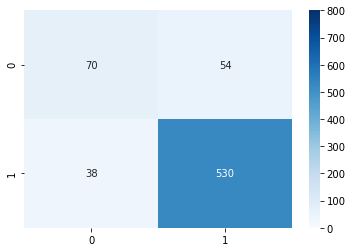

In [57]:
confusion = confusion_matrix(y_test, pred_catboost)
sns.heatmap(confusion, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

## 5. SVC

In [58]:
svc = SVC()

In [59]:
param_grid = {"svc__C": [0.1,1.0],
             "svc__gamma":['auto'],
             "svc__kernel":['rbf','linear'],
             "svc__class_weight":['balanced',None,{0:.4,1:.6},{0:.3,1:.7},{0:.7,1:.3}],
             "columntransformer__tfidfvectorizer-1__min_df":[1,2],
                "columntransformer__tfidfvectorizer-1__max_features":[None,200]}

In [60]:
pipe = make_pipeline(columns_trans, svc)

In [61]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [62]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['target_api',
                                                                          'categorie_juridique_label',
                                                                          'activite_principale_label']),
                                                                        ('tfidfvectorizer-1',
                                                                         TfidfVectorizer(),
                                                                         'nom_raison_sociale'),
                                                                        ('tfidfvectorizer-2',
                                             

In [63]:
grid.best_params_

{'columntransformer__tfidfvectorizer-1__max_features': None,
 'columntransformer__tfidfvectorizer-1__min_df': 1,
 'svc__C': 1.0,
 'svc__class_weight': {0: 0.4, 1: 0.6},
 'svc__gamma': 'auto',
 'svc__kernel': 'linear'}

In [64]:
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))

Best cross-validation accuracy: 0.87


In [65]:
pred_svc = grid.predict(X_test)
print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       0.71      0.57      0.63       124
           1       0.91      0.95      0.93       568

    accuracy                           0.88       692
   macro avg       0.81      0.76      0.78       692
weighted avg       0.87      0.88      0.88       692



In [66]:
print("Accuracy score using Vectorizer: {:.2f}".format(accuracy_score(y_test, pred_svc)))
print("F1-score using Vectorizer: {:.2f}".format(f1_score(y_test, pred_svc)))

Accuracy score using Vectorizer: 0.88
F1-score using Vectorizer: 0.93


In [67]:
#print("Accuracy score using number of words: {:.2f}".format(accuracy_score(y_test, pred_svc)))
#print("F1-score using number of words: {:.2f}".format(f1_score(y_test, pred_svc)))

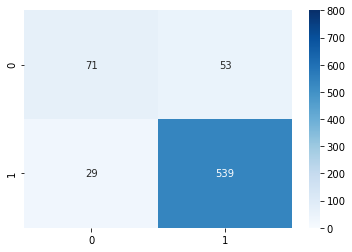

In [68]:
confusion = confusion_matrix(y_test, pred_svc)
sns.heatmap(confusion, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

In [69]:
#X_test[X_test['status_predicted']!= X_test['true_status']].to_csv('errors.csv')

In [70]:
errors = pd.read_csv('errors.csv')

## 6. MLP

In [71]:
mlp = MLPClassifier()

In [72]:
param_grid = {"mlpclassifier__activation" : ["relu","tanh"], 
           "mlpclassifier__solver" : ["adam"], 
           "mlpclassifier__alpha" : [0.0001,0.001], 
           "mlpclassifier__batch_size" : [100],
           "mlpclassifier__learning_rate_init" : [0.0001,0.001], 
           "mlpclassifier__random_state" : [64], 
           "mlpclassifier__early_stopping" : [True],
            "columntransformer__tfidfvectorizer-1__min_df":[1,2],
            "columntransformer__tfidfvectorizer-1__max_features":[None,200]
              }

In [73]:
pipe = make_pipeline(columns_trans, mlp)

In [74]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [75]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['target_api',
                                                                          'categorie_juridique_label',
                                                                          'activite_principale_label']),
                                                                        ('tfidfvectorizer-1',
                                                                         TfidfVectorizer(),
                                                                         'nom_raison_sociale'),
                                                                        ('tfidfvectorizer-2',
                                             

In [76]:
pred_mlp = grid.predict(X_test)
print(classification_report(y_test, pred_mlp))

              precision    recall  f1-score   support

           0       0.65      0.56      0.61       124
           1       0.91      0.93      0.92       568

    accuracy                           0.87       692
   macro avg       0.78      0.75      0.76       692
weighted avg       0.86      0.87      0.86       692



In [77]:
print("Accuracy score using Vectorizer: {:.2f}".format(accuracy_score(y_test, pred_mlp)))
print("F1-score using Vectorizer: {:.2f}".format(f1_score(y_test, pred_mlp)))

Accuracy score using Vectorizer: 0.87
F1-score using Vectorizer: 0.92


In [78]:
#print("Accuracy score using number of words: {:.2f}".format(accuracy_score(y_test, pred_mlp)))
#print("F1-score using number of words: {:.2f}".format(f1_score(y_test, pred_mlp)))

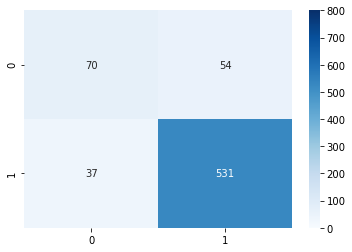

In [79]:
confusion = confusion_matrix(y_test, pred_mlp)
sns.heatmap(confusion, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

## 7. LightGBM

In [80]:
lightgbm = lgb.LGBMClassifier()

In [81]:
param_grid = {
    "lgbmclassifier__objective": ["binary"],
    "lgbmclassifier__metric": ["binary_logloss"],
    "lgbmclassifier__num_leaves":  [3, 7, 15, 31],  
    "lgbmclassifier__learning_rate": [0.05, 0.075, 0.1, 0.15],
    "lgbmclassifier__feature_fraction": [0.8, 0.9, 1.0],
    "lgbmclassifier__bagging_fraction": [0.8, 0.9, 1.0],
    "lgbmclassifier__min_data_in_leaf": [5,10, 15],
    "columntransformer__tfidfvectorizer-1__min_df":[1,2],
    "columntransformer__tfidfvectorizer-1__max_features":[None,200]
}

In [82]:
pipe = make_pipeline(columns_trans, lightgbm)

In [83]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [84]:
grid.fit(X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_f

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_f

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fract

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging

KeyboardInterrupt: 

In [ ]:
print("Best estimator:\n{}".format(grid.best_estimator_))

In [ ]:
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))

In [ ]:
pred_lightgbm = grid.predict(X_test)
print(classification_report(y_test, pred_lightgbm))

In [ ]:
print("Accuracy score using Vectorizer: {:.2f}".format(accuracy_score(y_test, pred_lightgbm)))
print("F1-score using Vectorizer: {:.2f}".format(f1_score(y_test, pred_lightgbm)))

In [ ]:
#print("Accuracy score using number of words: {:.2f}".format(accuracy_score(y_test, pred_lightgbm)))
#print("F1-score using nulber of words: {:.2f}".format(f1_score(y_test, pred_lightgbm)))

In [ ]:
confusion = confusion_matrix(y_test, pred_lightgbm)
sns.heatmap(confusion, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

In [ ]:
print(grid.predict_proba(X_test))

## 8. DecisionTree

In [79]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
pipe = make_pipeline(columns_trans, tree)

In [80]:
param_grid = {
     "decisiontreeclassifier__criterion": ["gini", "entropy"], 
     "decisiontreeclassifier__max_depth": [2, 3, 4],
    "columntransformer__tfidfvectorizer-1__min_df":[1,2],
    "columntransformer__tfidfvectorizer-1__max_features":[None,200]
}

In [81]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [82]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['target_api',
                                                                          'categorie_juridique_label',
                                                                          'activite_principale_label']),
                                                                        ('tfidfvectorizer-1',
                                                                         TfidfVectorizer(),
                                                                         'nom_raison_sociale'),
                                                                        ('tfidfvectorizer-2',
                                             

In [83]:
pred_tree = grid.predict(X_test)
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.58      0.52      0.55       124
           1       0.90      0.92      0.91       568

    accuracy                           0.85       692
   macro avg       0.74      0.72      0.73       692
weighted avg       0.84      0.85      0.84       692



In [84]:
model = grid.best_estimator_.named_steps['decisiontreeclassifier']

In [88]:
model.feature_importances_.shape

(6065,)